# Project summary


We are proposing two product lines **Hawkeye** and **Proofreader** in part 3 and 4, both using different models and datasets from part 1 and 2. Thus our notebook will be mainly divided  into 3 blocks.
 
1. **Section part 1 and part 2**

Contains the code for part 1 and 2, where we follow the project requirements and test self-trained (part 1) and pre-trained models on various labelled and un-labelled datasets.
 
2. **Section part 3&4: Hawkeye**

	*Contains the code for the product: Hawkeye*

a. Use entity-based sentiment analysis model on Twitter data and plot changes in sentiment over time.​

b. For days with large sentiment changes, perform topic modelling to identify key drivers of sentiment.
 
3. **Section part 3&4: Proofreader**

	*Contains the code for the product: Proofreader*

a. Calculate sentiment response scores based on the ratio of positive to negative replies. ​

b.Link the sentiment of replies to the contents of the main tweet via a regression model.


## Data on the google drive

Project folder link: https://drive.google.com/drive/folders/1XAUAdK5DLXKQWY06e9fXxGlxP59e3JEg?usp=sharing

This folder includes all the data, saved models and config files to run this notebook.

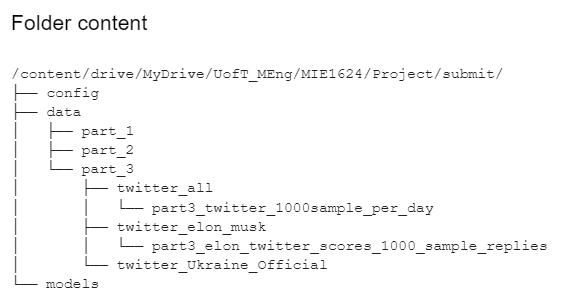


In [ ]:
# Please update the project_path to your folder.
# Most of the time-consuming training and model runs are commented out, the code will run on previous saved results.
# You may also uncomment the section to check usability.
# Mount GD
from google.colab import drive
drive.mount('/content/drive')

project_path='/content/drive/MyDrive/UofT_MEng/MIE1624/Project/submit/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Library imports

Please update the project_path to your folder.

Current project_path='/content/drive/MyDrive/UofT_MEng/MIE1624/Project/submit/'

In [ ]:
import pandas as pd
import numpy as np

import datetime as dt
from pprint import pprint
from itertools import chain

# Natural Language Toolkit
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords

import re

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (10, 8) # default plot size
import seaborn as sns
sns.set(style='whitegrid', palette='Dark2')

from wordcloud import WordCloud

# Data process functions

Credits to Group 16 presentation and notebooks.

## Helper functions

In [ ]:
import re
# import the nltk package to count the stopwords
import nltk
from nltk.corpus import stopwords  
nltk.download('stopwords')
# import PorterStemmer to do stemming
from nltk.stem import PorterStemmer
nltk.download('punkt')

stop_words = set(stopwords.words('english'))

# lower casing
#proc_data["text_lower"] = proc_data["text"].apply(lambda x: x.lower())
def to_lower_case(text):    
    return text.lower()

def remove_emoji(text):
    text = text.encode('ascii', 'ignore').decode('ascii') #it encodes a unicode string to ascii and ignores errors
    return text

# using the 're.sub' to remove urls.
def remove_urls(text):
    text = re.sub(r"http\S+", "", text, flags=re.IGNORECASE)
    text = re.sub(r"www.(\w+)", "", text, flags=re.IGNORECASE)
    return text

# using the 're.sub' to remove punctuation.
# but do care here, as we might want to preserve hashtags, as seperate feature (topic) or keep the meaning
def remove_punctuation(text):
    text = re.sub(r"[^\w\s]", "", text, flags=re.IGNORECASE)
    return text

# remove stop words
# Again, be careful here as we lose some information
#proc_data["text_lower"] = proc_data["text_lower"].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
# reworked to case-insensitive version
def remove_stopwords(text, stop_words=stop_words):    
    return ' '.join([word for word in text.split() if word.lower() not in (stop_words)])

# tokenization
#proc_data['tokenized'] = proc_data["text_lower"].apply(lambda txt:nltk.word_tokenize(txt))
def tokenization(text):    
    return nltk.word_tokenize(text)
                              
# Stemming
# This porter library takes cased text -> lower case
porter = PorterStemmer()
def to_stemming(text,porter=porter):
  return " ".join([porter.stem(word) for word in text.split()])

# Lemmatize
# This one is case sensitive, so need a bit of rework
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('omw-1.4')
wordnet_lemmatizer = WordNetLemmatizer()
def to_lemmatize(text, wordnet_lemmatizer=wordnet_lemmatizer):
  # careful about this on vary large text
  lm_text = []
  for word in text.split():
    lm_word = wordnet_lemmatizer.lemmatize(word.lower())    
    if word.istitle():
      lm_text.append(lm_word.capitalize())
    else:
      lm_text.append(lm_word)

  return " ".join(lm_text)
  #return " ".join([wordnet_lemmatizer.lemmatize(word) for word in text.split()])


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [ ]:
# using Textbolb libiary to do the spelling correction
# skipped, due to it might fix the wanted meme topics or wordings
import sys
!{sys.executable} -m pip install -U textblob
from textblob import TextBlob

#proc_data["text_lower_spell_fix"] = proc_data["text_lower"].apply(lambda txt: ''.join(TextBlob(txt).correct()))
def spell_correction(text):    
    return ''.join(TextBlob(text).correct())


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Remove punctuations but keep emoji, @ sign and # sign
# https://stackoverflow.com/questions/44101243/how-to-remove-everything-except-words-and-emoji-from-text
# https://carpedm20.github.io/emoji/docs/#extracting-emoji

!{sys.executable} -m pip install -U emoji
import emoji
import re

emoji_regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)

def remove_twitter_punctuation(text,emoji_regrex_pattern=emoji_regrex_pattern):
  tp_text = []
  for word in text.split():
    if(emoji.is_emoji(word)):
      tp_text.append(word)
    if(re.match(emoji_regrex_pattern, word)):
      # Also emojis
      tp_text.append(word)
    else:
      word = re.sub(r"[^\w\s\\/@#]+", "", word, flags=re.IGNORECASE)
      tp_text.append(word)

  return " ".join(tp_text)

# remove @username  
def remove_twitter_username(text):
  text = re.sub('@[\w]+','',text, flags=re.IGNORECASE)
  return text

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# I will skip part 1 models here, single we will mainly be using a pretrained entity-based sentiment model here
"""
# Loading the saved part 1 bow_convertor and tfidf_transformer
import pickle
# bow_tfidf.pkl is in GD shared-folder, models folder
with open('bow_tfidf.pkl', 'rb') as f:
    bow_convert, tfidfTfmer = pickle.load(f)
"""

#def fe_pipeline(raw_data, raw_col, fe_type="uncase", bow_convert=bow_convert, tfidfTfmer=tfidfTfmer):
def fe_pipeline(raw_data, raw_col, fe_type="uncase"):
  proc_data = raw_data.copy()  
  if(fe_type=="uncase"):
    uncase_col = raw_col+"_uncase"
    proc_data[uncase_col] = proc_data[raw_col].apply(to_lower_case)
    proc_data[uncase_col] = proc_data[uncase_col].apply(remove_emoji)
    proc_data[uncase_col] = proc_data[uncase_col].apply(remove_urls)
    proc_data[uncase_col] = proc_data[uncase_col].apply(remove_punctuation)
    proc_data[uncase_col] = proc_data[uncase_col].apply(remove_stopwords)
    proc_data[uncase_col] = proc_data[uncase_col].apply(to_lemmatize)

    proc_data[uncase_col+"_count"] = proc_data[uncase_col].apply(lambda x: len(x.split()))
  elif(fe_type=="case"):
    case_col = raw_col+"_case"
    proc_data[case_col] = proc_data[raw_col].apply(remove_emoji)
    proc_data[case_col] = proc_data[case_col].apply(remove_urls)
    proc_data[case_col] = proc_data[case_col].apply(remove_punctuation)
    proc_data[case_col] = proc_data[case_col].apply(remove_stopwords)
    proc_data[case_col] = proc_data[case_col].apply(to_lemmatize)

    proc_data[case_col+"_count"] = proc_data[case_col].apply(lambda x: len(x.split()))
  elif(fe_type=="part3"):
    case_col = raw_col+"_part3"    
    proc_data[case_col] = proc_data[raw_col].apply(remove_emoji)
    proc_data[case_col] = proc_data[case_col].apply(remove_urls)
    # Not used since there's french
    #proc_data[case_col] = proc_data[case_col].apply(remove_punctuation)
    # This alters the meaning, skipped
    #proc_data[case_col] = proc_data[case_col].apply(remove_stopwords)
    #proc_data[case_col] = proc_data[case_col].apply(to_lemmatize)

    proc_data[case_col+"_count"] = proc_data[case_col].apply(lambda x: len(x.split()))
  elif(fe_type=="part3_pr"):
    # This fe is for part 3 main tweets
    case_col = raw_col+"_part3_pr"    
    # Keep emoji, since they might be a key feature
    #proc_data[case_col] = proc_data[raw_col].apply(remove_emoji)

    proc_data[case_col] = proc_data[raw_col].apply(remove_urls)   
    proc_data[case_col] = proc_data[case_col].apply(remove_twitter_username)    
    # For the same reason keep some punctuations, as @, #, emojis all have SNS meanings
    proc_data[case_col] = proc_data[case_col].apply(remove_twitter_punctuation)    
    proc_data[case_col] = proc_data[case_col].apply(remove_stopwords)
    # Do not lemma
    #proc_data[case_col] = proc_data[case_col].apply(to_lemmatize)

    proc_data[case_col+"_count"] = proc_data[case_col].apply(lambda x: len(x.split()))

  
  return proc_data

# Evaluation functions

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, precision_recall_fscore_support, roc_curve, auc
import pickle, shutil

def all_eva(df,pred_cols=[]):  
  result_data = []
  for pred_col in pred_cols:
    result_data_row = []
    result_data_row.append(pred_col)
    result_data_row.append(accuracy_score(df["label"], df[pred_col]))
    precision, recall, f1_score, support_s = precision_recall_fscore_support(df["label"], df[pred_col],average="binary")
    result_data_row.append(precision)
    result_data_row.append(recall)
    result_data_row.append(f1_score)
    fpr, tpr, thresholds = roc_curve(df["label"], df[pred_col] , pos_label=1)
    auc_roc = auc(fpr, tpr)
    result_data_row.append(auc_roc)
    result_data.append(result_data_row)

  result_df = pd.DataFrame(result_data, columns=["Model", "Accuracy", "precision", "recall", "f1_score","AUC_ROC"])
  return result_df

# Part 1



## Load raw data (Skipped, please directly load saved train/test data ) 

**Since train_test_split(random_state=fixed) performs differently on different machines.**

This section is to demonstrate the process flow from raw data. You may skip to load already processed data.

In [ ]:
# If loaded from csv
# The csv file is directly from Quercus, or can be found in the GD shared-folder, data folder
raw_data = pd.read_csv(project_path+'data/part_1/sentiment_analysis.csv', low_memory=False)
raw_data.head()

ID  \
0  7.680980e+17   
1  7.680980e+17   
2  7.680980e+17   
3  7.680980e+17   
4  7.680980e+17   

                                                                                                                                           text  \
0                            Josh Jenkins is looking forward to TAB Breeders Crown Super Sunday https://t.co/antImqAo4Y https://t.co/ejnA78Sks0   
1  RT @MianUsmanJaved: Congratulations Pakistan on becoming #No1TestTeam in the world against all odds! #JI_PakZindabadRallies https://t.co/1o…   
2  RT @PEPalerts: This September, @YESmag is taking you to Maine Mendoza’s surprise thanksgiving party she threw for her fans! https://t.co/oX…   
3   RT @david_gaibis: Newly painted walls, thanks a million to our custodial painters this summer.  Great job ladies!!!#EC_proud https://t.co/…   
4            RT @CedricFeschotte: Excited to announce: as of July 2017 Feschotte lab will be relocating to @Cornell MBG https://t.co/dd0FG7BRx3   

   label  
0      1  
1      1  
2      1  
3      1  
4      1

### Feature engineering for part-1 models

In [ ]:
# for part 1 models
raw_data.dropna(axis=0, inplace=True) # 120 NaN values across 40 datapoints, dropping them model_data

part1_data_proc = fe_pipeline(raw_data,"text","uncase")

part1_data_proc.head()

ID  \
0  7.680980e+17   
1  7.680980e+17   
2  7.680980e+17   
3  7.680980e+17   
4  7.680980e+17   

                                                                                                                                           text  \
0                            Josh Jenkins is looking forward to TAB Breeders Crown Super Sunday https://t.co/antImqAo4Y https://t.co/ejnA78Sks0   
1  RT @MianUsmanJaved: Congratulations Pakistan on becoming #No1TestTeam in the world against all odds! #JI_PakZindabadRallies https://t.co/1o…   
2  RT @PEPalerts: This September, @YESmag is taking you to Maine Mendoza’s surprise thanksgiving party she threw for her fans! https://t.co/oX…   
3   RT @david_gaibis: Newly painted walls, thanks a million to our custodial painters this summer.  Great job ladies!!!#EC_proud https://t.co/…   
4            RT @CedricFeschotte: Excited to announce: as of July 2017 Feschotte lab will be relocating to @Cornell MBG https://t.co/dd0FG7BRx3   

   label  \
0      1   
1      1   
2      1   
3      1   
4      1   

                                                                                           text_uncase  \
0                                          josh jenkins looking forward tab breeder crown super sunday   
1      rt mianusmanjaved congratulation pakistan becoming no1testteam world odds ji_pakzindabadrallies   
2            rt pepalerts september yesmag taking maine mendozas surprise thanksgiving party threw fan   
3  rt david_gaibis newly painted wall thanks million custodial painter summer great job ladiesec_proud   
4                   rt cedricfeschotte excited announce july 2017 feschotte lab relocating cornell mbg   

   text_uncase_count  
0                  9  
1                  9  
2                 12  
3                 13  
4                 11

In [ ]:
# Train test splits redo (may skip to just use saved proc data from part 1)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(part1_data_proc["text_uncase"], part1_data_proc["label"], test_size=2/3, random_state=42)

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

def dummy_lambda(doc):
  return doc

# BOW
#bow_convert = CountVectorizer(ngram_range= [2,2], lowercase = False)
bow_convert = CountVectorizer(tokenizer = dummy_lambda, ngram_range= [2,2], lowercase = False)
x_tr_bow = bow_convert.fit_transform(X_train)
x_te = bow_convert.transform(X_test)

# TFIDF
tv = TfidfVectorizer(min_df=0.0, max_df=1.0, ngram_range=(2,2), sublinear_tf=True)
X_train_tv = tv.fit_transform(X_train)
X_test_tv = tv.transform(X_test)

### For part 2 pre-trained models

In [ ]:
# Encapsulate to df
X_train_df = pd.DataFrame(X_train.tolist(),columns=["text_uncase"])
X_test_df = pd.DataFrame(X_test.tolist(),columns=["text_uncase"])

# for uncase/case models 
# because we want to compare on the same testset, all models will use lower cased texts
X_train_df["text_case"] = X_train_df["text_uncase"]
X_test_df["text_case"] = X_test_df["text_uncase"]

print(X_test_df.shape)
#X_test_df.head()

(366928, 2)


### Save train test split, and the encoders

In [ ]:
import pickle

# commented out in case of overwrites
"""

# Save train test split raw_data
with open(project_path+'/data/part_1/train_test_split_part_1.pkl', 'wb') as fout:
  pickle.dump((X_train, X_test, y_train, y_test), fout)

# Save bow encoder and encoded train test split
with open(project_path+'/data/part_1/bow.pkl', 'wb') as fout:
  pickle.dump((bow_convert, x_tr_bow, x_te), fout)

# Save tfidf encoder and encoded train test split
with open(project_path+'/data/part_1/tv.pkl', 'wb') as fout:
    pickle.dump((tv, X_train_tv, X_test_tv), fout)

"""

"\n\n# Save train test split raw_data\nwith open(project_path+'/data/part_1/train_test_split_part_1.pkl', 'wb') as fout:\n  pickle.dump((X_train, X_test, y_train, y_test), fout)\n\n# Save bow encoder and encoded train test split\nwith open(project_path+'/data/part_1/bow.pkl', 'wb') as fout:\n  pickle.dump((bow_convert, x_tr_bow, x_te), fout)\n\n# Save tfidf encoder and encoded train test split\nwith open(project_path+'/data/part_1/tv.pkl', 'wb') as fout:\n    pickle.dump((tv, X_train_tv, X_test_tv), fout)\n\n"

## Load saved train/test data



In [ ]:
# Load part 1 testset
# Loading the saved part 1 testsets
import pickle

# The text train_test sets
# part1_dataset_train_test.pkl is in GD shared-folder, data folder
with open(project_path+'/data/part_1/train_test_split_part_1.pkl', 'rb') as f:
    X_train, X_test, y_train, y_test = pickle.load(f)

# Load the encoders and encoded data
with open(project_path+'/data/part_1/bow.pkl', 'rb') as f:
    bow_convert, x_tr_bow, x_te = pickle.load(f)    

with open(project_path+'/data/part_1/tv.pkl', 'rb') as f:
    tv, X_train_tv, X_test_tv = pickle.load(f)

## Part 1: Simple Sentiment Models (May skip to load final results csv)

In [ ]:
# imports
from sklearn.model_selection import train_test_split    
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
import numpy as np
import pandas as pd
import scipy
import time


### 1.1 Logistic Regression

In [ ]:
# Uncomment to run
# Or load saved results in later section
"""
lr_bow = LogisticRegression(penalty = 'l2', solver = 'liblinear', random_state = 42)
lr_tfidf = LogisticRegression(penalty = 'l2', solver = 'liblinear', random_state = 42)

start = time.time()
lr_bow_scores = cross_val_score(lr_bow, x_tr_bow, y_train, cv = 10)
stop = time.time()
print(f"BOW training time: {stop - start}s")

start = time.time()
lr_tfidf_scores = cross_val_score(lr_tfidf, X_train_tv, y_train, cv = 10)
stop = time.time()
print(f"TFIDF training time: {stop - start}s")

print("%0.4f BOW Accuracy with std dev of %0.4f" % (lr_bow_scores.mean(), lr_bow_scores.std()))
print("%0.4f TFIDF Accuracy with std dev of %0.4f" % (lr_tfidf_scores.mean(), lr_tfidf_scores.std()))
"""

#### RESULTS ####
# BOW training time: 242.75456595420837s
# TFIDF training time: 19.941850900650024s
# 0.8402 BOW Accuracy with std dev of 0.0019
# 0.7800 TFIDF Accuracy with std dev of 0.0030

'\nlr_bow = LogisticRegression(penalty = \'l2\', solver = \'liblinear\', random_state = 42)\nlr_tfidf = LogisticRegression(penalty = \'l2\', solver = \'liblinear\', random_state = 42)\n\nstart = time.time()\nlr_bow_scores = cross_val_score(lr_bow, x_tr_bow, y_train, cv = 10)\nstop = time.time()\nprint(f"BOW training time: {stop - start}s")\n\nstart = time.time()\nlr_tfidf_scores = cross_val_score(lr_tfidf, X_train_tv, y_train, cv = 10)\nstop = time.time()\nprint(f"TFIDF training time: {stop - start}s")\n\nprint("%0.4f BOW Accuracy with std dev of %0.4f" % (lr_bow_scores.mean(), lr_bow_scores.std()))\nprint("%0.4f TFIDF Accuracy with std dev of %0.4f" % (lr_tfidf_scores.mean(), lr_tfidf_scores.std()))\n'

### 1.2 Random Forest

In [ ]:
# Uncomment to run
# Or load saved results in later section
"""
rf_bow = RandomForestClassifier(n_estimators = 100, max_depth = 3, random_state = 42)
rf_tfidf = RandomForestClassifier(n_estimators = 100, max_depth = 3, random_state = 42)

start = time.time()
rf_bow_scores = cross_val_score(rf_bow, x_tr_bow, y_train, cv = 10)
stop = time.time()
print(f"BOW training time: {stop - start}s")

start = time.time()
rf_tfidf_scores = cross_val_score(rf_tfidf, X_train_tv, y_train, cv = 10)
stop = time.time()
print(f"TFIDF training time: {stop - start}s")

print("%0.4f BOW Accuracy with std dev of %0.4f" % (rf_bow_scores.mean(), rf_bow_scores.std()))
print("%0.4f TFIDF Accuracy with std dev of %0.4f" % (rf_tfidf_scores.mean(), rf_tfidf_scores.std()))
"""
#### RESULTS ####
# BOW training time: 43.490965366363525s
# TFIDF training time: 295.772301197052s
# 0.6753 BOW Accuracy with std dev of 0.0000
# 0.6753 TFIDF Accuracy with std dev of 0.0000

'\nrf_bow = RandomForestClassifier(n_estimators = 100, max_depth = 3, random_state = 42)\nrf_tfidf = RandomForestClassifier(n_estimators = 100, max_depth = 3, random_state = 42)\n\nstart = time.time()\nrf_bow_scores = cross_val_score(rf_bow, x_tr_bow, y_train, cv = 10)\nstop = time.time()\nprint(f"BOW training time: {stop - start}s")\n\nstart = time.time()\nrf_tfidf_scores = cross_val_score(rf_tfidf, X_train_tv, y_train, cv = 10)\nstop = time.time()\nprint(f"TFIDF training time: {stop - start}s")\n\nprint("%0.4f BOW Accuracy with std dev of %0.4f" % (rf_bow_scores.mean(), rf_bow_scores.std()))\nprint("%0.4f TFIDF Accuracy with std dev of %0.4f" % (rf_tfidf_scores.mean(), rf_tfidf_scores.std()))\n'

### 1.3 SVC

In [ ]:
# Uncomment to run
# Or load saved results in later section
"""
svc_bow = LinearSVC(random_state = 42, dual = False)
svc_tfidf = LinearSVC(random_state = 42, dual = False)
start = time.time()
svc_bow_scores = cross_val_score(svc_bow, x_tr_bow, y_train, cv = 10)
stop = time.time()
print(f"BOW training time: {stop - start}s")

start = time.time()
svc_tfidf_scores = cross_val_score(svc_tfidf, X_train_tv, y_train, cv = 10)
stop = time.time()
print(f"TFIDF training time: {stop - start}s")

print("%0.4f BOW Accuracy with std dev of %0.4f" % (svc_bow_scores.mean(), svc_bow_scores.std()))
print("%0.4f TFIDF Accuracy with std dev of %0.4f" % (svc_tfidf_scores.mean(), svc_tfidf_scores.std()))
"""
#### RESULTS ####
# BOW training time: 2.8896584510803223s
# TFIDF training time: 0.43792104721069336s
# 0.8738 BOW Accuracy with std dev of 0.0089
# 0.8942 TFIDF Accuracy with std dev of 0.0051

'\nsvc_bow = LinearSVC(random_state = 42, dual = False)\nsvc_tfidf = LinearSVC(random_state = 42, dual = False)\nstart = time.time()\nsvc_bow_scores = cross_val_score(svc_bow, x_tr_bow, y_train, cv = 10)\nstop = time.time()\nprint(f"BOW training time: {stop - start}s")\n\nstart = time.time()\nsvc_tfidf_scores = cross_val_score(svc_tfidf, X_train_tv, y_train, cv = 10)\nstop = time.time()\nprint(f"TFIDF training time: {stop - start}s")\n\nprint("%0.4f BOW Accuracy with std dev of %0.4f" % (svc_bow_scores.mean(), svc_bow_scores.std()))\nprint("%0.4f TFIDF Accuracy with std dev of %0.4f" % (svc_tfidf_scores.mean(), svc_tfidf_scores.std()))\n'

### 1.4 MLP Classifier

In [ ]:
# Uncomment to run
# Or load saved results in later section
"""
nn_bow = MLPClassifier(random_state = 42)

start = time.time()
nn_bow_scores = cross_val_score(nn_bow, x_tr_bow, y_train, cv = 10)
stop = time.time()
print(f"BOW training time: {stop - start}s")

print("%0.4f BOW Accuracy with std dev of %0.4f" % (nn_bow_scores.mean(), nn_bow_scores.std()))
"""
#### RESULTS ####
# BOW training time: 344.6926636695862s
# 0.9287 BOW Accuracy with std dev of 0.0058

'\nnn_bow = MLPClassifier(random_state = 42)\n\nstart = time.time()\nnn_bow_scores = cross_val_score(nn_bow, x_tr_bow, y_train, cv = 10)\nstop = time.time()\nprint(f"BOW training time: {stop - start}s")\n\nprint("%0.4f BOW Accuracy with std dev of %0.4f" % (nn_bow_scores.mean(), nn_bow_scores.std()))\n'

In [ ]:
# Uncomment to run
# Or load saved results in later section
"""
nn_tfidf = MLPClassifier(random_state = 42)
start = time.time()
nn_tfidf_scores = cross_val_score(nn_tfidf, X_train_tv, y_train, cv = 10)
stop = time.time()
print(f"TFIDF training time: {stop - start}s")
print("%0.4f TFIDF Accuracy with std dev of %0.4f" % (nn_tfidf_scores.mean(), nn_tfidf_scores.std()))
"""

'\nnn_tfidf = MLPClassifier(random_state = 42)\nstart = time.time()\nnn_tfidf_scores = cross_val_score(nn_tfidf, X_train_tv, y_train, cv = 10)\nstop = time.time()\nprint(f"TFIDF training time: {stop - start}s")\nprint("%0.4f TFIDF Accuracy with std dev of %0.4f" % (nn_tfidf_scores.mean(), nn_tfidf_scores.std()))\n'

### Hyperparameter Tuning

Overall it looks like bag-of-words encoding performed better and/or was significantly faster for training. Therefore, we will proceed with hyperparameter tuning using BOW.

In [ ]:
# Uncomment to run
# Or load saved results in later section
"""
start = time.time()
lr = LogisticRegression(random_state = 42, max_iter = 2500) 
#convergence warning on some of the C values in gridsearch, so increased the max_iters
lr_param_grid =  [{'C': [0.001, 0.01, 0.1, 1, 10, 100]}]

lr_grid_search = GridSearchCV(lr, lr_param_grid, cv=5, scoring = 'f1', return_train_score=True)

lr_grid_search.fit(x_tr_bow, y_train)

lr_best_parameters = lr_grid_search.best_params_
lr_best_model = lr_grid_search.best_estimator_
stop = time.time()

print("Best parameters : {}".format(lr_best_parameters))
print("Best cross-validation score : {:.2f}".format(lr_grid_search.best_score_*100))
print(f"Training time: {stop - start}s")

"""
#### RESULTS ####
# Best parameters : {'C': 0.1}
# Best cross-validation score : 88.34
# Training time: 753.5266659259796s

'\nstart = time.time()\nlr = LogisticRegression(random_state = 42, max_iter = 2500) \n#convergence warning on some of the C values in gridsearch, so increased the max_iters\nlr_param_grid =  [{\'C\': [0.001, 0.01, 0.1, 1, 10, 100]}]\n\nlr_grid_search = GridSearchCV(lr, lr_param_grid, cv=5, scoring = \'f1\', return_train_score=True)\n\nlr_grid_search.fit(x_tr_bow, y_train)\n\nlr_best_parameters = lr_grid_search.best_params_\nlr_best_model = lr_grid_search.best_estimator_\nstop = time.time()\n\nprint("Best parameters : {}".format(lr_best_parameters))\nprint("Best cross-validation score : {:.2f}".format(lr_grid_search.best_score_*100))\nprint(f"Training time: {stop - start}s")\n\n'

In [ ]:
# Uncomment to run
# Or load saved results in later section
"""
start = time.time()
rf = RandomForestClassifier(random_state = 42)

rf_param_grid =  [{'n_estimators': [100, 250, 500], 'max_depth': [2,3,4,5,6,7,8]}]

rf_grid_search = GridSearchCV(rf, rf_param_grid, cv=5, scoring = 'f1', return_train_score=True)

rf_grid_search.fit(x_tr_bow, y_train)

rf_best_parameters = rf_grid_search.best_params_
rf_best_model = rf_grid_search.best_estimator_
stop = time.time()

print("Best parameters : {}".format(rf_best_parameters))
print("Best cross-validation score : {:.2f}".format(rf_grid_search.best_score_*100))
print(f"Training time: {stop - start}s")
"""

#### RESULTS ####
# Best parameters : {'max_depth': 8, 'n_estimators': 100}
# Best cross-validation score : 80.86
# Training time: 2778.032377243042s

'\nstart = time.time()\nrf = RandomForestClassifier(random_state = 42)\n\nrf_param_grid =  [{\'n_estimators\': [100, 250, 500], \'max_depth\': [2,3,4,5,6,7,8]}]\n\nrf_grid_search = GridSearchCV(rf, rf_param_grid, cv=5, scoring = \'f1\', return_train_score=True)\n\nrf_grid_search.fit(x_tr_bow, y_train)\n\nrf_best_parameters = rf_grid_search.best_params_\nrf_best_model = rf_grid_search.best_estimator_\nstop = time.time()\n\nprint("Best parameters : {}".format(rf_best_parameters))\nprint("Best cross-validation score : {:.2f}".format(rf_grid_search.best_score_*100))\nprint(f"Training time: {stop - start}s")\n'

In [ ]:
# Uncomment to run
# Or load saved results in later section
"""
start = time.time()
svc = LinearSVC(random_state = 42, dual = False, max_iter = 2500)

svc_param_grid =  [{'C': [0.001, 0.01, 0.1, 1, 10, 100]}]

svc_grid_search = GridSearchCV(svc, svc_param_grid, cv=5, scoring = 'f1', return_train_score=True)

svc_grid_search.fit(x_tr_bow, y_train)

svc_best_parameters = svc_grid_search.best_params_
svc_best_model = svc_grid_search.best_estimator_

stop = time.time()

print("Best parameters : {}".format(svc_best_parameters))
print("Best cross-validation score : {:.2f}".format(svc_grid_search.best_score_*100))
print(f"Training time: {stop - start}s")
"""
#### RESULTS ####
# Best parameters : {'C': 0.01}
# Best cross-validation score : 88.30
# Training time: 769.4052269458771s

'\nstart = time.time()\nsvc = LinearSVC(random_state = 42, dual = False, max_iter = 2500)\n\nsvc_param_grid =  [{\'C\': [0.001, 0.01, 0.1, 1, 10, 100]}]\n\nsvc_grid_search = GridSearchCV(svc, svc_param_grid, cv=5, scoring = \'f1\', return_train_score=True)\n\nsvc_grid_search.fit(x_tr_bow, y_train)\n\nsvc_best_parameters = svc_grid_search.best_params_\nsvc_best_model = svc_grid_search.best_estimator_\n\nstop = time.time()\n\nprint("Best parameters : {}".format(svc_best_parameters))\nprint("Best cross-validation score : {:.2f}".format(svc_grid_search.best_score_*100))\nprint(f"Training time: {stop - start}s")\n'

In [ ]:
# Uncomment to run
# Or load saved results in later section
"""
start = time.time()
nn = MLPClassifier(random_state = 42)

nn_param_grid =  [{'hidden_layer_sizes': [(100,), (10, 10), (5, 10, 10, 5)], 'activation': ['identity', 'logistic', 'tanh', 'relu']}]

nn_grid_search = GridSearchCV(nn, nn_param_grid, cv=5, scoring = 'f1', return_train_score=True)

nn_grid_search.fit(x_tr_bow, y_train)

nn_best_parameters = nn_grid_search.best_params_
nn_best_model = nn_grid_search.best_estimator_
stop = time.time()

print("Best parameters : {}".format(nn_best_parameters))
print("Best cross-validation score : {:.2f}".format(nn_grid_search.best_score_*100))
print(f"Training time: {stop - start}s")
"""

#### RESULTS ####
# Best parameters : {'activation': 'relu', 'hidden_layer_sizes': (100,)}
# Best cross-validation score : 92.36
# Training time: 20009.48345708847s

'\nstart = time.time()\nnn = MLPClassifier(random_state = 42)\n\nnn_param_grid =  [{\'hidden_layer_sizes\': [(100,), (10, 10), (5, 10, 10, 5)], \'activation\': [\'identity\', \'logistic\', \'tanh\', \'relu\']}]\n\nnn_grid_search = GridSearchCV(nn, nn_param_grid, cv=5, scoring = \'f1\', return_train_score=True)\n\nnn_grid_search.fit(x_tr_bow, y_train)\n\nnn_best_parameters = nn_grid_search.best_params_\nnn_best_model = nn_grid_search.best_estimator_\nstop = time.time()\n\nprint("Best parameters : {}".format(nn_best_parameters))\nprint("Best cross-validation score : {:.2f}".format(nn_grid_search.best_score_*100))\nprint(f"Training time: {stop - start}s")\n'

In [ ]:
best_res = pd.DataFrame(data = y_test, columns = ['label'])

### Testing Best models on Test Set

In [ ]:
# Uncomment to run
# Or load saved results in later section
"""
lr_best = LogisticRegression(C = 0.1, random_state = 42, max_iter = 2500)
start = time.time()
lr_best.fit(x_tr_bow, y_train)

lr_pred = lr_best.predict(x_te)
best_res['log_reg_pred_label'] = lr_pred

lr_best_scores = lr_best.score(x_te, y_test)
stop = time.time()
print(f"Training time: {stop - start}s")
print("%0.4f Accuracy with precision of %0.4f, recall of %0.4f, and f1 score of %0.4f" % (accuracy_score(y_test, lr_pred), precision_score(y_test, lr_pred), recall_score(y_test, lr_pred), f1_score(y_test, lr_pred)))
"""

# Save are commented out in case of re-run and overwrite
#pickle.dump(lr_best, open(project_path+'/models/logreg.pkl', 'wb'))
#### RESULTS ####
# Training time: 138.04892945289612s
# 0.8414 Accuracy with std dev of 0.0007

'\nlr_best = LogisticRegression(C = 0.1, random_state = 42, max_iter = 2500)\nstart = time.time()\nlr_best.fit(x_tr_bow, y_train)\n\nlr_pred = lr_best.predict(x_te)\nbest_res[\'log_reg_pred_label\'] = lr_pred\n\nlr_best_scores = lr_best.score(x_te, y_test)\nstop = time.time()\nprint(f"Training time: {stop - start}s")\nprint("%0.4f Accuracy with precision of %0.4f, recall of %0.4f, and f1 score of %0.4f" % (accuracy_score(y_test, lr_pred), precision_score(y_test, lr_pred), recall_score(y_test, lr_pred), f1_score(y_test, lr_pred)))\n'

In [ ]:
# Uncomment to run
# Or load saved results in later section
"""
rf_best = RandomForestClassifier(n_estimators = 100, max_depth = 8, random_state = 42)
start = time.time()
rf_best.fit(x_tr_bow, y_train)

rf_pred = rf_best.predict(x_te)
best_res['rf_pred_label'] = rf_pred

rf_best_scores = rf_best.score(x_te, y_test)
stop = time.time()
print(f"Training time: {stop - start}s")
print("%0.4f Accuracy with precision of %0.4f, recall of %0.4f, and f1 score of %0.4f" % (accuracy_score(y_test, rf_pred), precision_score(y_test, rf_pred), recall_score(y_test, rf_pred), f1_score(y_test, rf_pred)))
"""
# Save are commented out in case of re-run and overwrite
#pickle.dump(rf_best, open(project_path+'/models/random_forest.pkl', 'wb'))
# /content/random_forest.pkl
#### RESULTS ####
# Training time: 166.6468689441681s
# 0.6784 Accuracy with std dev of 0.0007

'\nrf_best = RandomForestClassifier(n_estimators = 100, max_depth = 8, random_state = 42)\nstart = time.time()\nrf_best.fit(x_tr_bow, y_train)\n\nrf_pred = rf_best.predict(x_te)\nbest_res[\'rf_pred_label\'] = rf_pred\n\nrf_best_scores = rf_best.score(x_te, y_test)\nstop = time.time()\nprint(f"Training time: {stop - start}s")\nprint("%0.4f Accuracy with precision of %0.4f, recall of %0.4f, and f1 score of %0.4f" % (accuracy_score(y_test, rf_pred), precision_score(y_test, rf_pred), recall_score(y_test, rf_pred), f1_score(y_test, rf_pred)))\n'

In [ ]:
# Uncomment to run
# Or load saved results in later section
"""
svc_best = LinearSVC(random_state = 42, dual = False, max_iter = 2500, C = 0.01)

start = time.time()
svc_best.fit(x_tr_bow, y_train)

svc_pred = svc_best.predict(x_te)
best_res['svc_pred_label'] = svc_pred

svc_best_scores = svc_best.score(x_te, y_test)
stop = time.time()
print(f"Training time: {stop - start}s")
print("%0.4f Accuracy with precision of %0.4f, recall of %0.4f, and f1 score of %0.4f" % (accuracy_score(y_test, svc_pred), precision_score(y_test, svc_pred), recall_score(y_test, svc_pred), f1_score(y_test, svc_pred)))
"""
# Save are commented out in case of re-run and overwrite
#pickle.dump(svc_best, open(project_path+'/models/svc.pkl', 'wb'))
#### RESULTS ####
# Training time: 103.14942646026611s
# 0.8411 Accuracy with std dev of 0.0008

'\nsvc_best = LinearSVC(random_state = 42, dual = False, max_iter = 2500, C = 0.01)\n\nstart = time.time()\nsvc_best.fit(x_tr_bow, y_train)\n\nsvc_pred = svc_best.predict(x_te)\nbest_res[\'svc_pred_label\'] = svc_pred\n\nsvc_best_scores = svc_best.score(x_te, y_test)\nstop = time.time()\nprint(f"Training time: {stop - start}s")\nprint("%0.4f Accuracy with precision of %0.4f, recall of %0.4f, and f1 score of %0.4f" % (accuracy_score(y_test, svc_pred), precision_score(y_test, svc_pred), recall_score(y_test, svc_pred), f1_score(y_test, svc_pred)))\n'

In [ ]:
# Uncomment to run
# Or load saved results in later section
"""
nn_best = MLPClassifier(hidden_layer_sizes = (100,), random_state = 42, activation = "relu")

start = time.time()
nn_best.fit(x_tr_bow, y_train)

nn_pred = nn_best.predict(x_te)
best_res['nn_pred_label'] = nn_pred

nn_best_scores = nn_best.score(x_te, y_test)
stop = time.time()
print(f"Training time: {stop - start}s")
print("%0.4f Accuracy with precision of %0.4f, recall of %0.4f, and f1 score of %0.4f" % (accuracy_score(y_test, nn_pred), precision_score(y_test, nn_pred), recall_score(y_test, nn_pred), f1_score(y_test, nn_pred)))
"""

#### RESULTS ####
# Training time: 423.5351731777191s
# 0.8956 Accuracy with precision of 0.9242, recall of 0.9209, and f1 score of 0.9225

'\nnn_best = MLPClassifier(hidden_layer_sizes = (100,), random_state = 42, activation = "relu")\n\nstart = time.time()\nnn_best.fit(x_tr_bow, y_train)\n\nnn_pred = nn_best.predict(x_te)\nbest_res[\'nn_pred_label\'] = nn_pred\n\nnn_best_scores = nn_best.score(x_te, y_test)\nstop = time.time()\nprint(f"Training time: {stop - start}s")\nprint("%0.4f Accuracy with precision of %0.4f, recall of %0.4f, and f1 score of %0.4f" % (accuracy_score(y_test, nn_pred), precision_score(y_test, nn_pred), recall_score(y_test, nn_pred), f1_score(y_test, nn_pred)))\n'

#### Save all results

In [ ]:
# Save are commented out in case of re-run and overwrite
#pickle.dump(nn_best, open(project_path+'/models/bow_MLP.pkl', 'wb'))
#shutil.copy('/content/bow_MLP.pkl', project_path+'/models/')

In [ ]:
# Save are commented out in case of re-run and overwrite
#best_res.to_csv('part_1_pred_label_models.csv', encoding='utf-8', index=False)
#shutil.copy('/content/part_1_pred_label_models.csv', project_path+'/data/part_1/')

In [ ]:
# Save are commented out in case of re-run and overwrite
#part1_result_df = all_eva(best_res, pred_cols = ['log_reg_pred_label', 'rf_pred_label', 'svc_pred_label', 'nn_pred_label'])
#part1_result_df.to_csv('part_1_model_scores.csv', encoding='utf-8', index=False)
#shutil.copy('/content/part_1_model_scores.csv', project_path+'/data/part_1/')

In [ ]:
### DO NOT RUN ###

# shutil.copy('/content/logreg.pkl', '/content/drive/MyDrive/MIE1624_Project/data')
# shutil.copy('/content/random_forest.pkl', '/content/drive/MyDrive/MIE1624_Project/data')
# shutil.copy('/content/svc.pkl', '/content/drive/MyDrive/MIE1624_Project/data')
# shutil.copy('/content/MLP.pkl', '/content/drive/MyDrive/MIE1624_Project/data')

### Pick our best model

Best part 1 models = BOW + MLP

In [ ]:
part1_result_df=pd.read_csv(project_path+'data/part_1/part_1_model_scores.csv', low_memory=False)
part1_result_df

Model  Accuracy  precision    recall  f1_score   AUC_ROC
0  log_reg_pred_label  0.840058   0.871756  0.894446  0.882955  0.810907
1       rf_pred_label  0.678960   0.677520  0.999972  0.807754  0.506906
2      svc_pred_label  0.839916   0.873167  0.892260  0.882610  0.811861
3       nn_pred_label  0.897108   0.915157  0.934043  0.924504  0.877312

# Part 2

## Pre-trained Models

https://towardsdatascience.com/the-most-favorable-pre-trained-sentiment-classifiers-in-python-9107c06442c6

### Happy Transformer

Happy Transformer is a package built on top of Hugging Face’s transformer library.

The output of the text classifier are these scores:

label– “positive”, “negative”, or “neutral“ describes the polarity of sentiment

score– float value in the range [0:1] reflecting the intensity of sentiment

With Hugging Face’s transformers, we can import many pre-trained models that are tuned for specific purposes. For example, FINBert is designed to tackle the NLP tasks in the financial domain. On the Hugging Face project website, you’ll find detailed information about model architectures, including links to original papers.

Github:
https://github.com/EricFillion/happy-transformer

Models:
https://huggingface.co/models?pipeline_tag=text-classification&sort=downloads

#### Install

In [ ]:
# install happy_tc
!pip install happytransformer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#### rewrite some functions

Well since happy tc only returns the first result (largest score), I'm gonna re-write some of its functions.

For the 3 labels models, the function will compare the score between only pos/neg and return the argmax one.

In [ ]:

"""
Contains a class called HappyTextClassification that performs text classification
"""
from dataclasses import dataclass

from transformers import TextClassificationPipeline, AutoConfig, AutoModelForSequenceClassification

from happytransformer.tc.trainer import TCTrainer, TCTrainArgs, TCEvalArgs, TCTestArgs
from happytransformer.cuda_detect import detect_cuda_device_number
from happytransformer.happy_transformer import HappyTransformer
from happytransformer.adaptors import get_adaptor
from happytransformer.tc import ARGS_TC_TRAIN, ARGS_TC_EVAL, ARGS_TC_TEST
from happytransformer.happy_trainer import EvalResult
from happytransformer.fine_tuning_util import create_args_dataclass


@dataclass
class TextClassificationResult:
    label: str
    score: float

class MyHappyTextClassification(HappyTransformer):
    """
    A user facing class for Text Classification
    """

    def __init__(self, model_type="DISTILBERT",
                 model_name="distilbert-base-uncased", num_labels: int = 2, load_path: str = "", use_auth_token: str = None, from_tf=False):
        self.adaptor = get_adaptor(model_type)

        config = AutoConfig.from_pretrained(model_name, num_labels=num_labels)

        if load_path != "":
            model = AutoModelForSequenceClassification.from_pretrained(load_path, config=config, from_tf=from_tf)
        else:
            model = AutoModelForSequenceClassification.from_pretrained(model_name, config=config, use_auth_token=use_auth_token, from_tf=from_tf)


        super().__init__(model_type, model_name, model, use_auth_token=use_auth_token, load_path=load_path)

        device_number = detect_cuda_device_number()
        self._pipeline = TextClassificationPipeline(
            model=self.model, tokenizer=self.tokenizer,
            device=device_number,
            # Here force return 3 labels
            top_k=3
        )

        self._trainer = TCTrainer(
            self.model, self.model_type,
            self.tokenizer, self._device, self.logger
        )

    def classify_text(self, text: str) -> TextClassificationResult:
        """
        Classify text to a label based on model's training
        """
        # Blocking allowing a for a list of strings
        if not isinstance(text, str):
            raise ValueError("the \"text\" argument must be a single string")
        results = self._pipeline(text)
        # we do not support predicting a list of  texts, so only first prediction is relevant
        first_result = results[0]

        return TextClassificationResult(label=first_result["label"], score=first_result["score"])

    # For 2 labels
    def classify_text_2labels(self, text: str) -> TextClassificationResult:
        """
        Classify text to a label based on model's training
        """
        # Blocking allowing a for a list of strings
        if not isinstance(text, str):
            raise ValueError("the \"text\" argument must be a single string")
        results = self._pipeline(text)
        # we do not support predicting a list of  texts, so only first prediction is relevant
        #first_result = results[0][0]

        # [[{'label': 'POSITIVE', 'score': 0.723540186882019}, {'label': 'NEGATIVE', 'score': 0.2764597535133362}]]        
        pos_score,neg_score=0.0,0.0
        for pred_row in results[0]:
          #print(pred_row)
          if pred_row["label"] == "POSITIVE":
            pos_score = pred_row["score"]
          elif pred_row["label"] == "NEGATIVE":
            neg_score = pred_row["score"]

        #pos_score,neg_score
        if(pos_score >= neg_score):
          return 1,results
        else:
          return 0,results

    # For 2 labels
    def classify_text_3labels(self, text: str) -> TextClassificationResult:
        """
        Classify text to a label based on model's training, compare only to pos/neg labels
        """
        # Blocking allowing a for a list of strings
        if not isinstance(text, str):
            raise ValueError("the \"text\" argument must be a single string")
        results = self._pipeline(text)
        # we do not support predicting a list of  texts, so only first prediction is relevant
        first_result = results[0][0]

        #return TextClassificationResult(label=first_result["label"], score=first_result["score"])
        # LABEL_2 = positive, LABEL_0 = negative, LABEL_1 = neutral
        str_label_to_int = {"LABEL_2":1, "LABEL_0":0, "LABEL_1":2}

        pos_score,neg_score=0.0,0.0
        for pred_row in results[0]:
          #print(pred_row)
          if pred_row["label"] == "LABEL_2":
            pos_score = pred_row["score"]
          elif pred_row["label"] == "LABEL_0":
            neg_score = pred_row["score"]

        #pos_score,neg_score
        if(pos_score >= neg_score):
          return 1,str_label_to_int[first_result["label"]], results
        else:
          return 0,str_label_to_int[first_result["label"]], results



    
    def train(self, input_filepath, args=TCTrainArgs()):
        """
        Trains the question answering model
        input_filepath: a string that contains the location of a csv file
        for training. Contains the following header values: text, label
        args: Either a TCTrainArgs() object or a dictionary that contains all of the same keys as ARGS_TC_TRAIN
        return: None
        """
        if type(args) == dict:
            method_dataclass_args = create_args_dataclass(default_dic_args=ARGS_TC_TRAIN,
                                                         input_dic_args=args,
                                                         method_dataclass_args=TCTrainArgs)
        elif type(args) == TCTrainArgs:
            method_dataclass_args = args
        else:
            raise ValueError("Invalid args type. Use a TCTrainArgs object or a dictionary")

        self._trainer.train(input_filepath=input_filepath, dataclass_args=method_dataclass_args)

    def eval(self, input_filepath, args=TCEvalArgs()) -> EvalResult:
        """
        Evaluated the text classification answering model
        input_filepath: a string that contains the location of a csv file
        for training. Contains the following header values:
        text, label

        return: an EvalResult() object
        """
        if type(args) == dict:
            method_dataclass_args = create_args_dataclass(default_dic_args=ARGS_TC_EVAL,
                                                          input_dic_args=args,
                                                          method_dataclass_args=TCEvalArgs)
        elif type(args) == TCEvalArgs:
            method_dataclass_args = args
        else:
            raise ValueError("Invalid args type. Use a TCEvalArgs object or a dictionary")

        return self._trainer.eval(input_filepath=input_filepath, dataclass_args=method_dataclass_args)


    def test(self, input_filepath, args=TCTestArgs()):
        """
        Tests the text classification  model. Used to obtain results
        input_filepath: a string that contains the location of a csv file
        for training. Contains the following header value:
         text
        return: A list of TextClassificationResult() objects
        """

        if type(args) == dict:
            method_dataclass_args = create_args_dataclass(default_dic_args=ARGS_TC_TEST,
                                                          input_dic_args=args,
                                                          method_dataclass_args=TCTestArgs)
        elif type(args) == TCTestArgs:
            method_dataclass_args = args
        else:
            raise ValueError("Invalid args type. Use a TCTestArgs() object or a dictionary")

        return self._trainer.test(input_filepath=input_filepath, solve=self.classify_text, dataclass_args=method_dataclass_args)

In [ ]:
from happytransformer import HappyTextClassification

# uncase, 2 labels
happy_tc_distilbert = MyHappyTextClassification(model_type="DISTILBERT", model_name="distilbert-base-uncased-finetuned-sst-2-english")

# uncase, 3 labels
# LABEL_2 = positive, LABEL_0 = negative, LABEL_1 = neutral
happy_tc_bert_mlm = MyHappyTextClassification(model_type="DISTILBERT", model_name="Seethal/sentiment_analysis_generic_dataset", num_labels=3)

# case, 3 labels
# LABEL_2 = positive, LABEL_0 = negative, LABEL_1 = neutral
happy_tc_roberta = MyHappyTextClassification(model_type="ROBERTA", model_name="cardiffnlp/twitter-roberta-base-sentiment", num_labels=3)



#### tests with customized functions

In [ ]:
happy_tc_roberta.classify_text_3labels("I love breads")

(1,
 1,
 [[{'label': 'LABEL_2', 'score': 0.9771356582641602},
   {'label': 'LABEL_1', 'score': 0.01950257085263729},
   {'label': 'LABEL_0', 'score': 0.003361794399097562}]])

In [ ]:
happy_tc_roberta.classify_text_3labels("I hate breads")

(0,
 0,
 [[{'label': 'LABEL_0', 'score': 0.967245876789093},
   {'label': 'LABEL_1', 'score': 0.027371499687433243},
   {'label': 'LABEL_2', 'score': 0.005382634699344635}]])

In [ ]:
happy_tc_roberta.classify_text_3labels("I eat breads")

(0,
 2,
 [[{'label': 'LABEL_1', 'score': 0.8039469122886658},
   {'label': 'LABEL_0', 'score': 0.09928891062736511},
   {'label': 'LABEL_2', 'score': 0.09676419943571091}]])

In [ ]:
happy_tc_roberta.classify_text_3labels("I eat breads")

(0,
 2,
 [[{'label': 'LABEL_1', 'score': 0.8039469122886658},
   {'label': 'LABEL_0', 'score': 0.09928891062736511},
   {'label': 'LABEL_2', 'score': 0.09676419943571091}]])

In [ ]:
happy_tc_roberta.classify_text_3labels("I eat breads lol")

(1,
 2,
 [[{'label': 'LABEL_1', 'score': 0.618813157081604},
   {'label': 'LABEL_2', 'score': 0.3509928584098816},
   {'label': 'LABEL_0', 'score': 0.030194023624062538}]])

In [ ]:
happy_tc_roberta.classify_text_3labels("I eat breads lol")

(1,
 2,
 [[{'label': 'LABEL_1', 'score': 0.618813157081604},
   {'label': 'LABEL_2', 'score': 0.3509928584098816},
   {'label': 'LABEL_0', 'score': 0.030194023624062538}]])

### VADER ( Valence Aware Dictionary for Sentiment Reasoning)

 Hutto and Gilbert (2014)

In [ ]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

vader_sid = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


### TextBlob

 Aaron Schumacher (2015)

 TextBlob returns polarity and subjectivity of a sentence. Polarity lies between [-1,1], -1 defines a negative sentiment and 1 defines a positive sentiment. Negation words reverse the polarity. TextBlob has semantic labels that help with fine-grained analysis. For example — emoticons, exclamation mark, emojis, etc. Subjectivity lies between [0,1]. Subjectivity quantifies the amount of personal opinion and factual information contained in the text. The higher subjectivity means that the text contains personal opinion rather than factual information. 

In [ ]:
# install textblob
!pip install textblob

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Other helper functions

In [ ]:
from textblob import TextBlob
from tqdm import tqdm

#call the text Blob classifier
def sentiment_texblob(row):
  
    classifier = TextBlob(row)
    polarity = classifier.sentiment.polarity
    #subjectivity = classifier.sentiment.subjectivity
    
    #return polarity,subjectivity
    return polarity

# 0 = neg, 1 = pos, 2= neutral
def run_all_pre_trained_models(model_data,dataset_name,raw_col,vader_sid=vader_sid,happy_tc_distilbert=happy_tc_distilbert,happy_tc_bert_mlm=happy_tc_bert_mlm,happy_tc_roberta=happy_tc_roberta):
  # VADER, uncase
  print("Processing VADER...")
  # Force cast to string
  model_data['vader_scores_'+dataset_name+'_uncase'] = model_data[raw_col+'_uncase'].apply(lambda t_text: vader_sid.polarity_scores(str(t_text)))

  # get the compound score  
  model_data['vader_compound_'+dataset_name+'_uncase'] = model_data['vader_scores_'+dataset_name+'_uncase'].apply(lambda score_dict: score_dict['compound'])

  # get the label, since the true label does not have neutral, will just seperate pos/neg
  model_data['vader_label_'+dataset_name+'_uncase'] = model_data['vader_compound_'+dataset_name+'_uncase'].apply(lambda c: 1 if c >=0 else 0)

  # A typical treshold for VADER in literatures is +-0.05
  model_data['vader_3label_'+dataset_name+'_uncase'] = model_data['vader_compound_'+dataset_name+'_uncase'].apply(lambda c: 1 if c >0.05 else ( 0 if c<0.05 else 2) )

  # TextBlob, uncase
  print("Processing TextBlob...")
  # Force cast to string
  model_data['textblob_scores_'+dataset_name+'_uncase'] = model_data[raw_col+'_uncase'].apply(lambda t_text: sentiment_texblob(str(t_text)))

  # get the label, since the true label does not have neutral, will just seperate pos/neg
  model_data['textblob_label_'+dataset_name+'_uncase'] = model_data['textblob_scores_'+dataset_name+'_uncase'].apply(lambda c: 1 if c >=0 else 0)

  # 3 labels
  model_data['textblob_3label_'+dataset_name+'_uncase'] = model_data['textblob_scores_'+dataset_name+'_uncase'].apply(lambda c: 1 if c >0 else ( 0 if c<0 else 2) )

  # Happy transformer pre-trained models
  # Note those runs slowly, need GPU and high-ram if possible
  # enabled tqdm to show progress
  print("Processing Happy TC models (3 models)...")
  
  # prepare results cols
  # scores
  model_data['happy_tc_distilbert_scores_'+dataset_name+'_uncase'] = ""
  model_data['happy_tc_bert_mlm_scores_'+dataset_name+'_uncase'] = ""
  model_data['happy_tc_roberta_scores_'+dataset_name+'_case'] = ""

  # labels
  model_data['happy_tc_distilbert_label_'+dataset_name+'_uncase'] = 0
  model_data['happy_tc_bert_mlm_label_'+dataset_name+'_uncase'] = 0
  model_data['happy_tc_bert_mlm_3label_'+dataset_name+'_uncase'] = 0
  model_data['happy_tc_roberta_label_'+dataset_name+'_case'] = 0
  model_data['happy_tc_roberta_3label_'+dataset_name+'_case'] = 0

  for idx, model_data_row in tqdm(model_data.iterrows(), total=model_data.shape[0]):    
    uncase_text = str(model_data_row[raw_col+'_uncase'])
    case_text = str(model_data_row[raw_col+'_case'])
    
    # max_seq_length = 128
    happy_tc_distilbert_label, happy_tc_distilbert_ret = happy_tc_distilbert.classify_text_2labels(uncase_text[:128])    
    happy_tc_bert_mlm_label, happy_tc_bert_mlm_3label, happy_tc_bert_mlm_ret = happy_tc_bert_mlm.classify_text_3labels(uncase_text[:128])
    happy_tc_roberta_label, happy_tc_roberta_3label, happy_tc_roberta_ret = happy_tc_roberta.classify_text_3labels(case_text[:128])

    # scores
    model_data.at[idx, 'happy_tc_distilbert_scores_'+dataset_name+'_uncase'] = happy_tc_distilbert_ret
    model_data.at[idx, 'happy_tc_bert_mlm_scores_'+dataset_name+'_uncase'] = happy_tc_bert_mlm_ret
    model_data.at[idx, 'happy_tc_roberta_scores_'+dataset_name+'_case'] = happy_tc_roberta_ret

    # labels
    model_data.at[idx, 'happy_tc_distilbert_label_'+dataset_name+'_uncase'] = happy_tc_distilbert_label
    model_data.at[idx, 'happy_tc_bert_mlm_label_'+dataset_name+'_uncase'] = happy_tc_bert_mlm_label
    model_data.at[idx, 'happy_tc_bert_mlm_3label_'+dataset_name+'_uncase'] = happy_tc_bert_mlm_3label
    model_data.at[idx, 'happy_tc_roberta_label_'+dataset_name+'_case'] = happy_tc_roberta_label
    model_data.at[idx, 'happy_tc_roberta_3label_'+dataset_name+'_case'] = happy_tc_roberta_3label
    

  return model_data
  



In [ ]:
from sklearn.model_selection import train_test_split    
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV

import scipy
import time
import pickle

import os

# Loading the saved part 1 bow_convertor and tfidf_transformer
import pickle

# bow_tfidf.pkl is in GD shared-folder, data folder
# Load the encoders
with open(project_path+'/data/part_1/bow.pkl', 'rb') as f:
    bow_convert, x_tr_bow, x_te = pickle.load(f)   

# The best part 1 model is MLP
with open(project_path+'/models/bow_MLP.pkl', 'rb') as f:
    bow_MLP = pickle.load(f)


def run_part1_model(data_df,dataset_name,data_col,best_p1_model=bow_MLP , bow_convert=bow_convert):    
  # The best model is a MLPClassifier on bow data
  # Apply the imported bow (which is fitted in part 1)
  # BOW
  bow_data = bow_convert.transform(data_df[data_col+'_uncase'])

  # Predict results
  best_p1_results = best_p1_model.predict(bow_data)

  # Save the results
  data_df['part1_best_model_MLP_label_'+dataset_name+'_uncase'] = best_p1_results

  return data_df

### Run pre-trained models

In [ ]:
# Encapsulate to df
X_train_df = pd.DataFrame(X_train)
X_test_df = pd.DataFrame(X_test)

X_train_df["text_uncase"] = X_train_df["lemmatization"]
X_test_df["text_uncase"] = X_test_df["lemmatization"]

# for uncase/case models 
# because we want to compare on the same testset, all models will use lower cased texts
X_train_df["text_case"] = X_train_df["text_uncase"]
X_test_df["text_case"] = X_test_df["text_uncase"]

print(X_test_df.shape)

(366901, 3)


In [ ]:
# Commented out in case of unintentional runs, as this takes really long to run
#pre_trained_model_data = run_all_pre_trained_models(X_test_df,"part1","text")
#pre_trained_model_data.head()

In [ ]:
#pre_trained_model_data["label"]=y_test

In [ ]:
#pre_trained_model_data.to_csv(project_path+'data/part_2/part_2_model_scores_testset.csv', encoding='utf-8', index=False)

In [ ]:
pre_trained_model_data = pd.read_csv(project_path+'data/part_2/part_2_model_scores_testset.csv')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f953a1eac70>,
      dtype=object)

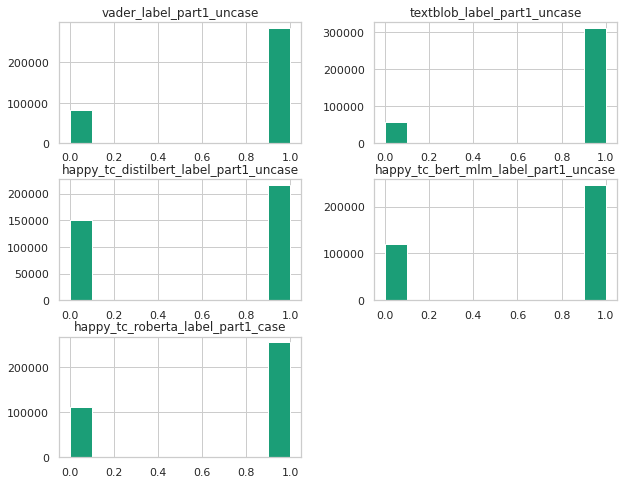

In [ ]:
pre_trained_model_data[['vader_label_part1_uncase','textblob_label_part1_uncase','happy_tc_distilbert_label_part1_uncase','happy_tc_bert_mlm_label_part1_uncase','happy_tc_roberta_label_part1_case']].hist()

### Evaluation

In [ ]:
part2_result_df = all_eva(pre_trained_model_data,pred_cols=['vader_label_part1_uncase','textblob_label_part1_uncase','happy_tc_distilbert_label_part1_uncase','happy_tc_bert_mlm_label_part1_uncase','happy_tc_roberta_label_part1_case'])


In [ ]:
pd.concat([part1_result_df,part2_result_df])

Model  Accuracy  precision    recall  \
0                      log_reg_pred_label  0.840058   0.871756  0.894446   
1                           rf_pred_label  0.678960   0.677520  0.999972   
2                          svc_pred_label  0.839916   0.873167  0.892260   
3                           nn_pred_label  0.897108   0.915157  0.934043   
0                vader_label_part1_uncase  0.861360   0.845025  0.972869   
1             textblob_label_part1_uncase  0.799695   0.780822  0.977371   
2  happy_tc_distilbert_label_part1_uncase  0.829052   0.927850  0.809492   
3    happy_tc_bert_mlm_label_part1_uncase  0.886536   0.918846  0.912355   
4       happy_tc_roberta_label_part1_case  0.929957   0.934621  0.963554   

   f1_score   AUC_ROC  
0  0.882955  0.810907  
1  0.807754  0.506906  
2  0.882610  0.811861  
3  0.924504  0.877312  
0  0.904452  0.801595  
1  0.868110  0.704466  
2  0.864640  0.839535  
3  0.915589  0.872698  
4  0.948867  0.911949

We can see our best model on this labelled dataset is: 

happy_tc_roberta

## Extra datasets

### Reddit data

Credits to: https://medium.com/@suhdong21/sentiment-analysis-of-reddit-comments-on-russia-ukraine-war-with-python-a3632994942b

output: reddit_data [dataframe]



#### Scraping (Skipped)

Demonstration, skip at actual runs


Used reddit account:

**Email:**

mie1628_g7@beeble.com

88BcQny5eUUDx43

Recovery key

jgr2-d4Jq-pD4P-DMLr-HFB4-mqdp-TLBB-T2hM

**Reddit account:**

mie1628_g7@beeble.com

1624_g7

y5eUUDx4388BcQn

client_id

a1FL2w9QvQjcKTsXlbzZrA

client_secret

ugz1tZXpMpY7RJJg_2TO84az90xAOg

In [ ]:
#!pip install praw

In [ ]:
# https://www.reddit.com/r/redditdev/comments/bd863h/praw_on_colab/
# Need to make praw.ini in the VM local config
# Get the file in share_folder/config/praw.ini
# Upload it to local VM current folder then
# !cp {project_path+"/config/praw.ini"} $HOME/.config

In [ ]:
"""

nltk.download('vader_lexicon')
nltk.download('punkt')
nltk.download('stopwords')

# Python Reddit API wrapper 
import praw 

# Scrapping from one post 
# https://www.reddit.com/r/news/comments/t003vl/russia_declares_war_on_ukraine_reports_of/
reddit = praw.Reddit(user_agent='1624_g7',
                client_id='a1FL2w9QvQjcKTsXlbzZrA',
                client_secret='ugz1tZXpMpY7RJJg_2TO84az90xAOg',                  
                check_for_async=False)

submission = reddit.submission("t003vl")

comments = []

submission.comments.replace_more(limit=0)
for top_level_comment in submission.comments:
    comments.append(top_level_comment.body)
reddit_data= pd.DataFrame({"comment" : comments})
reddit_data.head()

"""

'\n\nnltk.download(\'vader_lexicon\')\nnltk.download(\'punkt\')\nnltk.download(\'stopwords\')\n\n# Python Reddit API wrapper \nimport praw \n\n# Scrapping from one post \n# https://www.reddit.com/r/news/comments/t003vl/russia_declares_war_on_ukraine_reports_of/\nreddit = praw.Reddit(user_agent=\'1624_g7\',\n                client_id=\'a1FL2w9QvQjcKTsXlbzZrA\',\n                client_secret=\'ugz1tZXpMpY7RJJg_2TO84az90xAOg\',                  \n                check_for_async=False)\n\nsubmission = reddit.submission("t003vl")\n\ncomments = []\n\nsubmission.comments.replace_more(limit=0)\nfor top_level_comment in submission.comments:\n    comments.append(top_level_comment.body)\nreddit_data= pd.DataFrame({"comment" : comments})\nreddit_data.head()\n\n'

In [ ]:
# reddit_data.to_csv(project_path+'/data/part_2/reddit_news_t003vl.csv', encoding='utf-8', index=False)
# Then save to share_folder/data/

#### Or load data directly from a saved .csv file

In [ ]:
# If loaded from csv
reddit_data = pd.read_csv(project_path+'/data/part_2/reddit_news_t003vl.csv', low_memory=False)

In [ ]:
# Check for Nans
reddit_data.isna().sum().sort_values(ascending=False)

comment    0
dtype: int64

In [ ]:
# For uncased models and part 1 models
reddit_data_proc = fe_pipeline(reddit_data,"comment","uncase")
# for case models 
reddit_data_proc = fe_pipeline(reddit_data_proc,"comment","case")

reddit_data_proc.head()

comment  \
0  The comments in this thread are sorted by new due to the rapid developments occurring in Ukraine right now. You can view the comments sorted by best [here.](https://www.reddit.com/r/news/comments/t003vl/russia_declares_war_on_ukraine_reports_of/?sort=confidence)   
1                                                                                                                                                                      Sad day for humanity, there are no good outcomes. Just waste, distraction, destruction, and death.   
2                                                                                                                                                                                                                                                               [removed]   
3                                                                                        Explosions were reported near Kyiv.... \n\nhttps://news.sky.com/story/explosions-reported-near-kyiv-after-putin-authorises-military-operation-in-ukraine-ukraine-latest-12541713   
4                                                                                                                                                                           Holy shit, we’re about to watch this unfold live online and not be able to do a single thing.   

                                                                                     comment_uncase  \
0  comment thread sorted new due rapid development occurring ukraine right view comment sorted best   
1                                 sad day humanity good outcome waste distraction destruction death   
2                                                                                           removed   
3                                                                      explosion reported near kyiv   
4                                              holy shit watch unfold live online able single thing   

   comment_uncase_count  \
0                    14   
1                     9   
2                     1   
3                     4   
4                     9   

                                                                                       comment_case  \
0  comment thread sorted new due rapid development occurring Ukraine right view comment sorted best   
1                                 Sad day humanity good outcome waste distraction destruction death   
2                                                                                           removed   
3                                                                      Explosion reported near Kyiv   
4                                              Holy shit watch unfold live online able single thing   

   comment_case_count  
0                  14  
1                   9  
2                   1  
3                   4  
4                   9

#### Further feature engineering

comment  \
14   Ukrainian President Zelensky's speech before the attack:\n\n"I have initiated a call today with the president of the Russian Federation. The result - silence. Although silence should be in Donbass.\n\nThat is why today, I want to come with an appeal to all citizens of Russia. Not as President. I am appealing to the people of Russia as a citizen of Ukraine. We share more than two thousand kilometres of border. Around it, today, is your army: almost 200,000 soldiers; thousands of military units. Your leadership has approved their movement towards us. Towards the territory of another country. This step can become the start of a big war on the European continent. The whole world is talking about what can happen any day now. A reason can appear at any moment. Any provocation. Any spark. A spark that has the potential of burning everything down.\n\nYou are told that this flame will bring freedom to the people of Ukraine. But the people of Ukraine are free. They remember their past, and are building their own future. They are building it, not destroying it, as you are told everyday on TV. Ukraine in your news and Ukraine in reality are two completely different countries. The most important difference is that ours is real.\n\nYou are being told that we are nazis. But how can a nation be called nazist after sacrificing more than 8 million lives to eradicate nazism. How can I be a nazi, when my grandfather has survived the whole war as part of the Soviet infantry, and has died a colonel in an independent Ukraine. You are told that we hate Russian culture. But how can a culture be hated? Any culture. Neighbours are always enriching each other culturally. Yet, that does not make them one entity, and does not separate people into “us” and “them”. We are different, but that is not a reason to be enemies. We want to build our own history. Peacefully, calmly, and truthfully.\n\nYou are told that I am ordering to attack the Donbass. To shoot. To bomb without questions. Although there are questions: To shoot at whom? To bomb what?\n\nDonetsk? To which I have been dozens of times. I have seen their faces and eyes.\n\nArtema street? On which I have been on many walks with my friends in the past.\n\nDonbass arena? Where I have been rooting with the locals for our boys during the Euros.\n\nShcherbakova Park? In which we were drinking together after our team has lost\n\nLugansk? The home of my best friend’s mom. The place where my best friend’s father is buried.\n\nNote that I am now speaking in Russian, yet no one in Russia understands what these names, streets, and events mean. This is all foreign to you. Unknown. This is our land. This is our history. What are you going to fight for? And against whom?\n\nMany of you have visited Ukraine in the past. Many of you have relatives here. Some of you studied in our universities. Befriended Ukrainian people. You’re familiar with our character, with our people, our principles. You know what we cherish the most. Look inside you, listen to the voice of reason, of common sense. Hear our voices. The people of Ukraine want peace. Ukrainian authorities want peace. We want it, and we make it. We do everything in our powers. We are not alone. It’s true, Ukraine is supported by many countries. Why? Because we are not talking about peace at any cost. We are talking about peace, and about principles, justice. About everyone’s right to define their own future, of safety, and everyone’s right to live without threat. All this is important to us. All this is important for peace. I know for sure that this is also important for you. We know for sure that we don’t want war. Neither cold, hot, or hybrid.\n\nBut, if we are threatened; If someone is trying to take away our country, our freedom, our lives. The lives of our children. We are going to defend ourselves. Not attack. Defend. By attacking us, you are going to see our faces. Not backs. Our faces.\n\nWar is a big distress, and it has a big price - in al

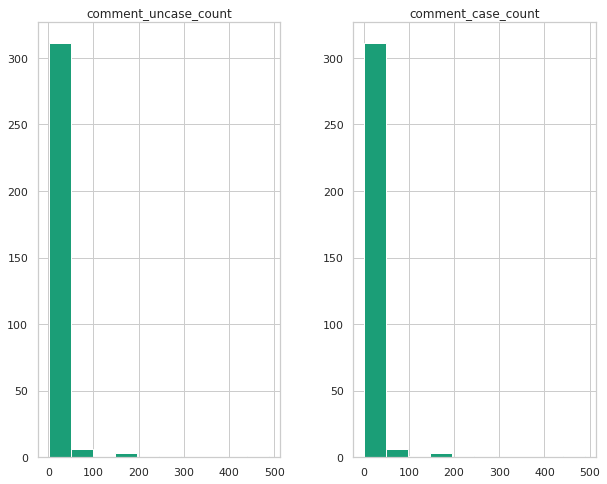

In [ ]:
reddit_data_proc[['comment_uncase_count','comment_case_count']].hist()

# Some twitter pretrained-models have max sequence length of 128
reddit_data_proc.query('comment_uncase_count > 128 or comment_case_count>128')

# We either trim those, 
# Or if we only have a few number of samples, we can break them into parts and caculate average score on all parts.
# I will apply trimming at the model process

#### Run models

In [ ]:
# Uncomment to run
# Or load saved results in next section
"""
# Pretrained models
reddit_model_data = run_all_pre_trained_models(reddit_data_proc,"reddit","comment")

# Best part1 model
reddit_model_data = run_part1_model(reddit_model_data,"reddit","comment")

reddit_model_data.head()
"""

'\n# Pretrained models\nreddit_model_data = run_all_pre_trained_models(reddit_data_proc,"reddit","comment")\n\n# Best part1 model\nreddit_model_data = run_part1_model(reddit_model_data,"reddit","comment")\n\nreddit_model_data.head()\n'

In [ ]:
#reddit_model_data.to_csv(project_path+'data/part_2/reddit_model_data_results.csv', encoding='utf-8', index=False)

#### Result visualization and evaluation

In [ ]:
reddit_model_data = pd.read_csv(project_path+'data/part_2/reddit_model_data_results.csv')

##### Positive, negative, or neutral?

In [ ]:
df_2labels = reddit_model_data[['part1_best_model_MLP_label_reddit_uncase','vader_label_reddit_uncase','textblob_label_reddit_uncase','happy_tc_distilbert_label_reddit_uncase','happy_tc_bert_mlm_label_reddit_uncase','happy_tc_roberta_label_reddit_case']]

df_2labels.apply(pd.value_counts)

part1_best_model_MLP_label_reddit_uncase  vader_label_reddit_uncase  \
0                                       266                        177   
1                                        57                        146   

   textblob_label_reddit_uncase  happy_tc_distilbert_label_reddit_uncase  \
0                           122                                      258   
1                           201                                       65   

   happy_tc_bert_mlm_label_reddit_uncase  happy_tc_roberta_label_reddit_case  
0                                    263                                 281  
1                                     60                                  42

/usr/local/lib/python3.8/dist-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  plot_obj.generate()


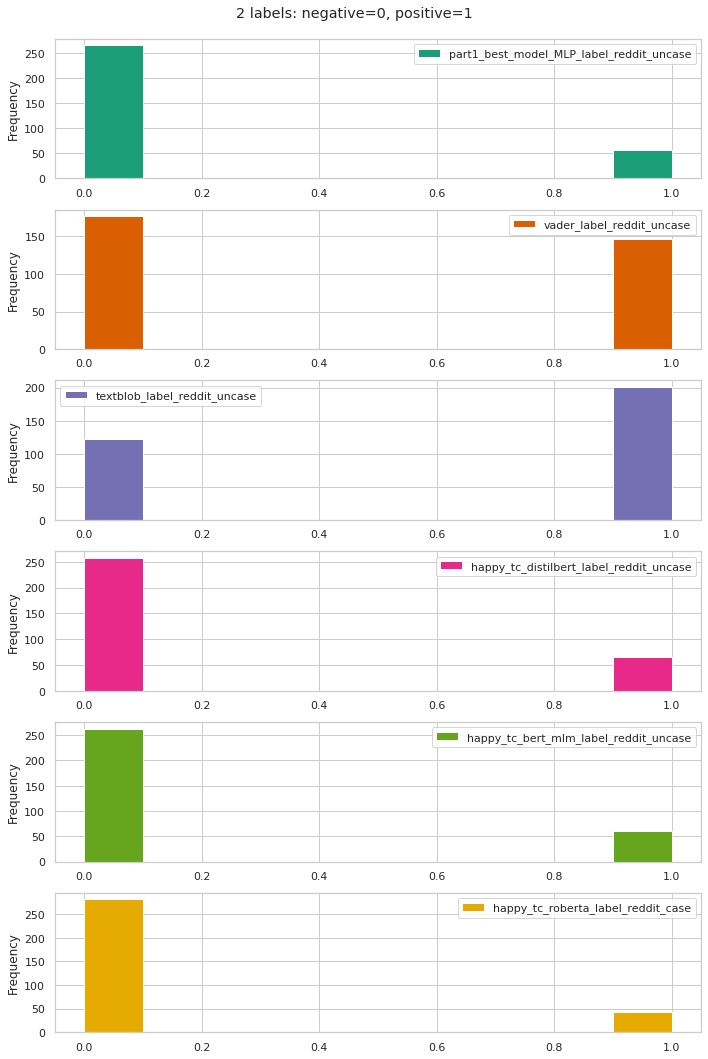

In [ ]:
# 2 labels
fig = plt.figure(figsize = (10,15))
ax = fig.gca()
reddit_model_data[['part1_best_model_MLP_label_reddit_uncase','vader_label_reddit_uncase','textblob_label_reddit_uncase','happy_tc_distilbert_label_reddit_uncase','happy_tc_bert_mlm_label_reddit_uncase','happy_tc_roberta_label_reddit_case']].plot(kind="hist",subplots=True, title="2 labels: negative=0, positive=1",ax=ax)
fig.tight_layout()
fig.subplots_adjust(top=0.95)

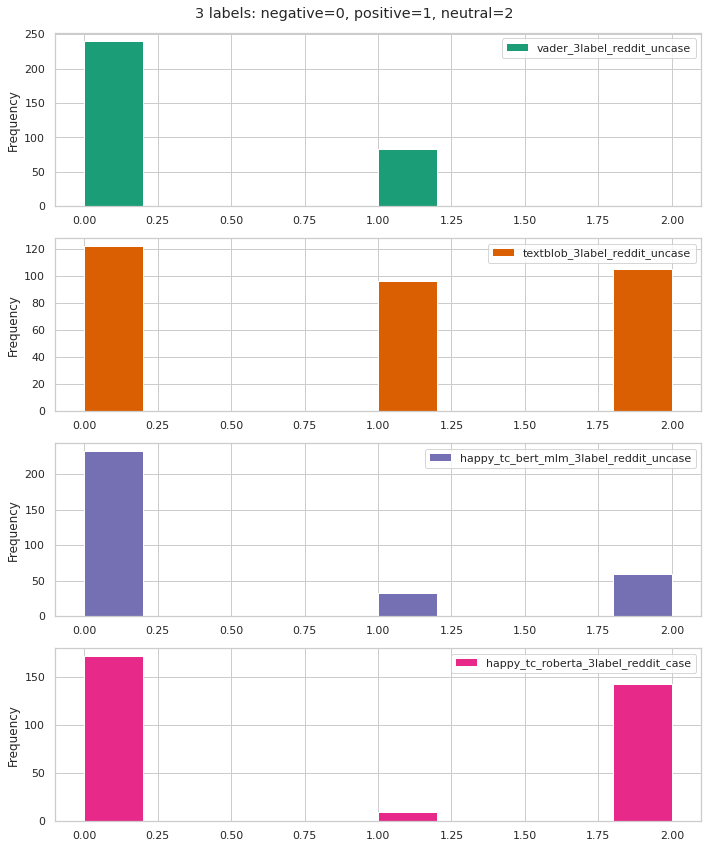

In [ ]:
# 3 labels
fig = plt.figure(figsize = (10,12))
ax = fig.gca()
reddit_model_data[['vader_3label_reddit_uncase','textblob_3label_reddit_uncase','happy_tc_bert_mlm_3label_reddit_uncase','happy_tc_roberta_3label_reddit_case']].plot(kind="hist",subplots=True, title="3 labels: negative=0, positive=1, neutral=2",ax=ax)
fig.tight_layout()
fig.subplots_adjust(top=0.95)

##### Evaluation

We can see that textblob have a very unusual distribution. This is because there are many samples with a neutral score of 0. Where in the 2 labels scenario they are all classified as positive labels.

In [ ]:
reddit_model_data['textblob_scores_reddit_uncase'].value_counts()

 0.000000    105
-0.400000     13
-0.200000      9
 0.500000      8
 0.200000      8
            ... 
-0.054762      1
-0.120833      1
-0.428571      1
 0.234091      1
-0.147500      1
Name: textblob_scores_reddit_uncase, Length: 136, dtype: int64

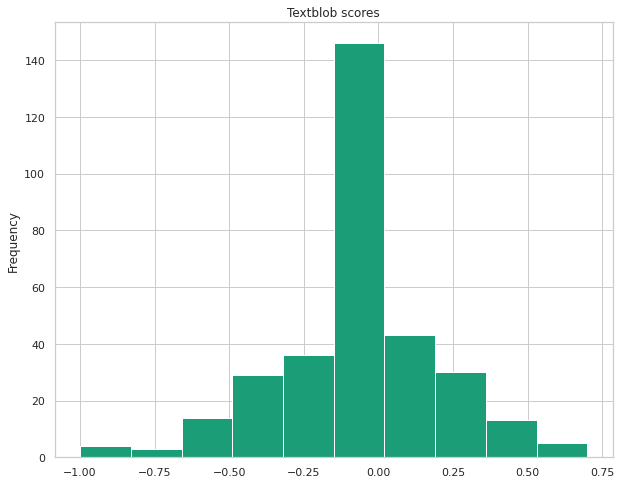

In [ ]:
reddit_model_data['textblob_scores_reddit_uncase'].plot(kind="hist", title="Textblob scores")

Overall, the happy tranformer models holds a consistent analysis results. And we will continue use the best performaning model [happy_tc_roberta] from part 2 model comparison as our final decision model.

##### Wordclouds

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


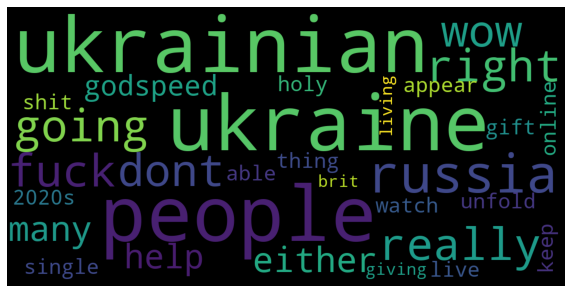

In [ ]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

# plot wordcloud for positive comments
stopwords_set = set(stop_words)
wordcloud = WordCloud(background_color='black',
                     stopwords = stopwords_set,
                      max_words = 30,
                      max_font_size = 55,
                      scale = 3,
                      random_state=42
                     ).generate(str(reddit_model_data.loc[reddit_model_data["happy_tc_roberta_3label_reddit_case"]==1]["comment_uncase"]))

print(wordcloud)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

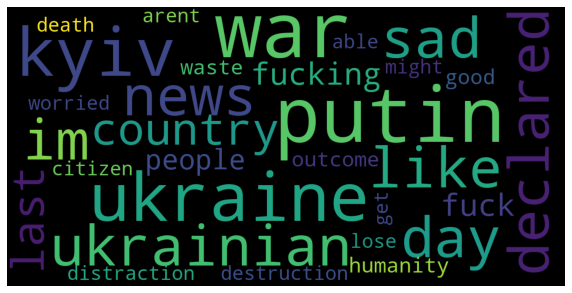

In [ ]:
# plot wordcloud for positive comments
stopwords_set = set(stop_words)
wordcloud = WordCloud(background_color='black',
                     stopwords = stopwords_set,
                      max_words = 30,
                      max_font_size = 55,
                      scale = 3,
                      random_state=42
                     ).generate(str(reddit_model_data.loc[reddit_model_data["happy_tc_roberta_3label_reddit_case"]==0]["comment_uncase"]))

print(wordcloud)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

##### Actual comments

In [ ]:
# Positive comments, we actually have so few of them so we print them all
pd.set_option('display.max_colwidth', None)
reddit_model_data.loc[reddit_model_data["happy_tc_roberta_3label_reddit_case"]==1]["comment"]

4                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        Holy shit, we’re about to watch this unfold live online and not be able to do a single thing.
51                                                                                                                                                                                                                               

In [ ]:
# Negative comments, we actually have so few of them so we print them all
reddit_model_data.loc[reddit_model_data["happy_tc_roberta_3label_reddit_case"]==0][:8]["comment"]

1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        Sad day for humanity, there are no good outcomes. Just waste, distraction, destruction, and death.
6                                                                                                                                                                                                                                                                                                                                                                                                                           

In [ ]:
pd.reset_option('display.max_colwidth')

##### Insights

We can see that most of the positive comments are praying for Ukraine. Some of the positive comments are actually being sarcastic on Putin and Russia, but falsely classified as positive comments by our model.

For the negative comments, most of them consists of accusing Putin and Russia or express sadness on hearing about the war.

We now understand, for this case, to achieve high number of positive replies might be our goal, as sadness also contains powers.

We need to go beyond sentiment analysis, and possibly identify the factors and topics behind the attitude in order to come up with a better analysis.

### Twitter dataset (find our own)

Credits to: https://www.kaggle.com/datasets/bwandowando/ukraine-russian-crisis-twitter-dataset-1-2-m-rows

#### Load data

In [ ]:
tw_raw_data = pd.read_csv(project_path+'/data/part_2/1030_UkraineCombinedTweetsDeduped.csv', low_memory=False)

# preview
tw_raw_data.head(3)

Unnamed: 0               userid      username  \
0      179808  1564387076560355331  tropical_spy   
1      179809            610182747      Naurplay   
2      179810  1354780065293328386      IrkaLive   

                                            acctdesc  \
0  Definitely an alphabet funded psyop. \nThere i...   
1                              🐈 Коти, ☕ Кава, 🐉 D&D   
2  Refugee from USSR's official genocidal “anti-Z...   

                       location  following  followers  totaltweets  \
0  Probably bushes or something       1215        800         1236   
1             Mykolaiv, Ukraine         73       3621         5372   
2                      New York        189        553        36892   

         usercreatedts              tweetid  ... original_tweet_userid  \
0  2022-08-29 22:58:55  1586508177801347072  ...                     0   
1  2012-06-16 16:17:50  1586508178606346240  ...                     0   
2  2021-01-28 13:15:30  1586508179147722752  ...                     0   

   original_tweet_username in_reply_to_status_id  in_reply_to_user_id  \
0                      NaN   1586506673518018560  1483255226261979136   
1                      NaN   1586498477965860864           1722806024   
2                      NaN                     0                    0   

  in_reply_to_screen_name is_quote_status     quoted_status_id  \
0          Im_vengeance97           False                    0   
1           wartranslated           False                    0   
2                     NaN            True  1586465661504479232   

   quoted_status_userid  quoted_status_username                 extractedts  
0                     0                     NaN  2022-10-30 14:00:16.978113  
1                     0                     NaN  2022-10-30 14:56:57.449608  
2   1515681697181974528             ChaimSmierc  2022-10-30 07:33:28.326704  

[3 rows x 29 columns]

#### Imports

In [ ]:
# utilities
import re
import pickle
import numpy as np
import pandas as pd

# plotting
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.figure_factory as ff


# nltk
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# important libraries
from bokeh.plotting import figure
from bokeh.io import output_file, show, output_notebook
from collections import Counter
import spacy
from spacy.util import compounding
from spacy.util import minibatch
from spacy import displacy
import gc
import os

# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report
sns.set(rc={'figure.figsize': (20,10)})

from sklearn.model_selection import train_test_split    
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
import numpy as np
import pandas as pd
import scipy
import time

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### EDA & Dataset Visualizations:

In [ ]:
tw_raw_data["totaltweets"].value_counts()

334075     129
7145       109
334131      91
334074      70
11975       58
          ... 
2696         1
1111184      1
6535         1
340076       1
29257        1
Name: totaltweets, Length: 14603, dtype: int64

In [ ]:
tw_raw_data.shape

(36237, 29)

In [ ]:
tw_raw_data.columns

Index(['Unnamed: 0', 'userid', 'username', 'acctdesc', 'location', 'following',
       'followers', 'totaltweets', 'usercreatedts', 'tweetid',
       'tweetcreatedts', 'retweetcount', 'text', 'hashtags', 'language',
       'coordinates', 'favorite_count', 'is_retweet', 'original_tweet_id',
       'original_tweet_userid', 'original_tweet_username',
       'in_reply_to_status_id', 'in_reply_to_user_id',
       'in_reply_to_screen_name', 'is_quote_status', 'quoted_status_id',
       'quoted_status_userid', 'quoted_status_username', 'extractedts'],
      dtype='object')

In [ ]:
tw_raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36237 entries, 0 to 36236
Data columns (total 29 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Unnamed: 0               36237 non-null  int64  
 1   userid                   36237 non-null  int64  
 2   username                 36237 non-null  object 
 3   acctdesc                 32294 non-null  object 
 4   location                 23853 non-null  object 
 5   following                36237 non-null  int64  
 6   followers                36237 non-null  int64  
 7   totaltweets              36237 non-null  int64  
 8   usercreatedts            36237 non-null  object 
 9   tweetid                  36237 non-null  int64  
 10  tweetcreatedts           36237 non-null  object 
 11  retweetcount             36237 non-null  int64  
 12  text                     36237 non-null  object 
 13  hashtags                 36237 non-null  object 
 14  language              

In [ ]:
tw_raw_data.isna().sum().sort_values(ascending=False)


original_tweet_username    36237
coordinates                36060
quoted_status_username     30344
in_reply_to_screen_name    25030
location                   12384
acctdesc                    3943
Unnamed: 0                     0
favorite_count                 0
quoted_status_userid           0
quoted_status_id               0
is_quote_status                0
in_reply_to_user_id            0
in_reply_to_status_id          0
original_tweet_userid          0
original_tweet_id              0
is_retweet                     0
language                       0
userid                         0
hashtags                       0
text                           0
retweetcount                   0
tweetcreatedts                 0
tweetid                        0
usercreatedts                  0
totaltweets                    0
followers                      0
following                      0
username                       0
extractedts                    0
dtype: int64

In [ ]:
df = tw_raw_data.copy()

In [ ]:
df = df.dropna(subset=['location'])

In [ ]:
df.language.value_counts()

en     12238
und     2574
uk      2334
de      1571
es       955
ru       943
fr       881
it       733
ja       218
tr       146
hi       136
pl       134
nl       125
fi        75
el        73
pt        67
ar        64
sv        64
in        59
cs        56
ro        46
zh        45
da        43
et        35
vi        31
ca        24
ur        21
sr        18
fa        14
bn        14
bg        14
sl        10
ta         9
no         9
ht         8
iw         8
tl         7
te         7
mr         6
cy         5
ml         4
gu         4
th         3
lt         3
lv         3
hu         3
eu         2
ko         2
kn         2
is         2
my         1
or         1
ne         1
si         1
pa         1
Name: language, dtype: int64

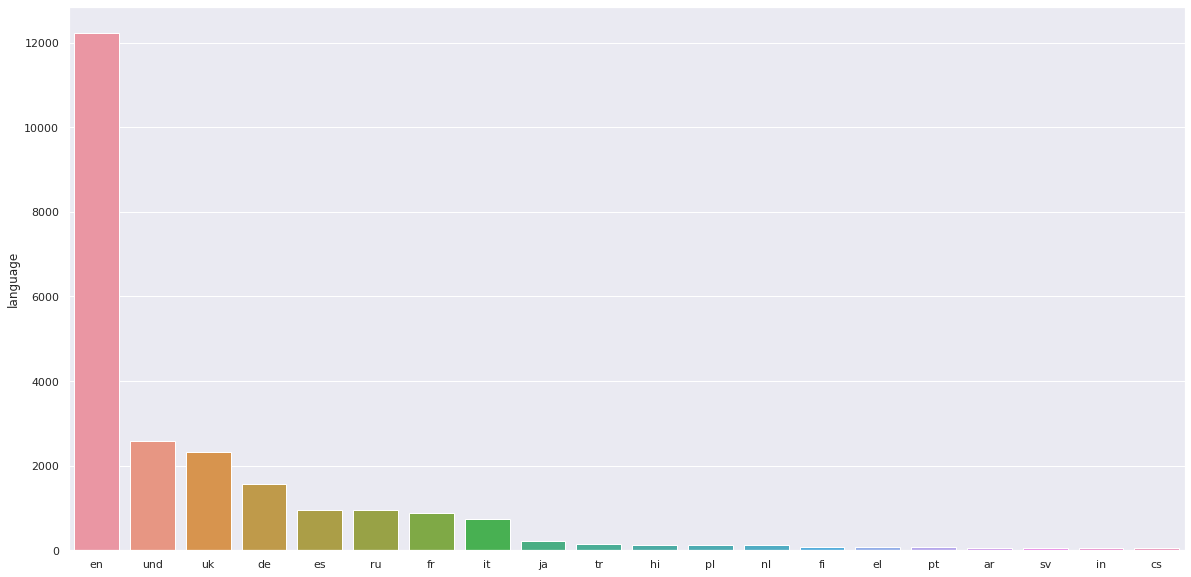

In [ ]:
sns.barplot(x= df.language.value_counts()[:20].index,y=df.language.value_counts()[:20])

In [ ]:
df.groupby('language').nunique()

Unnamed: 0  userid  username  acctdesc  location  following  \
language                                                                
ar                64      37        37        36        35         38   
bg                14       9         9         8         9          9   
bn                14      11        11        11         9         11   
ca                24      21        21        19        20         22   
cs                56      46        46        45        41         46   
cy                 5       5         5         5         5          5   
da                43      29        29        29        25         33   
de              1571     840       840       795       551        750   
el                73      20        20        20        16         27   
en             12238    5422      5423      5169      3214       2844   
es               955     474       474       450       348        499   
et                35      28        28        26        27         29   
eu                 2       2         2         1         2          2   
fa                14      12        12        12        12         12   
fi                75      50        50        50        36         55   
fr               881     535       535       504       366        500   
gu                 4       4         4         4         3          4   
hi               136      44        44        42        23         43   
ht                 8       8         8         8         8          8   
hu                 3       3         3         2         3          3   
in                59      50        50        49        42         50   
is                 2       2         2         2         2          2   
it               733     409       409       389       263        412   
iw                 8       2         2         2         2          2   
ja               218      73        73        72        61         79   
kn                 2       2         2         2         1          2   
ko                 2       2         2         2         2          2   
lt                 3       3         3         3         3          3   
lv                 3       3         3         3         3          3   
ml                 4       4         4         4         4          4   
mr                 6       5         5         5         5          5   
my                 1       1         1         1         1          1   
ne                 1       1         1         0         1          1   
nl               125      77        77        73        63         81   
no                 9       9         9         9         9          9   
or                 1       1         1         1         1          1   
pa                 1       1         1         1         1          1   
pl               134      72        72        67        54         74   
pt                67      47        47        43        42         48   
ro                46      29        29        26        24         30   
ru               943     289       289       258       167        261   
si                 1       1         1         1         1          1   
sl                10       9         9         9         9         10   
sr                18      12        12        11        10         12   
sv                64      31        31        31        26         37   
ta                 9       9         9         9         7          9   
te                 7       5         5         5         3          5   
th                 3       3         3         3         3          3   
tl                 7       7         7         7         7          7   
tr               146      93        93        89        68         88   
uk              2334     636       636       586       252        443   
und             2574    1407      1407      1292      1009       1145   
ur                21      13        13        12         9         1

In [ ]:
# Only English
df_en = df[df.language == 'en'].drop('language', axis=1)

In [ ]:
# Sorting based on Retweet Count
sorted_tweets = df_en[['username', 'text','retweetcount','tweetid', ]].sort_values(by = 'retweetcount', ascending=False)


In [ ]:
# Printing Most Retweeted 3 tweets
most_retweeted = sorted_tweets.iloc[0]
print(most_retweeted.text); print('\n')
most_retweeted = sorted_tweets.iloc[1]
print(most_retweeted.text); print('\n')
most_retweeted = sorted_tweets.iloc[2]
print(most_retweeted.text); print('\n')


It feels so great to be back in 🇺🇦Ukraine.
It’s now grieving, it’s destitute, it’s full of blood and tears because of the enemy, but it’s still our dearest land to defend and then give it a glorious future.


Watch until end!
Those Russian troops somewhere in Kherson Oblast in this footage got under Ukrainian artillery fire and frantically tried to escape. The end of the video shows how this concluded. #Ukraine #Kherson https://t.co/UpLxWYZ7ar


From @KimDotcom - How do the #Russians know that the UK blew up #Nordstream2 with the US? "Because @trussliz used her iPhone to send a message to @SecBlinken saying “It’s done” a minute after the pipeline blew up and before anybody else knew? iCloud admin access rocks!" https://t.co/cxwEeDrpMa




In [ ]:
# Full frame of most retweeted tweets
sorted_tweets.head(5)

username                                               text  \
12041  IAPonomarenko  It feels so great to be back in 🇺🇦Ukraine.\nIt...   
10889         Tendar  Watch until end!\nThose Russian troops somewhe...   
28176     timand2037  From @KimDotcom - How do the #Russians know th...   
34216     PatronDsns  This is how Mariupol looks like now. I just ca...   
33179      UAWeapons  #Ukraine: Four Russian BMP infantry fighting v...   

       retweetcount              tweetid  
12041           923  1586666366744027136  
10889           916  1586657430947201024  
28176           808  1586792698333249536  
34216           760  1586844191745019905  
33179           671  1586833829506998272

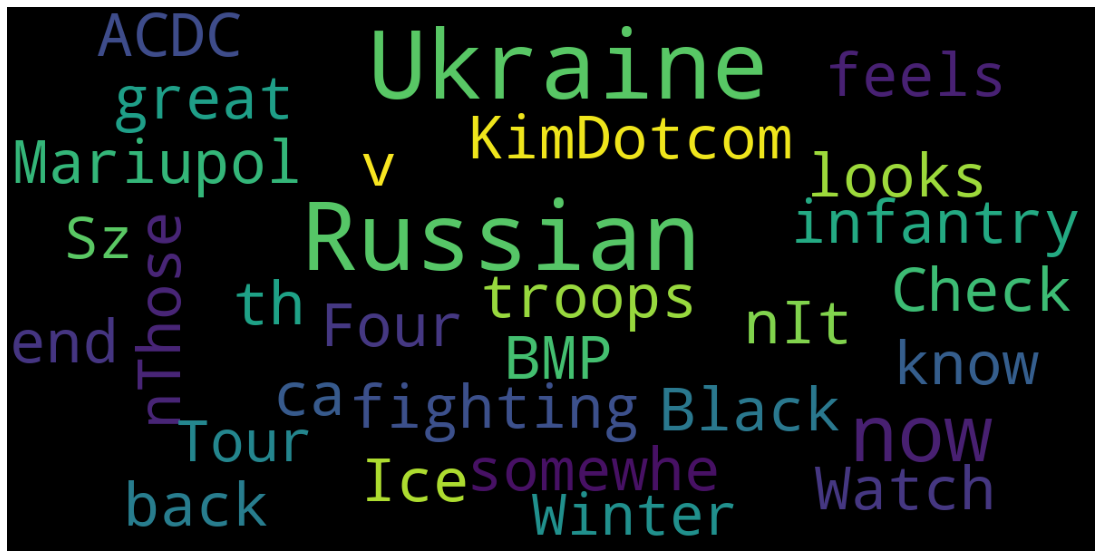

In [ ]:
# Getting word cloud based on stopwords from wordcloud library with 30 max words
stopwords_set = set(STOPWORDS)
wordcloud = WordCloud(background_color='black',
                     stopwords = stopwords_set,
                      max_words = 30,
                      max_font_size = 35,
                      scale = 3,
                      random_state=42
                     ).generate(str(sorted_tweets['text']))

print(wordcloud)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

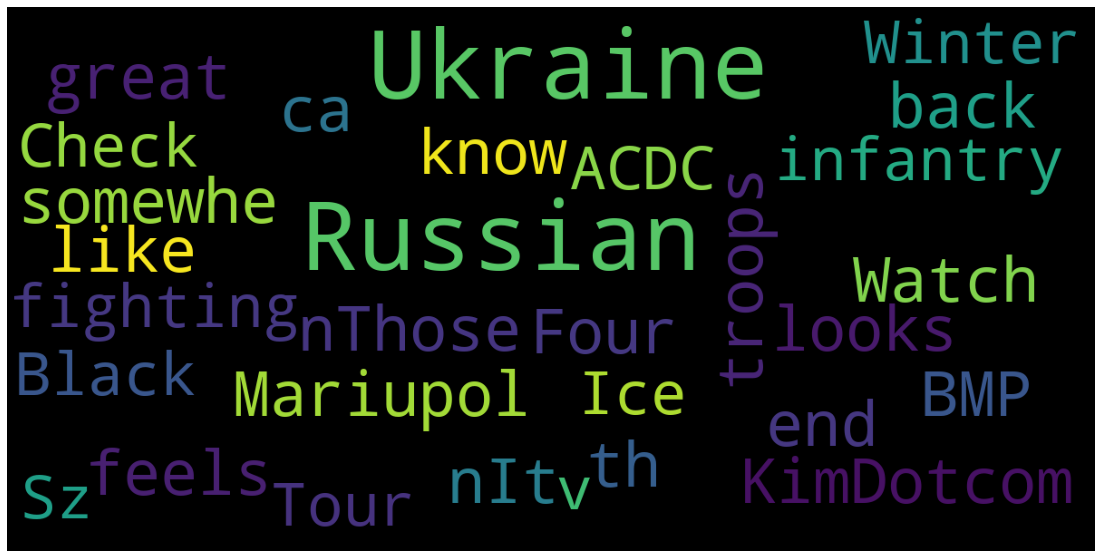

In [ ]:
# Getting word cloud based on stopwords from nltk library with 30 max words
stopwords_set = set(stopwords.words('english'))
wordcloud = WordCloud(background_color='black',
                     stopwords = stopwords_set,
                      max_words = 30,
                      max_font_size = 35,
                      scale = 3,
                      random_state=42
                     ).generate(str(sorted_tweets['text']))

print(wordcloud)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 128038 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 127754 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 127463 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 127466 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 127477 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 127481 missing from current font.
  fon

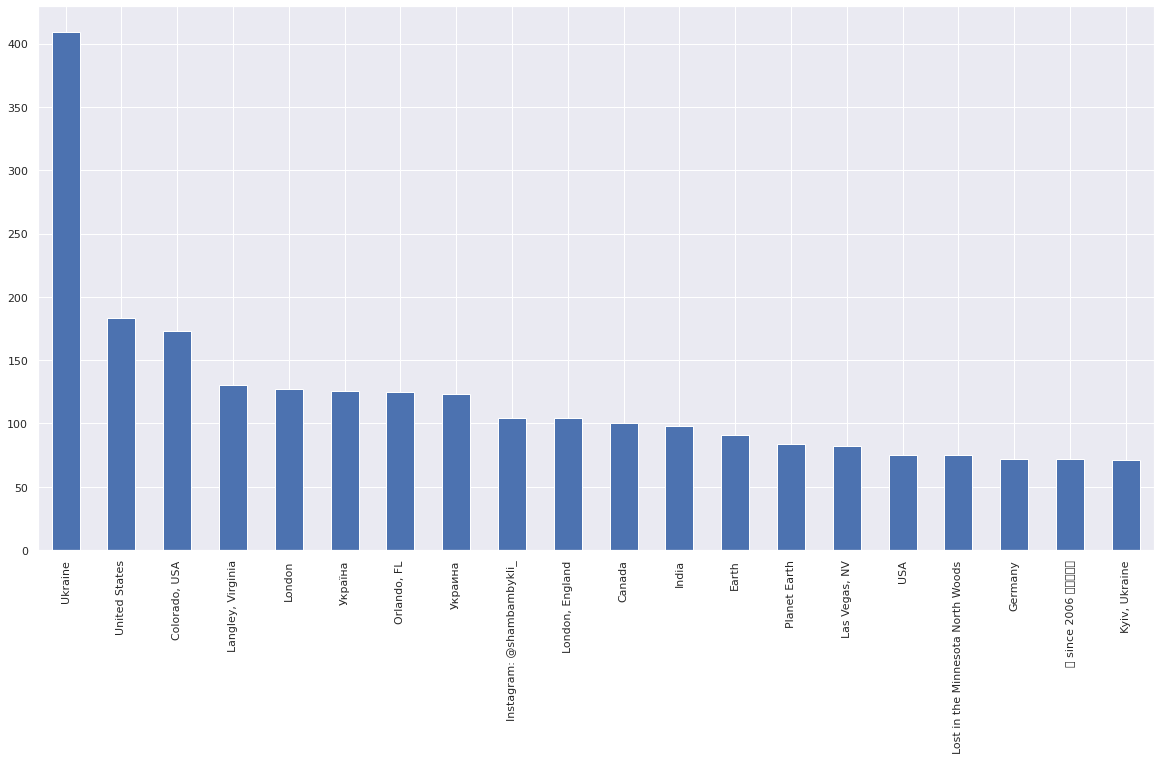

In [ ]:
# plotting tweets count based on location
df_en.location.value_counts()[:20].plot.bar()

To avoid having fake users impacting our visualizations, we want to sort by time of user creation.

In [ ]:
# Extracting time column names
time_cols = ['extractedts','tweetcreatedts','usercreatedts']
# converting usercreation date to actual date
df_en[time_cols[2]] = pd.to_datetime(df_en[time_cols[2]])


In [ ]:
# Sorting by the creation date column
sort_by_userage= df_en.sort_values(by = time_cols[2], ascending=True)
columns = df_en.columns.to_list()


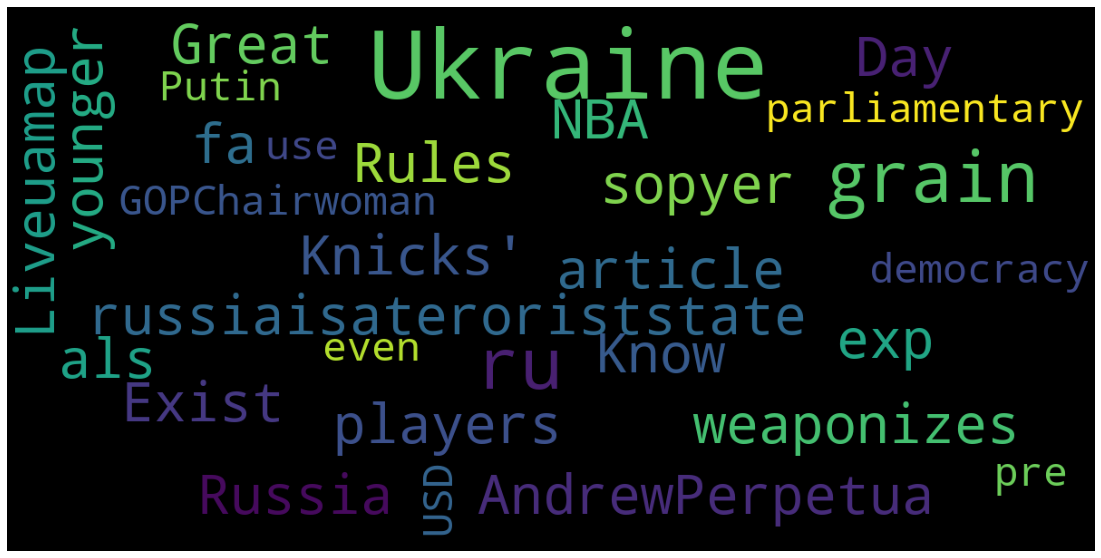

In [ ]:
# Getting word cloud based on stopwords from nltk library with 30 max words based on stable users
stopwords_set = set(stopwords.words('english'))
wordcloud = WordCloud(background_color='black',
                     stopwords = stopwords_set,
                      max_words = 30,
                      max_font_size = 35,
                      scale = 3,
                      random_state=42
                     ).generate(str(sort_by_userage.iloc[:1000,columns.index('text')]))

print(wordcloud)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

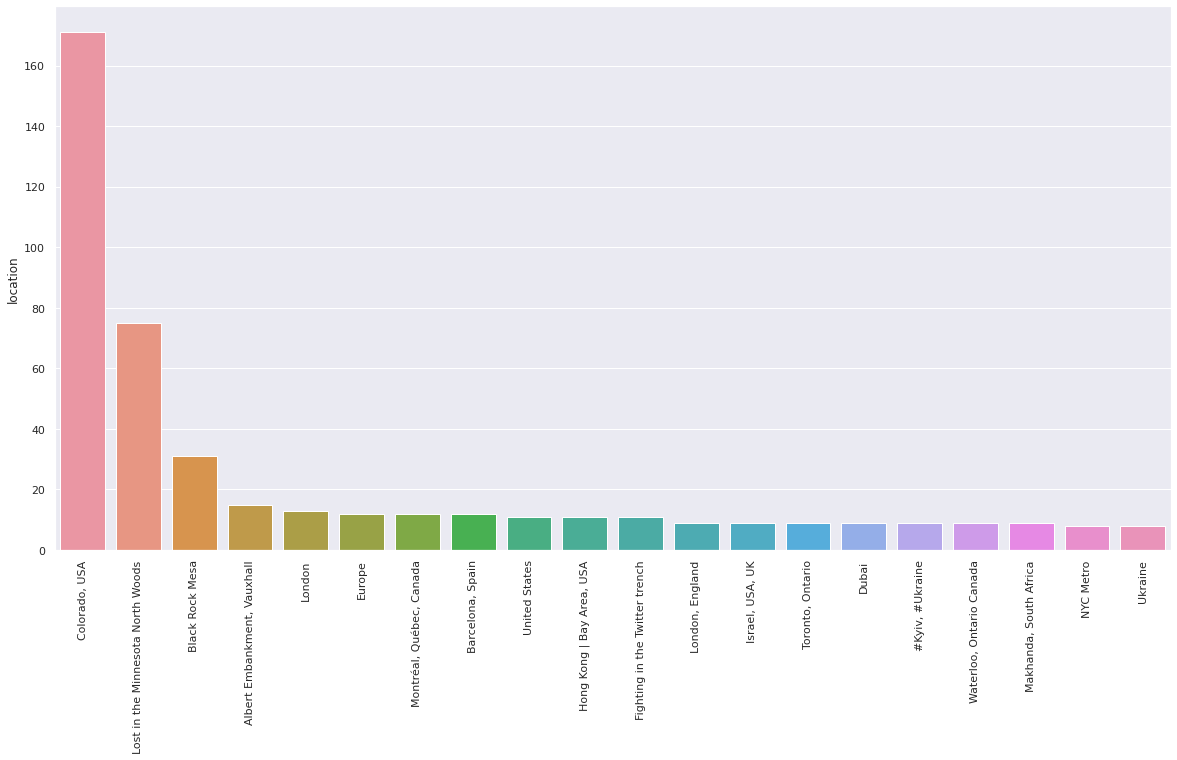

In [ ]:
## Top 1k users statistics 
sns.barplot(x = sort_by_userage.iloc[:1000,columns.index('location')].value_counts()[:20].index,
           y = sort_by_userage.iloc[:1000, columns.index('location')].value_counts()[:20])
plt.xticks(rotation = 90)
plt.show()


/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 128150 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 128150 missing from current font.
  font.set_text(s, 0, flags=flags)


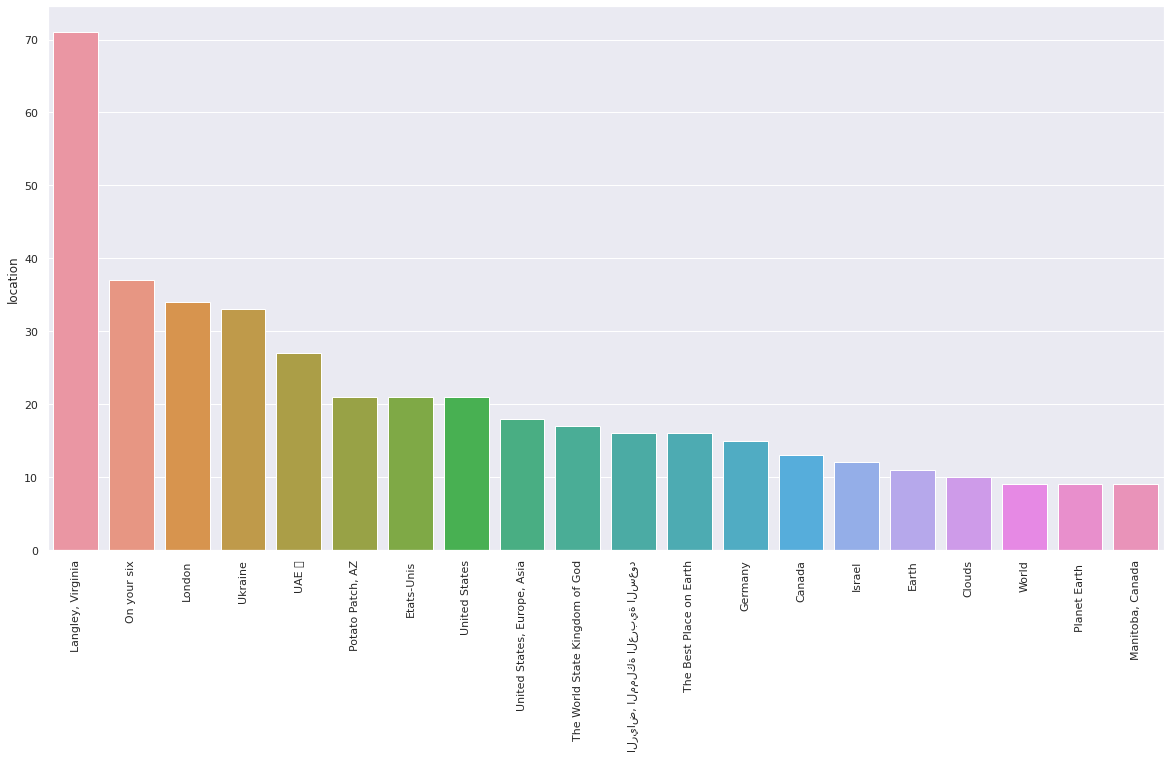

In [ ]:
# Bottom 1k users statistics
sns.barplot(x = sort_by_userage.iloc[df_en.shape[0]-1000:,
                                    columns.index('location')].value_counts()[:20].index,
           y= sort_by_userage.iloc[df_en.shape[0]-1000:,
                                  columns.index('location')].value_counts()[:20])
plt.xticks(rotation = 90)
plt.show()

The previous visualizations could be used in different ways based on the application -> to be cleaned later
Also, we can add hashtag analysis later if we want. 


#### Run models

In [ ]:
# For uncased models and part 1 models
twday_data_proc = fe_pipeline(df_en,"text","uncase")
# for case models 
twday_data_proc = fe_pipeline(twday_data_proc,"text","case")

twday_data_proc.head()

Unnamed: 0               userid         username  \
0       179808  1564387076560355331     tropical_spy   
4       179812  1569297538502594561   iamthinkernice   
6       179814             42290868   LaydenRobinson   
8       179816            254948188  intpolicydigest   
10      179818  1387782816725835776  JamesWe42087922   

                                             acctdesc  \
0   Definitely an alphabet funded psyop. \nThere i...   
4                          Crypto Lover\nLove Ukraine   
6   "Don't ever be ashamed of your story.  Somewhe...   
8   User generated #news and analysis. Follow us o...   
10  Music Excentrist USA...\nKnight.Eucli+Chapel:S...   

                        location  following  followers  totaltweets  \
0   Probably bushes or something       1215        800         1236   
4                        Ukraine          0          6          258   
6                  San Diego, CA      95326      86704       864639   
8        Virginia, United States       4744      23109        45512   
10            California, U.S.A.         12         91         8712   

         usercreatedts              tweetid  ... in_reply_to_screen_name  \
0  2022-08-29 22:58:55  1586508177801347072  ...          Im_vengeance97   
4  2022-09-12 12:11:19  1586508186336362496  ...                     NaN   
6  2009-05-24 22:04:27  1586508213926518784  ...                     NaN   
8  2011-02-20 10:18:26  1586508246407315458  ...                     NaN   
10 2021-04-29 14:56:32  1586508279047368704  ...                     NaN   

    is_quote_status quoted_status_id quoted_status_userid  \
0             False                0                    0   
4             False                0                    0   
6             False                0                    0   
8             False                0                    0   
10            False                0                    0   

   quoted_status_username                 extractedts  \
0                     NaN  2022-10-30 14:00:16.978113   
4                     NaN  2022-10-30 09:33:43.915146   
6                     NaN  2022-10-30 06:37:39.170008   
8                     NaN  2022-10-30 09:18:43.111449   
10                    NaN  2022-10-30 07:33:28.296690   

                                          text_uncase  text_uncase_count  \
0   im_vengeance97 itll okay illegitimate usurper ...                 15   
4   ukraine war map oct 29 kherson donetsk kharkiv...                 23   
6   hail usyk klitschkobrothers stepping leaving f...                 17   
8   russia made nato relevant time new treaty nato...                 13   
10  bitcoin international king russia bitcoin fern...                 16   

                                            text_case  text_case_count  
0   im_vengeance97 Itll okay Illegitimate usurper ...               15  
4   Ukraine war map Oct 29 Kherson Donetsk Kharkiv...               23  
6   Hail Usyk klitschkobrothers stepping leaving f...               17  
8   Russia Made nato Relevant Time New Treaty nato...               13  
10  Bitcoin International King Russia Bitcoin Fern...               16  

[5 rows x 32 columns]

In [ ]:
# Uncomment to run
# Or load saved results in next section
"""
# English tweets only in df_en

# Pretrained models
tw_model_data = run_all_pre_trained_models(twday_data_proc,"tw","text")

# Best part1 model
tw_model_data = run_part1_model(twday_data_proc,"tw","text")

tw_model_data.head()
"""

'\n# English tweets only in df_en\n\n# Pretrained models\ntw_model_data = run_all_pre_trained_models(twday_data_proc,"tw","text")\n\n# Best part1 model\ntw_model_data = run_part1_model(twday_data_proc,"tw","text")\n\ntw_model_data.head()\n'

In [ ]:
#tw_model_data.to_csv(project_path+'data/part_2/tw_model_data_results.csv', encoding='utf-8', index=False)

#### Result visualization and evaluation

In [ ]:
tw_model_data = pd.read_csv(project_path+'data/part_2/tw_model_data_results.csv')

##### Positive, negative, or neutral?

In [ ]:
tw_df_2labels = tw_model_data[['part1_best_model_MLP_label_tw_uncase','vader_label_tw_uncase','textblob_label_tw_uncase','happy_tc_distilbert_label_tw_uncase','happy_tc_bert_mlm_label_tw_uncase','happy_tc_roberta_label_tw_case']]

tw_df_2labels.apply(pd.value_counts)

part1_best_model_MLP_label_tw_uncase  vader_label_tw_uncase  \
0                                  8001                   5374   
1                                  4237                   6864   

   textblob_label_tw_uncase  happy_tc_distilbert_label_tw_uncase  \
0                      2948                                 9856   
1                      9290                                 2382   

   happy_tc_bert_mlm_label_tw_uncase  happy_tc_roberta_label_tw_case  
0                               8237                            9394  
1                               4001                            2844

/usr/local/lib/python3.8/dist-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  plot_obj.generate()


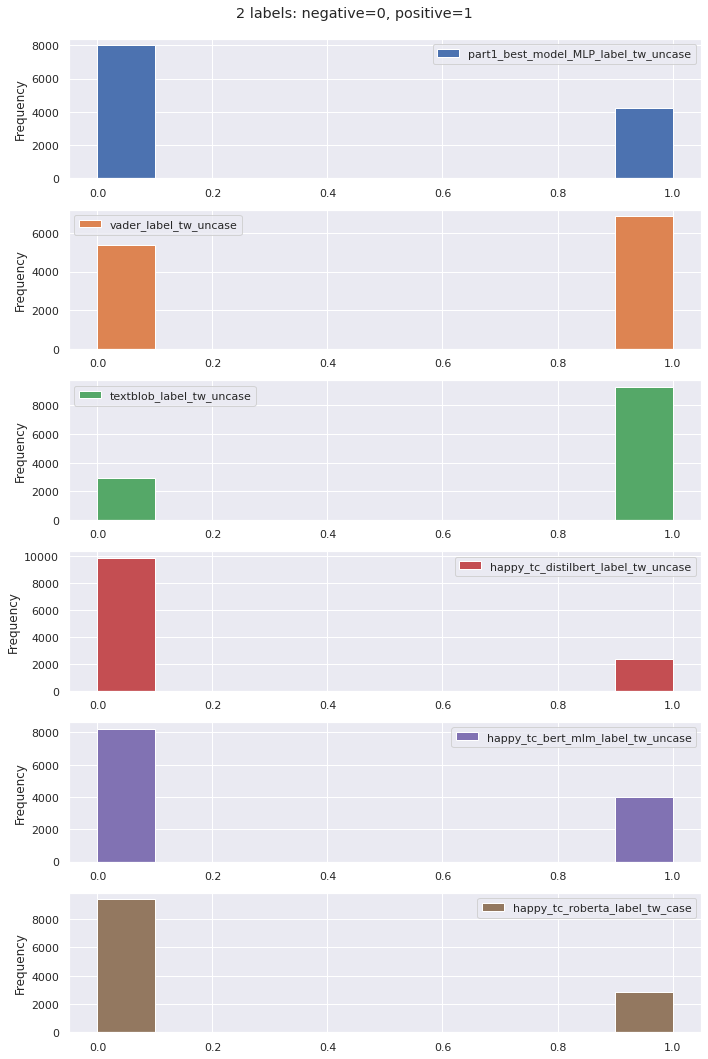

In [ ]:
# 2 labels
fig = plt.figure(figsize = (10,15))
ax = fig.gca()
tw_df_2labels[['part1_best_model_MLP_label_tw_uncase','vader_label_tw_uncase','textblob_label_tw_uncase','happy_tc_distilbert_label_tw_uncase','happy_tc_bert_mlm_label_tw_uncase','happy_tc_roberta_label_tw_case']].plot(kind="hist",subplots=True, title="2 labels: negative=0, positive=1",ax=ax)
fig.tight_layout()
fig.subplots_adjust(top=0.95)

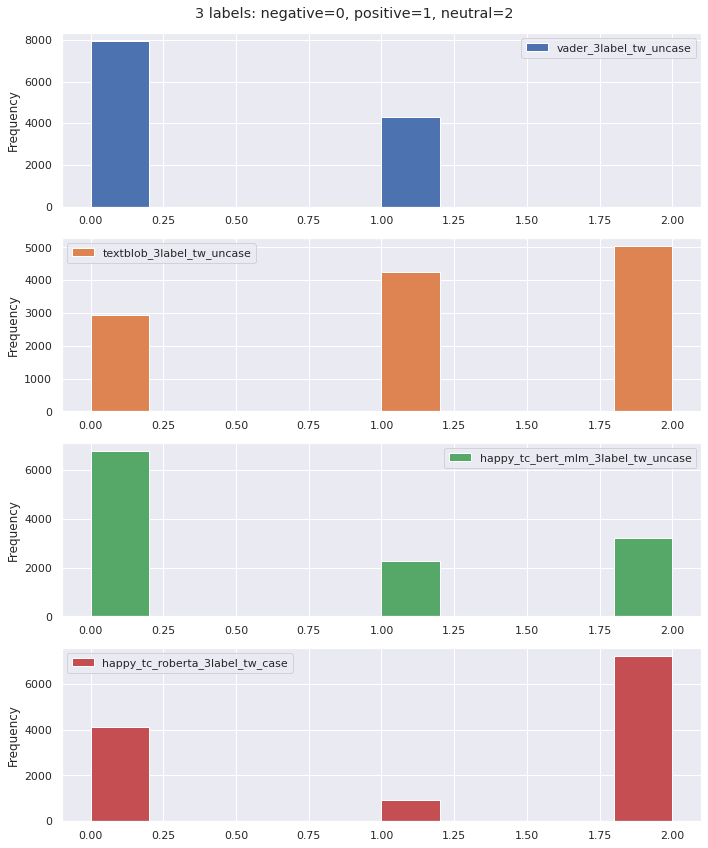

In [ ]:
# 3 labels
fig = plt.figure(figsize = (10,12))
ax = fig.gca()
tw_model_data[['vader_3label_tw_uncase','textblob_3label_tw_uncase','happy_tc_bert_mlm_3label_tw_uncase','happy_tc_roberta_3label_tw_case']].plot(kind="hist",subplots=True, title="3 labels: negative=0, positive=1, neutral=2",ax=ax)
fig.tight_layout()
fig.subplots_adjust(top=0.95)

##### Evaluation

We can see that *again* textblob have a very unusual distribution. This is because there are many samples with a neutral score of 0. Where in the 2 labels scenario they are all classified as positive labels.

In [ ]:
tw_model_data['textblob_scores_tw_uncase'].value_counts()

 0.000000    5039
 0.100000     243
 0.500000     233
-0.100000     224
 0.200000     219
             ... 
-0.128571       1
 0.103571       1
 0.545000       1
 0.082857       1
-0.391667       1
Name: textblob_scores_tw_uncase, Length: 1134, dtype: int64

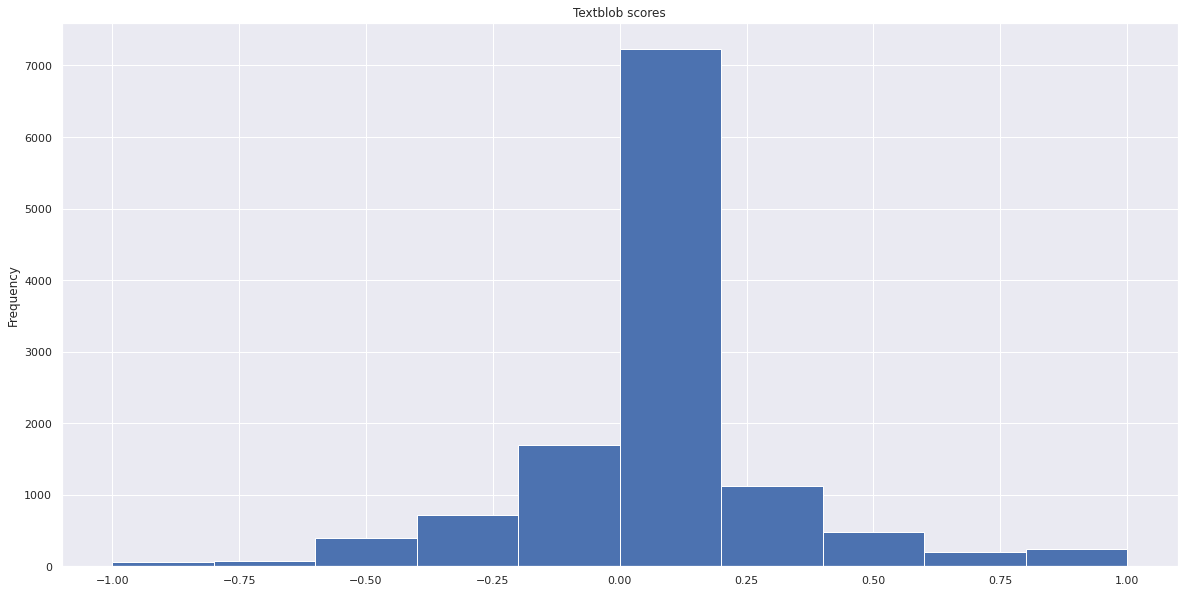

In [ ]:
tw_model_data['textblob_scores_tw_uncase'].plot(kind="hist", title="Textblob scores")

Overall, the happy tranformer models holds a consistent analysis results. And we will continue use the best performaning model [happy_tc_roberta] from part 2 model comparison as our final decision model.

##### Wordclouds

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


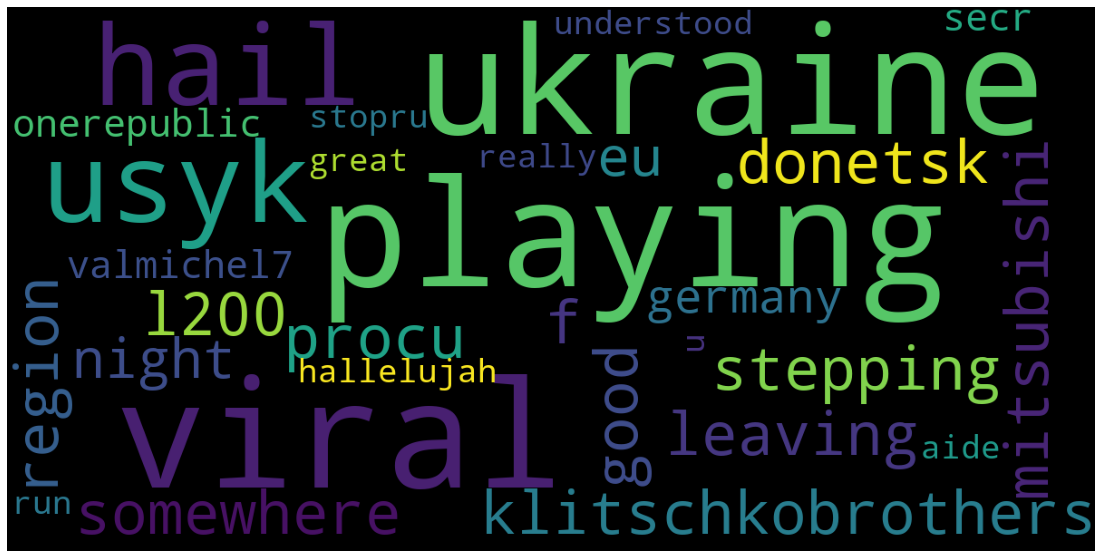

In [ ]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

# plot wordcloud for positive comments
stopwords_set = set(stop_words)
wordcloud = WordCloud(background_color='black',
                     stopwords = stopwords_set,
                      max_words = 30,
                      max_font_size = 55,
                      scale = 3,
                      random_state=42
                     ).generate(str(tw_model_data.loc[tw_model_data["happy_tc_roberta_3label_tw_case"]==1]["text_uncase"]))

print(wordcloud)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

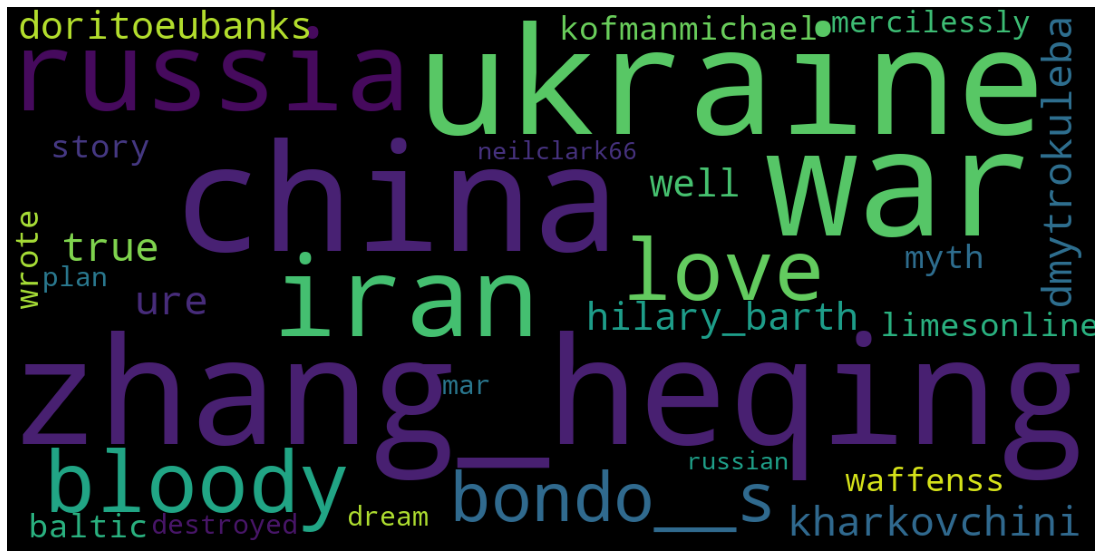

In [ ]:
# plot wordcloud for positive comments
stopwords_set = set(stop_words)
wordcloud = WordCloud(background_color='black',
                     stopwords = stopwords_set,
                      max_words = 30,
                      max_font_size = 55,
                      scale = 3,
                      random_state=42
                     ).generate(str(tw_model_data.loc[tw_model_data["happy_tc_roberta_3label_tw_case"]==0]["text_uncase"]))

print(wordcloud)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

##### Actual comments

In [ ]:
# Positive comments, print 5
pd.set_option('display.max_colwidth', None)
tw_model_data.loc[tw_model_data["happy_tc_roberta_3label_tw_case"]==1][:5]["text"]

2     Hail #Usyk and the #KlitschkoBrothers for stepping up, leaving their fame and fortune behind. #Ukraine will be victorious and some theme #music is in order to celebrate the victory. \n\n#Listen and add now: https://t.co/NcxrX574h1 https://t.co/5uIMwgL0pb
10                                                                A 📸 of Mitsubishi L200 somewhere in #Donetsk region procured with the help of a bunch of cool folks who really care for #Ukraine (aka you, our amazing supporters :-) 💙💛🇺🇦 https://t.co/kzzQ0nrIzg
28                                                                                                                                  Have a good night #EU 🇪🇺#Germany🇩🇪 #Ukraine🇺🇦\nOneRepublic - Secrets (Official Music Video) https://t.co/YmeDXVF105 via @YouTube
33                                                                                                                                            @VALMICHEL7 Hallelujah 😂 \nThey are really understood 😅\n#StopRussia \nDefi

In [ ]:
# Negative comments, print 5
tw_model_data.loc[tw_model_data["happy_tc_roberta_3label_tw_case"]==0][:5]["text"]

8                                                                                                                                                                                                                                                #Russia and #Iran.. and bloody love  \nhttps://t.co/wKJXmIouMX
12                                                                                                                                                                                      @Bondo__s @Kharkovchini @DmytroKuleba No, it's not true. U're toxic man, so shame on u. U're lost in this information.💩
13                                                                                                    @Hilary_Barth @doritoeubanks Well, @KofmanMichael was never a serious expert on #Ukraine / #Russia because 1) he's extremely selfish, 2) he's actually an empty shell who has no real knowledge and lore.
14    I wrote in @limesonline about the myth of the #WaffenSS in the #Baltics and #Ukrai

In [ ]:
pd.reset_option('display.max_colwidth')

##### Insights

We can see that most of the positive comments are praying for Ukraine. Some of the positive comments are actually being sarcastic on Putin and Russia, but falsely classified as positive comments by our model.

For the negative comments, most of them consists of accusing Putin and Russia or express sadness on hearing about the war.

We now understand:
1. For this case, to achieve high number of positive replies might be our goal, as sadness also contains powers.

2. We need to go beyond simple sentiment analysis, we need to get sentiment towards certain labels ("Ukraine" vs "Russia"). And possibly identify the factors and topics behind the attitude in order to come up with a better analysis.

# Part 3 & 4

## Product: Hawkeye

Product line #1

**Hawkeye**

Using our SNS-hawkeye analysis tools, government or companies can:

1. Trace the real-time SNS attitude trending on a given topic, here we show the topic of supporting Ukraine or Russia.

2. And we are able to identify the specific topic or reasoning behind each raise and drop, helping the customer to pin-point the exact cause and be always ready to take action and response.

Workflow:

Full view on the SNS messages ( e.g. Twitter) with entity-based sentiment analysis scores, history and real-time.

Zoom into peaks/downs for topics analysis.



### Part3 Twitter data

Dataset: https://www.kaggle.com/datasets/bwandowando/ukraine-russian-crisis-twitter-dataset-1-2-m-rows

We took a subset of the month November 2022 (to Nov.29)

Also credits to: https://github.com/alexdrk14/RussoUkrainianWar_Dataset



#### load data directly from a saved file

In [ ]:
# Or, load it directly from Google Drive
# Mount GD
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load data from csv to pandas
import pandas as pd
import numpy as np

# Path to dataset file

data_path = project_path+'data/part_3/twitter_all/' # change path to drive location


import datetime, calendar

# Chooss year and month
year,month = 2022,11
num_days = calendar.monthrange(year, month)[1]
days = [datetime.date(year, month, day).strftime('%m%d') for day in range(1, num_days+1)]

# for some reasons November does not have 1130
days = days[:-1]

# Format: 1101_UkraineCombinedTweetsDeduped.csv.gzip
# This is just here for preview, I will not preload every day into a single df, just to ease on memory
for day in days:
  raw_day_data = pd.read_csv(data_path+day+'_UkraineCombinedTweetsDeduped.csv.gzip', compression='gzip', low_memory=False)  
  break

# preview
raw_day_data


Unnamed: 0               userid         username  \
0           57979           1428039708  TravelYesPlease   
1           57980  1454933352755212288  Icibeyrouthnews   
2           57981  1581283835580391426         MI6Fella   
3           57982  1569297538502594561   iamthinkernice   
4           57983  1499763123603050497     FuckPutinBot   
...           ...                  ...              ...   
46144      104123            362481049     ArinaDrobaha   
46145      104124  1586785977015717890           SLlbyt   
46146      104125   951125272652369921         TKanicke   
46147      104126  1255482927795834883    imminent_news   
46148      104127           1937362208     larrywasslen   

                                                acctdesc  \
0      Award winning travel photographer, writer. Sha...   
1      Site d’information et d’investigation générale...   
2      🇺🇦🇬🇧Ukraine supporter - MI6 Fella reporting in...   
3                             Crypto Lover\nLove Ukraine   
4      I'm a bot. Every minute of every day, I tell P...   
...                                                  ...   
46144  серіальний задрот, виноман, книголюб, озлоблен...   
46145                                                NaN   
46146                     FCM - Stadtfeld - LCP - Bagage   
46147  World news for global citizens - We search for...   
46148  Former RN. 40 yrs. He/Him/Communist Revolution...   

                       location  following  followers  totaltweets  \
0                  Edmonton, AB      34911      37723        27054   
1                         Liban          0       4742        14023   
2      Albert Embankment London        933        672          830   
3                       Ukraine          0          6          273   
4                           NaN         14        263       335545   
...                         ...        ...        ...          ...   
46144                      Киев        242        308         8684   
46145                       NaN         14         10          328   
46146                       NaN        135         95         3656   
46147                       NaN          1     108327        41558   
46148           Ottawa, Ontario       4357       2443        52450   

             usercreatedts              tweetid  ... original_tweet_userid  \
0      2013-05-14 14:54:41  1587232954677436417  ...                     0   
1      2021-10-31 22:08:45  1587232956229246977  ...                     0   
2      2022-10-15 14:00:35  1587232958703976448  ...                     0   
3      2022-09-12 12:11:19  1587232959857188864  ...                     0   
4      2022-03-04 15:06:25  1587232963070148609  ...                     0   
...                    ...                  ...  ...                   ...   
46144  2011-08-26 13:34:13  1587595290508394497  ...                     0   
46145  2022-10-30 18:24:05  1587595309047218176  ...                     0   
46146  2018-01-10 16:15:10  1587595309772939265  ...                     0   
46147  2020-04-29 13:04:54  1587595323572191232  ...                     0   
46148  2013-10-05 11:31:05  1587595332623667200  ...                     0   

       original_tweet_username in_reply_to_status_id in_reply_to_user_id  \
0                          NaN                     0                   0   
1                          NaN                     0                   0   
2                          NaN   1587032451846737920  888183349864476672   
3                          NaN                     0                   0   
4                          NaN                     0                   0   
...                        ...                   ...                 ...   
46144                      NaN                     0                   0   
46145                      NaN                     0                   0   
46146                      NaN   1587500121897443328           114718372   
46147                      NaN         

#### Feature Engineering for pre-trained models

In [ ]:
# for case models 
raw_day_data_proc = fe_pipeline(raw_day_data,"text","part3")

raw_day_data_proc[["text","text_part3"]].head()

text  \
0  The Haunting Beauty of Bonaventure Cemetery- S...   
1  #Monde 🇷🇺🇦🇲 \nAprès des affrontements qui ont ...   
2  @apmassaro3 @IlvesToomas France Spain and Ital...   
3  Russian combat losses in Ukraine War on all fr...   
4  去他妈的，普京！\n(Chinese Simplified)\n\n#PutinsWar #...   

                                          text_part3  
0  The Haunting Beauty of Bonaventure Cemetery- S...  
1  #Monde  \nAprs des affrontements qui ont fait ...  
2  @apmassaro3 @IlvesToomas France Spain and Ital...  
3  Russian combat losses in Ukraine War on all fr...  
4  \n(Chinese Simplified)\n\n#PutinsWar #Ukraine ...

#### Part 3&4 helper functions


In [ ]:
from textblob import TextBlob
from tqdm import tqdm
import time


obvious_tags_ukraine = ["#PrayForUkraine","#StandWithUkraine","#StandWithUkraineNOW","#BlockPutinWallets","#StopPutin","#StopRussianAggression","#StopRussia","#FuckPutin","#solidarityWithUkraine",
                        "#PutinWarCriminal","#PutinHitler"]

obvious_tags_russia = ["#with_russia","#FUCK_NATO","#myfriendPutin","#UnitedAgainstUkraine","#ВпередРоссия","#ЯМыРоссия","#ВеликаяРоссия","#россиявперед","#россиявперёд","#Путинмойпрезидент",
                       "#ПутинНашПрезидент","#Путинмойпрезидент","#СЛАВАРОССИИ"]

obvious_tags_ukraine_lower = [x.lower() for x in obvious_tags_ukraine]
obvious_tags_russia_lower = [x.lower() for x in obvious_tags_russia]

# A precheck with obvious hashtags
def obvious_tags(text_lower,obvious_tags_ukraine=obvious_tags_ukraine_lower,obvious_tags_russia=obvious_tags_russia_lower):  
  if(any(substring in text_lower for substring in obvious_tags_ukraine)):  
    return 0
  elif(any(substring in text_lower for substring in obvious_tags_russia)):
    return 1
  else:
    return 2


In [ ]:
from transformers import Pipeline

# customized pipeline, to insert our data processing in beginning
class MyPipeline(Pipeline):    
    def preprocess(self, inputs):
        print(inputs)
        #model_input = Tensor(inputs["input_ids"])
        #return {"model_input": model_input}


#### Build pipelines

In [ ]:
import datasets
from transformers import pipeline
from transformers.pipelines.pt_utils import KeyDataset
from tqdm.auto import tqdm

pipe = pipeline("zero-shot-classification",model="facebook/bart-large-mnli")


In [ ]:
pipe2 = pipeline("zero-shot-classification",model="joeddav/xlm-roberta-large-xnli")

Some weights of the model checkpoint at joeddav/xlm-roberta-large-xnli were not used when initializing XLMRobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
pipe3 = pipeline("zero-shot-classification",model="vicgalle/xlm-roberta-large-xnli-anli")

#### Run models

##### A dipping test

In [ ]:
candidate_labels = ['Ukraine', 'Russia']

for idx, data_row in tqdm(raw_day_data_proc.iterrows(), total=raw_day_data_proc.shape[0]):
  pipe_ret = pipe(data_row["text_part3"], candidate_labels)
  pipe2_ret = pipe2(data_row["text_part3"], candidate_labels)
  pipe3_ret = pipe3(data_row["text_part3"], candidate_labels)

  print("\n",data_row["text"])
  print(pipe_ret["labels"],pipe_ret["scores"])
  print(pipe2_ret["labels"],pipe2_ret["scores"])
  print(pipe3_ret["labels"],pipe2_ret["scores"])

  if(idx>20):
    break

  0%|          | 0/46149 [00:00<?, ?it/s]


 The Haunting Beauty of Bonaventure Cemetery- Savannah, Georgia https://t.co/JyOJyPHlIj #UnitedStates #travel
['Ukraine', 'Russia'] [0.5163983702659607, 0.4836015999317169]
['Russia', 'Ukraine'] [0.5510314702987671, 0.4489684998989105]
['Russia', 'Ukraine'] [0.5510314702987671, 0.4489684998989105]

 #Monde 🇷🇺🇦🇲 
Après des affrontements qui ont fait 286 morts entre l’#Arménie et l’#Azerbaïdjan, la #Russie a annoncé un sommet à #Sotchi ce lundi.
https://t.co/dMAQZ5IuOM
['Russia', 'Ukraine'] [0.9916684627532959, 0.00833149068057537]
['Russia', 'Ukraine'] [0.995965301990509, 0.004034693352878094]
['Russia', 'Ukraine'] [0.995965301990509, 0.004034693352878094]

 @apmassaro3 @IlvesToomas France Spain and Italy... you what? #RussiaIsLosing #russiaisateroriststate
['Russia', 'Ukraine'] [0.9718860387802124, 0.02811392955482006]
['Russia', 'Ukraine'] [0.9976740479469299, 0.0023259485606104136]
['Russia', 'Ukraine'] [0.9976740479469299, 0.0023259485606104136]

 Russian combat losses in Ukraine W

We can see that the first model "facebook/bart-large-mnli" is more accurate, and it seems knowing the connection between Zelensky and Ukraine.

For example

 @RishiSunak we are NOT being invaded. Apologise to us and more importantly, apologise to President #Zelensky &amp; the brave people of #Ukraine - who ARE being invaded. #SackBraverman #HateSpeech #Conservatives

pipe1: ['Ukraine', 'Russia'] [0.9952967762947083, 0.004703229293227196]

pipe2: ['Russia', 'Ukraine'] [0.5576242804527283, 0.4423757791519165]

pipe3: ['Ukraine', 'Russia'] [0.5576242804527283, 0.4423757791519165]


We will also be dropping random twitter texts that obviously have no bias on neither side. We will do this by setting a threshold on difference in scores:

 The Haunting Beauty of Bonaventure Cemetery- Savannah, Georgia https://t.co/JyOJyPHlIj #UnitedStates #travel

pipe1: ['Ukraine', 'Russia'] [0.5163983702659607, 0.4836015999317169]

pipe2: ['Russia', 'Ukraine'] [0.5510314702987671, 0.4489684998989105]

pipe3: ['Russia', 'Ukraine'] [0.5510314702987671, 0.4489684998989105]

##### Final runs

Each run for a full day's data takes about 6 hrs even with the skip on a premium GPU colab setting.

The code took 47.36835980415344 seconds to run 100 samples.

So a reasonable choice is to run a smaller-sized sample for each day. We pick the sample size = 1000.

In [ ]:
# Make a local folder
!mkdir part3_twitter_1000sample_per_day

mkdir: cannot create directory ‘part3_twitter_1000sample_per_day’: File exists


In [ ]:
# Uncomment to run, this takes ~6hr on Colab premium GPU
# The resuls will be loaded in the next section
"""

import os

candidate_labels = ['Ukraine', 'Russia']
# only record favour count if score difference > theshold
threshold = 0.2
# number of samples we randomly select from each day's twitters
sample_size = 1000

start_time = time.time()

# Load the datasets per day with the happy tc dataset module to ease memory usage, 
# filename format: 1101_UkraineCombinedTweetsDeduped.csv.gzip
for day in days:
  date_file = data_path+day+'_UkraineCombinedTweetsDeduped.csv.gzip'
  print("\nProcessing "+date_file)

  raw_day_data = pd.read_csv(date_file, compression='gzip', low_memory=False)  

  raw_day_data_proc = fe_pipeline(raw_day_data,"text","part3")  
  raw_day_data_proc['text_part3'].replace('', np.nan, inplace=True)
  raw_day_data_proc = raw_day_data_proc[raw_day_data_proc['text_part3'].notna()]

  # Sampling after the fe, since we need to drop nan after it, with fixed seed
  sample_day_data_proc = raw_day_data_proc.sample(n=sample_size, replace=False, random_state=42)
  print("Sampling from ",raw_day_data.shape[0],"to ",sample_size)

  # enable columns
  sample_day_data_proc["favour_Ukraine"]=0
  sample_day_data_proc["favour_Russia"]=0  
  
  for idx, data_row in tqdm(sample_day_data_proc.iterrows(), total=sample_day_data_proc.shape[0]):
    tag_pre_check = obvious_tags(data_row["text_part3"])    

    if(tag_pre_check == 2):
      pipe_ret = pipe(data_row["text_part3"], candidate_labels)      
      if(abs(pipe_ret["scores"][0]-pipe_ret["scores"][1]) > threshold):
          sample_day_data_proc.at[idx,"favour_"+pipe_ret["labels"][0]]=1      

    elif(tag_pre_check == 0):
      sample_day_data_proc.at[idx,"favour_Ukraine"]=1
    elif(tag_pre_check == 1):
      sample_day_data_proc.at[idx,"favour_Russia"]=1    
  
  # Save to file backup
  sample_day_data_proc.to_csv('/content/part3_twitter_1000sample_per_day/'+day+'_proc.csv', encoding='utf-8', index=False)

  # cp from tmp to GD
  os.system(f'cp "/content/part3_twitter_1000sample_per_day/'+day+'_proc.csv" "/content/drive/MyDrive/UofT_MEng/MIE1624/Project/data/part_3/part3_twitter_1000sample_per_day/"')
  

print("\nThis code took", time.time() - start_time, "to run")
"""

'\n\nimport os\n\ncandidate_labels = [\'Ukraine\', \'Russia\']\n# only record favour count if score difference > theshold\nthreshold = 0.2\n# number of samples we randomly select from each day\'s twitters\nsample_size = 1000\n\nstart_time = time.time()\n\n# Load the datasets per day with the happy tc dataset module to ease memory usage, \n# filename format: 1101_UkraineCombinedTweetsDeduped.csv.gzip\nfor day in days:\n  date_file = data_path+day+\'_UkraineCombinedTweetsDeduped.csv.gzip\'\n  print("\nProcessing "+date_file)\n\n  raw_day_data = pd.read_csv(date_file, compression=\'gzip\', low_memory=False)  \n\n  raw_day_data_proc = fe_pipeline(raw_day_data,"text","part3")  \n  raw_day_data_proc[\'text_part3\'].replace(\'\', np.nan, inplace=True)\n  raw_day_data_proc = raw_day_data_proc[raw_day_data_proc[\'text_part3\'].notna()]\n\n  # Sampling after the fe, since we need to drop nan after it, with fixed seed\n  sample_day_data_proc = raw_day_data_proc.sample(n=sample_size, replace=False

In [ ]:
# Backpack
#!cp -a /content/part3_twitter_1000sample_per_day/. /content/drive/MyDrive/UofT_MEng/MIE1624/Project/data/part_3/twitter_all/part3_twitter_1000sample_per_day/

### Hawkeye: visualization and evaluation

#### Load results

In [ ]:
# The results are stored in porject folder -> ./data/part_3/twitter_all/part3_twitter_1000sample_per_day/
results_path = project_path+"data/part_3/twitter_all/part3_twitter_1000sample_per_day/"

days_obj = [datetime.date(year, month, day) for day in range(1, num_days+1)]
days_obj = days_obj[:-1]

# create a summary dataframe
month_result = pd.DataFrame(columns=["Date","favour_Ukraine_count","favour_Russia_count","Neutral_count"])
day_results = {}
for d_idx, day in enumerate(days):
  #print(d_idx)
  date_result_file = results_path+day+'_proc.csv'
  # A weird bug will pop for the old method, use engine='python'
  #raw_day_result_data = pd.read_csv(date_result_file, low_memory=False)    
  raw_day_result_data = pd.read_csv(date_result_file, engine='python')  
  

  # get values
  row_date = days_obj[d_idx]
  row_ukraine = int(raw_day_result_data["favour_Ukraine"].sum())
  row_russia = int(raw_day_result_data["favour_Russia"].sum())
  row_neutral = len(raw_day_result_data[(raw_day_result_data["favour_Ukraine"]==0) & (raw_day_result_data["favour_Russia"]==0)])
  
  month_result.loc[d_idx]=[row_date,row_ukraine,row_russia,row_neutral]
  day_results[day]=raw_day_result_data.copy()

month_result.head(3)

Date favour_Ukraine_count favour_Russia_count Neutral_count
0  2022-11-01                  485                 269           246
1  2022-11-02                  472                 282           246
2  2022-11-03                  523                 221           255

#### Trending over time

In [ ]:
palette = sns.color_palette()
palette

[(0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
 (0.8666666666666667, 0.5176470588235295, 0.3215686274509804),
 (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
 (0.7686274509803922, 0.3058823529411765, 0.3215686274509804),
 (0.5058823529411764, 0.4470588235294118, 0.7019607843137254),
 (0.5764705882352941, 0.47058823529411764, 0.3764705882352941),
 (0.8549019607843137, 0.5450980392156862, 0.7647058823529411),
 (0.5490196078431373, 0.5490196078431373, 0.5490196078431373),
 (0.8, 0.7254901960784313, 0.4549019607843137),
 (0.39215686274509803, 0.7098039215686275, 0.803921568627451)]

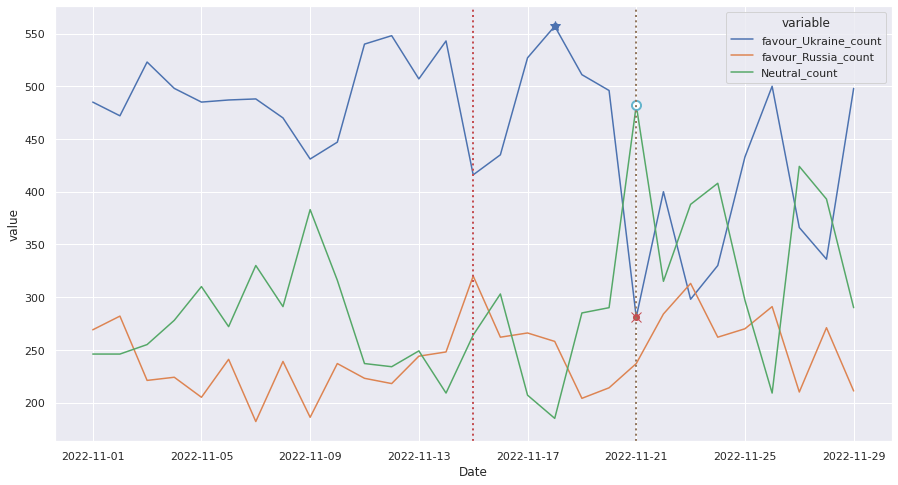

In [ ]:
#from datetime import datetime

plt.figure(figsize=(15,8))

ax = sns.lineplot(data=month_result.melt(id_vars=['Date']), x='Date', y='value', hue='variable')

# Pin Ukraine all time high & low
plt.plot(datetime.datetime.strptime("2022-11-18", '%Y-%m-%d'), month_result.iloc[17]['favour_Ukraine_count'],'b*',markersize=10) 
plt.plot(datetime.datetime.strptime("2022-11-18", '%Y-%m-%d'), month_result.iloc[17]['favour_Ukraine_count'],'bo') 
plt.plot(datetime.datetime.strptime("2022-11-21", '%Y-%m-%d'), month_result.iloc[20]['favour_Ukraine_count'],'rx',markersize=10) 
plt.plot(datetime.datetime.strptime("2022-11-21", '%Y-%m-%d'), month_result.iloc[20]['favour_Ukraine_count'],'ro') 

# Pin weird high neutral peak
plt.plot(datetime.datetime.strptime("2022-11-21", '%Y-%m-%d'), month_result.iloc[20]['Neutral_count'],'co',markersize=10)
plt.plot(datetime.datetime.strptime("2022-11-21", '%Y-%m-%d'), month_result.iloc[20]['Neutral_count'],'wo')

# pin two drops date
plt.axvline(datetime.datetime.strptime("2022-11-15", '%Y-%m-%d'),ls=":",color=palette[3],lw=2)
plt.axvline(datetime.datetime.strptime("2022-11-21", '%Y-%m-%d'),ls=":",color=palette[5],lw=2)

#### Hawkeye: Wordclouds & LDA

What are the high frequent words from the peak/low dates?

What are the actual topics from the peak/low dates?

##### Helper function

###### Wordcloud

In [ ]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

# str(reddit_model_data.loc[reddit_model_data["happy_tc_roberta_3label_reddit_case"]==1]["comment_uncase"])
def word_cloud(data,title="",stop_words=stop_words):
  # plot wordcloud for positive comments
  stopwords_set = set(stop_words)
  wordcloud = WordCloud(background_color='black',
                      stopwords = stopwords_set,
                        max_words = 30,
                        max_font_size = 55,
                        scale = 3,
                        random_state=42
                      ).generate(data)

  print(wordcloud)
  plt.title(title)
  plt.imshow(wordcloud)
  plt.axis('off')
  plt.show()


def print_real_comments(day_ret,favour="Ukraine", top=3):
  # Acutal comments
  pd.set_option('display.max_colwidth', None)

  if(favour=="Ukraine" or favour=="Russia" ):
    comments_df = day_ret.loc[day_ret["favour_"+favour]==1]
    for ind, r_comments in enumerate(comments_df[:top]["text"].tolist()):
      print("Comment ",ind)
      print(r_comments,"\n")
  else:
    comments_df = day_ret.loc[(day_ret["favour_Ukraine"]==0) & (day_ret["favour_Russia"]==0) ]
    for ind, r_comments in enumerate(comments_df[:top]["text"].tolist()):
      print("Comment ",ind)
      print(r_comments,"\n")

  return comments_df

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


###### LDA

In [ ]:
# LDA
# https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/

import sys
# !{sys.executable} -m spacy download en
import re, numpy as np, pandas as pd
from pprint import pprint

# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])

%matplotlib inline
warnings.filterwarnings("ignore",category=DeprecationWarning)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

In [ ]:
!python -m spacy download en

⚠ As of spaCy v3.0, shortcuts like 'en' are deprecated. Please use the
full pipeline package name 'en_core_web_sm' instead.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 12.8 MB 4.7 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [ ]:
!pip install pyLDAvis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# LDA plots

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  



# !python -m spacy download en  # run in terminal once
def process_words(texts, bigram_mod, trigram_mod, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
    #nlp = spacy.load("en_core_web_sm")
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out



def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)



def LDA_topics(df):
  # Convert to list
  data = df.text_part3.values.tolist()
  data_words = list(sent_to_words(data))
  #print(data_words[:1])

  # Build the bigram and trigram models
  bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
  trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
  bigram_mod = gensim.models.phrases.Phraser(bigram)
  trigram_mod = gensim.models.phrases.Phraser(trigram)

  data_ready = process_words(data_words,bigram_mod,trigram_mod)

  # Build the topic model
  # Create Dictionary
  id2word = corpora.Dictionary(data_ready)

  # Create Corpus: Term Document Frequency
  corpus = [id2word.doc2bow(text) for text in data_ready]

  # Build LDA model
  lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=id2word,
                                            num_topics=4, 
                                            random_state=100,
                                            update_every=1,
                                            chunksize=10,
                                            passes=10,
                                            alpha='symmetric',
                                            iterations=100,
                                            per_word_topics=True)

  #pprint(lda_model.print_topics())

  df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)

  # Format
  df_dominant_topic = df_topic_sents_keywords.reset_index()
  df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
  #print(df_dominant_topic.head(10)

  return df_topic_sents_keywords,df_dominant_topic,lda_model,data_ready,corpus

# most representative sentence for each topic
def most_representative_sentence(df_topic_sents_keywords):
  # Display setting to show more characters in column
  pd.options.display.max_colwidth = 100

  sent_topics_sorteddf_mallet = pd.DataFrame()
  sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

  for i, grp in sent_topics_outdf_grpd:
      sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                              grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                              axis=0)

  # Reset Index    
  sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

  # Format
  sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

  # Show
  #sent_topics_sorteddf_mallet.head(10)

  return sent_topics_sorteddf_mallet


#  Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

def wordcloud_per_topic(lda_model):
  cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

  cloud = WordCloud(stopwords=stop_words,
                    background_color='white',
                    width=2500,
                    height=1800,
                    max_words=10,
                    colormap='tab10',
                    color_func=lambda *args, **kwargs: cols[i],
                    prefer_horizontal=1.0)

  topics = lda_model.show_topics(formatted=False)

  fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

  for i, ax in enumerate(axes.flatten()):
      fig.add_subplot(ax)
      topic_words = dict(topics[i][1])
      cloud.generate_from_frequencies(topic_words, max_font_size=300)
      plt.gca().imshow(cloud)
      plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
      plt.gca().axis('off')


  plt.subplots_adjust(wspace=0, hspace=0)
  plt.axis('off')
  plt.margins(x=0, y=0)
  plt.tight_layout()
  plt.show()


from collections import Counter
# Plot Word Count and Weights of Topic Keywords
def word_count_per_topic(lda_model,data_ready):
  topics = lda_model.show_topics(formatted=False)
  data_flat = [w for w_list in data_ready for w in w_list]
  counter = Counter(data_flat)

  out = []
  for i, topic in topics:
      for word, weight in topic:
          out.append([word, i , weight, counter[word]])

  df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

  # Plot Word Count and Weights of Topic Keywords
  fig, axes = plt.subplots(2, 2, figsize=(12,8), sharey=True) #, dpi=120)
  cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
  for i, ax in enumerate(axes.flatten()):
      ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
      ax_twin = ax.twinx()
      ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
      ax.set_ylabel('Word Count', color=cols[i])
      ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
      ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
      ax.tick_params(axis='y', left=False)
      ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
      ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

  fig.tight_layout(w_pad=2)    
  fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
  plt.show()


# Sentence Coloring of N Sentences
from matplotlib.patches import Rectangle

def sentences_chart(lda_model, corpus, start = 0, end = 13):
    corp = corpus[start:end]
    mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    fig, axes = plt.subplots(end-start, 1, figsize=(20, (end-start)*0.95), dpi=160)       
    axes[0].axis('off')
    for i, ax in enumerate(axes):
        if i > 0:
            corp_cur = corp[i-1] 
            topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
            word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]    
            ax.text(0.01, 0.5, "Doc " + str(i-1) + ": ", verticalalignment='center',
                    fontsize=16, color='black', transform=ax.transAxes, fontweight=700)

            # Draw Rectange
            topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
            ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1, 
                                   color=mycolors[topic_percs_sorted[0][0]], linewidth=2))

            word_pos = 0.06
            for j, (word, topics) in enumerate(word_dominanttopic):
                if j < 14:
                    ax.text(word_pos, 0.5, word,
                            horizontalalignment='left',
                            verticalalignment='center',
                            fontsize=16, color=mycolors[topics],
                            transform=ax.transAxes, fontweight=700)
                    word_pos += .009 * len(word)  # to move the word for the next iter
                    ax.axis('off')
            ax.text(word_pos, 0.5, '. . .',
                    horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=16, color='black',
                    transform=ax.transAxes)       

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle('Sentence Topic Coloring for Documents: ' + str(start) + ' to ' + str(end-2), fontsize=22, y=0.95, fontweight=700)
    plt.tight_layout()
    plt.show()

# Sentence Coloring of N Sentences
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)



from matplotlib.ticker import FuncFormatter

def topics_per_document_plot(lda_model,corpus):
  dominant_topics, topic_percentages = topics_per_document(model=lda_model, corpus=corpus, end=-1)            

  # Distribution of Dominant Topics in Each Document
  df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
  dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
  df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

  # Total Topic Distribution by actual weight
  topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
  df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

  # Top 3 Keywords for each Topic
  topic_top3words = [(i, topic) for i, topics in lda_model.show_topics(formatted=False) 
                                  for j, (topic, wt) in enumerate(topics) if j < 3]

  df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
  df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
  df_top3words.reset_index(level=0,inplace=True)


  # Plot
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), dpi=120, sharey=True)

  # Topic Distribution by Dominant Topics
  ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
  ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
  tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
  ax1.xaxis.set_major_formatter(tick_formatter)
  ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
  ax1.set_ylabel('Number of Documents')
  ax1.set_ylim(0, 1000)

  # Topic Distribution by Topic Weights
  ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
  ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
  ax2.xaxis.set_major_formatter(tick_formatter)
  ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=10))

  plt.show()


# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

def LDA_T_SNE_clustering(lda_model,corpus):
  # Get topic weights
  topic_weights = []
  for i, row_list in enumerate(lda_model[corpus]):
      topic_weights.append([w for i, w in row_list[0]])

  # Array of topic weights    
  arr = pd.DataFrame(topic_weights).fillna(0).values

  # Keep the well separated points (optional)
  arr = arr[np.amax(arr, axis=1) > 0.35]

  # Dominant topic number in each doc
  topic_num = np.argmax(arr, axis=1)

  # tSNE Dimension Reduction
  tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
  tsne_lda = tsne_model.fit_transform(arr)

  # Plot the Topic Clusters using Bokeh
  output_notebook()
  n_topics = 4
  mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
  plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
                plot_width=900, plot_height=700)
  plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
  show(plot)

#import pyLDAvis.gensim
# Deprecate import
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

# pyLDAis_plot = interactive HTML
def pyLDAis_plot(lda_model,corpus):
  pyLDAvis.enable_notebook()
  #vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
  vis = gensimvis.prepare(lda_model, corpus, dictionary=lda_model.id2word)
  return vis

###### LDA showcase

In [ ]:
df_topic_sents_keywords,df_dominant_topic,lda_model,data_ready,corpus = LDA_topics(day_results["1118"])
df_dominant_topic.head(10)

/usr/local/lib/python3.8/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


Document_No  Dominant_Topic  Topic_Perc_Contrib  \
0            0             2.0              0.7358   
1            1             1.0              0.7954   
2            2             2.0              0.6249   
3            3             0.0              0.7491   
4            4             3.0              0.5415   
5            5             1.0              0.8869   
6            6             0.0              0.2500   
7            7             3.0              0.7781   
8            8             0.0              0.7322   
9            9             0.0              0.8000   

                                            Keywords  \
0  russian, ukrainian, unitedstate, missile, zele...   
1  ukraine, united_state, amp, child, give, check...   
2  russian, ukrainian, unitedstate, missile, zele...   
3  putinwarcrime, russiaislose, fuckputin, israel...   
4  drone, show, war, help, work, find, animal, ca...   
5  ukraine, united_state, amp, child, give, check...   
6  putinwarcrime, russiaislose, fuckputin, israel...   
7  drone, show, war, help, work, find, animal, ca...   
8  putinwarcrime, russiaislose, fuckputin, israel...   
9  putinwarcrime, russiaislose, fuckputin, israel...   

                                                Text  
0                       [indonesian, russiawarcrime]  
1  [le, correspondant, envoy, envahissent, les, m...  
2                                    [ukrainewarnew]  
3                                        [ruso, onu]  
4                  [ukraine, live, war, update, day]  
5  [rpublicain, demandent, peine, arriv, dpense, ...  
6                                                 []  
7  [proud, hear, last, night, report, create, tim...  
8                           [realizar, liquidacione]  
9                      [essa, bomba, culturadigital]

In [ ]:
sent_topics_sorteddf_mallet = most_representative_sentence(df_topic_sents_keywords)
sent_topics_sorteddf_mallet.head(10)

Topic_Num  Topic_Perc_Contrib  \
0        0.0              0.9394   
1        1.0              0.9421   
2        2.0              0.9464   
3        3.0              0.9554   

                                                                                              Keywords  \
0  putinwarcrime, russiaislose, fuckputin, israeli, slavaukraini, official, already, art, military,...   
1                          ukraine, united_state, amp, child, give, check, cut, woman, wrong, civilian   
2      russian, ukrainian, unitedstate, missile, zelensky, moment, electricity, destroy, bakhmut, rise   
3                                drone, show, war, help, work, find, animal, cat, shelter_dog, soldier   

                                                                                   Representative Text  
0  [otd, tdih, botd, pianist, pianoplayer, composer, classicalmusic, polishhistory, historyofpoland...  
1       [toute, journe, pour, permettre, deffectuer, leur, dmarche, vice, consul, sont, prsent, jusqu]  
2  [panini, morant, timeless, moment, auto, case, bonus, card, unitedstate, auction, sportscard, wh...  
3  [drone, industry, growth, dispute, main, segment, enterprise, industry, agriculture, constructio...

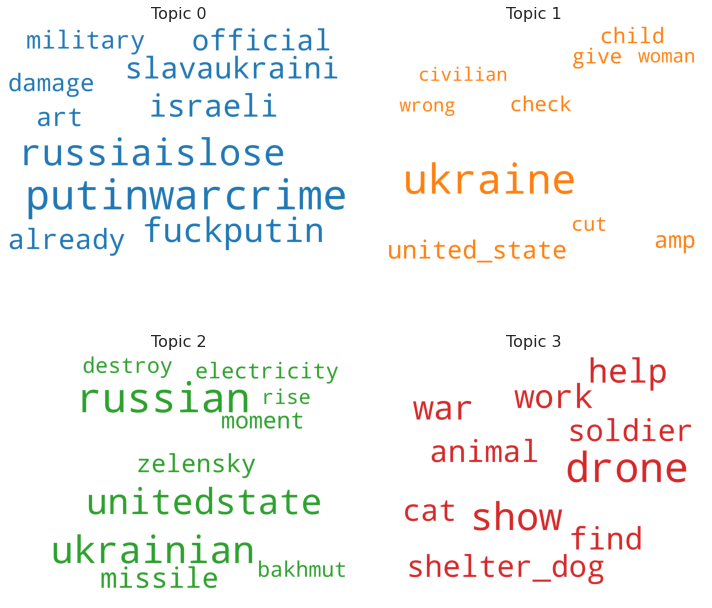

In [ ]:
wordcloud_per_topic(lda_model)

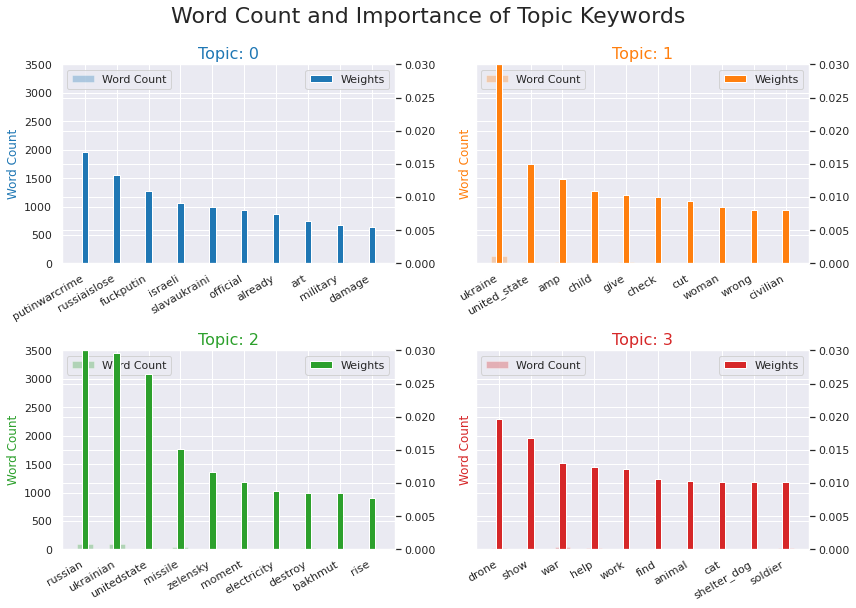

In [ ]:
word_count_per_topic(lda_model,data_ready)

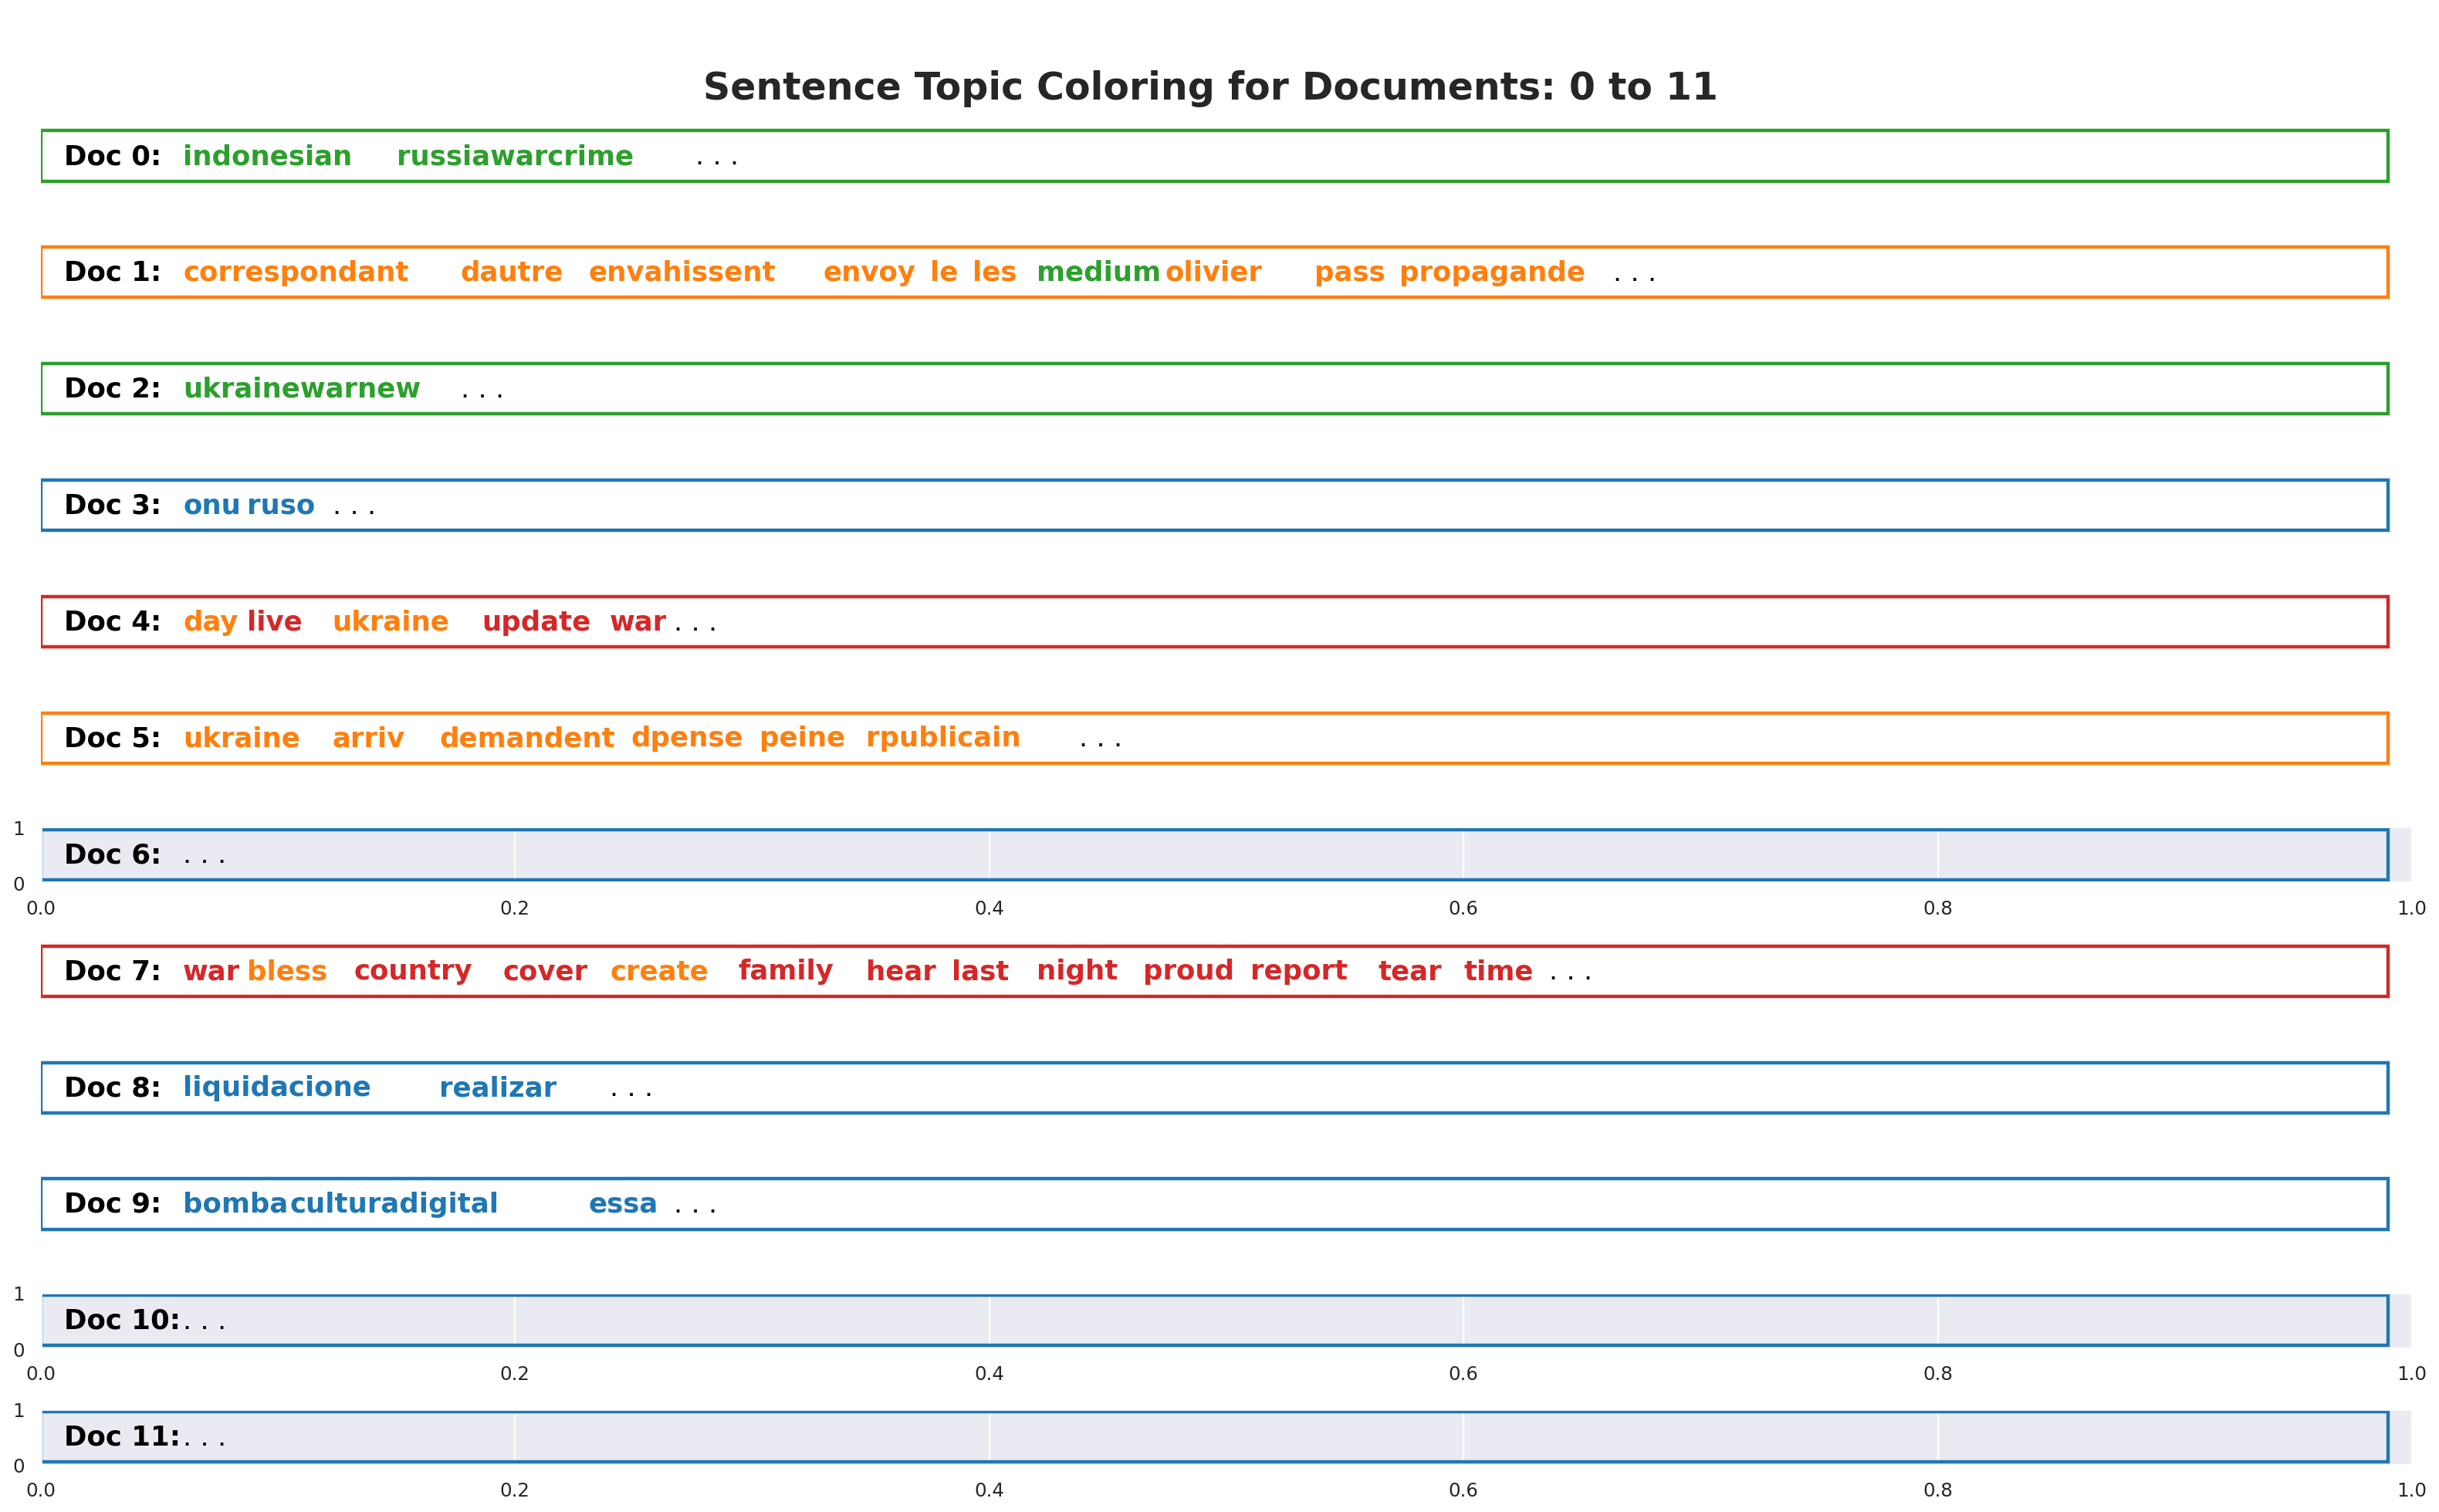

In [ ]:
sentences_chart(lda_model, corpus)   

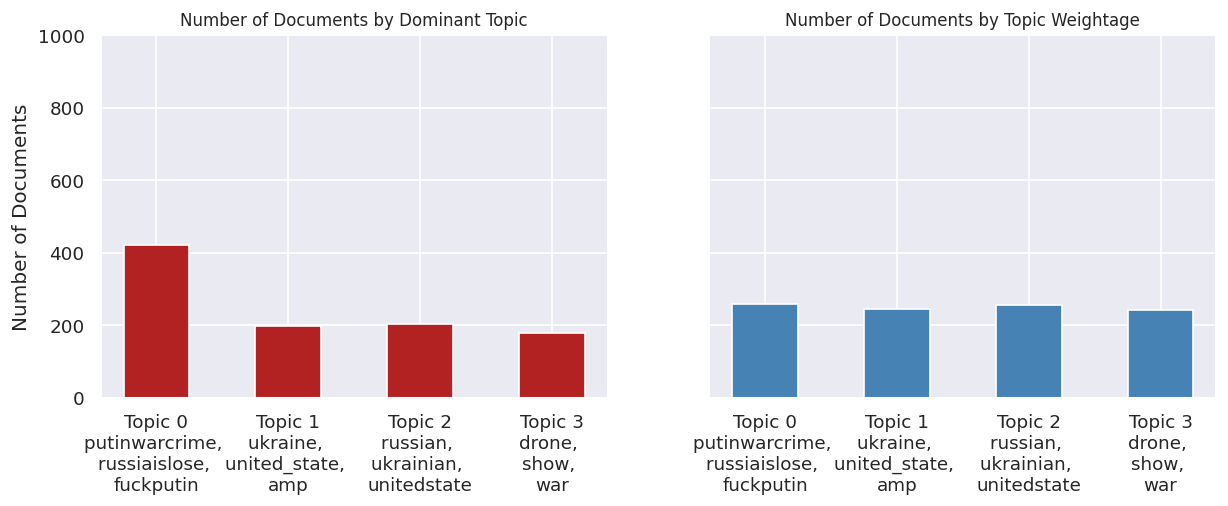

In [ ]:
topics_per_document_plot(lda_model, corpus)

In [ ]:
LDA_T_SNE_clustering(lda_model, corpus)

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 807 samples in 0.001s...
[t-SNE] Computed neighbors for 807 samples in 0.014s...
[t-SNE] Computed conditional probabilities for sample 807 / 807
[t-SNE] Mean sigma: 0.033718
[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.724792
[t-SNE] KL divergence after 1000 iterations: 0.292410


In [ ]:
vis = pyLDAis_plot(lda_model,corpus)
vis

/usr/local/lib/python3.8/dist-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.119363  0.147079       1        1  28.663446
3     -0.197341  0.047318       2        1  26.834633
1      0.044241 -0.158003       3        1  23.221202
0      0.033737 -0.036394       4        1  21.280718, topic_info=             Term       Freq      Total Category  logprob  loglift
17        ukraine  99.000000  99.000000  Default  30.0000  30.0000
55        russian  62.000000  62.000000  Default  29.0000  29.0000
61      ukrainian  51.000000  51.000000  Default  28.0000  28.0000
107   unitedstate  46.000000  46.000000  Default  27.0000  27.0000
172         drone  32.000000  32.000000  Default  26.0000  26.0000
...           ...        ...        ...      ...      ...      ...
239         write   5.271203   7.778092   Topic4  -5.4970   1.1583
2857      contain   4.675317   6.661373   Topic4  -5.6170   1.1933
2858      haaretz   4.675317   6.661373   Topic4  -5.6170   1.1933
2782       couple   4.808415   9.166874   Topic4  -5.5889   0.9021
66        provide   4.519018   6.647873   Topic4  -5.6510   1.1614

[180 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
1991      4  0.852848        ai
1430      1  0.147250     allow
1430      4  0.883497     allow
1313      4  0.985561   already
2227      1  0.120018   amazing
...     ...       ...       ...
127       3  0.978683     world
239       1  0.257132     write
239       4  0.642831     write
696       3  0.921297     wrong
245       1  0.966232  zelensky

[182 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 4, 2, 1])

#### Plots

##### 2022-11-18, Highest Ukraine favour count in November

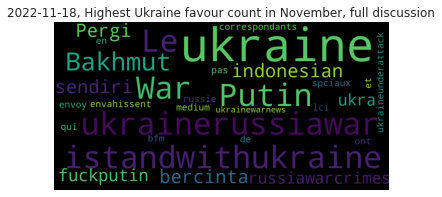

In [ ]:
# 2022-11-18, Highest Ukraine favour count in November
word_cloud(str(day_results["1118"]["text_part3"].apply(to_lemmatize)), title="2022-11-18, Highest Ukraine favour count in November, full discussion")

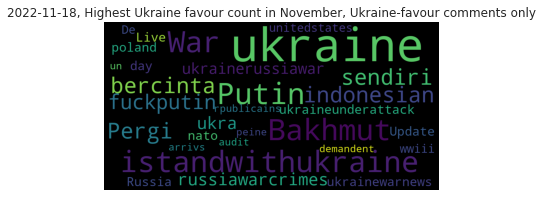

In [ ]:
# 2022-11-18, Highest Ukraine favour count in November
day_ret = day_results["1118"]
zoom_data = day_ret.loc[day_ret["favour_Ukraine"]==1]["text_part3"].apply(to_lemmatize)
word_cloud(str(zoom_data), title="2022-11-18, Highest Ukraine favour count in November, Ukraine-favour comments only")

###### Ukraine-favour comments & LDA

In [ ]:
# Acutal comments
ukraine_comments_1118_df = print_real_comments(day_results["1118"],favour="Ukraine")

Comment  0
Pergi bercinta sendiri, Putin!
(Indonesian)

#IStandWithUkraine #FuckPutin #RussiaWarCrimes #UkraineRussiaWar 

Comment  1
#Ukraine  #UkraineRussiaWar #UkraineUnderAttack #UkraineWarNews https://t.co/aAeXP6CsF2 

Comment  2
Ukraine - Russia War: Live War Update - 3, DAY 265
#NATO #Poland #UnitedStates #WWIII #Ukraine #
https://t.co/Kem6rP2Tfs 



In [ ]:
df_topic_sents_keywords,df_dominant_topic,lda_model,data_ready,corpus = LDA_topics(ukraine_comments_1118_df)
sent_topics_sorteddf_mallet = most_representative_sentence(df_topic_sents_keywords)


/usr/local/lib/python3.8/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


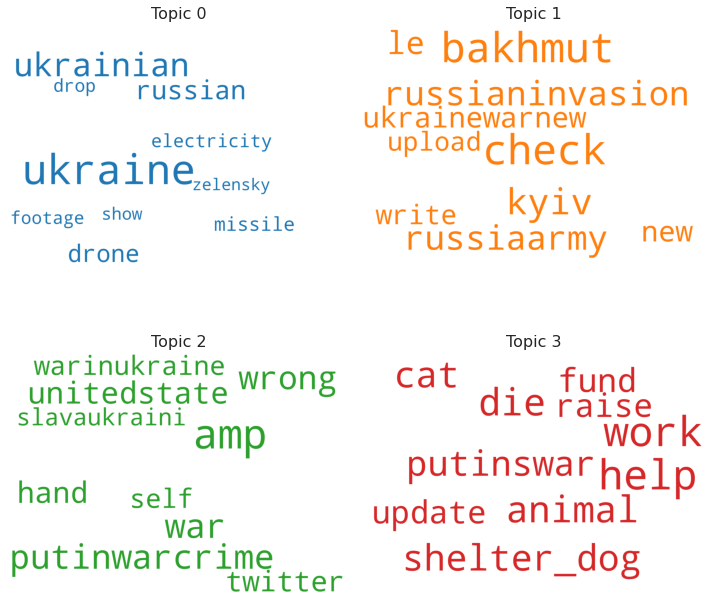

In [ ]:
wordcloud_per_topic(lda_model)

###### Russia-favour comments

In [ ]:
# Acutal comments
russia_comments_1118_df = print_real_comments(day_results["1118"],favour="Russia")

Comment  0
Les correspondants et envoyés spéciaux en #Russie qui envahissent les media #BFM #LCi ... ont passé des années à Moscou
MAIS ne parlent pas un mot de russe🤣🤡
Olivier Ravanello
Anne Nivat, épouse de JJ Bourdin
et d'autres
Qu'ont-ils fait là-bas? 🤪
#Poutine #Zelensky #propagande https://t.co/NFzGrmEWTO 

Comment  1
#Rusia y #Cuba estudian la posibilidad de realizar liquidaciones mutuas mediante #criptodivisas https://t.co/44VeF5IYjP 

Comment  2
Nada me tira da cabeça de que essa bomba na #Polônia foi uma espécie de "Rio Centro" dos #Ucranianos / #Zelensky. 
#JornaldaCultura
@tvcultura
#CulturaDigital 



##### 2022-11-15, a drop in Ukraine favour counts, and raise in Russia favour counts

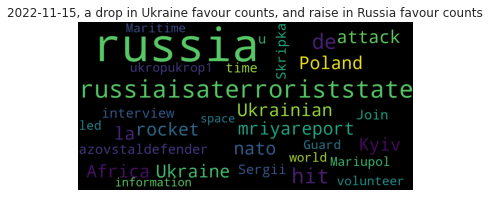

In [ ]:
# 2022-11-15, when Ukraine drop and Russia raise
word_cloud(str(day_results["1115"]["text_part3"].apply(to_lemmatize)), title="2022-11-15, a drop in Ukraine favour counts, and raise in Russia favour counts")

# We can see that might be the news about Russia/Ukraine war missles hitting Poland, cause the audience to blame on each side of the war
# Oh, ok it's this news, so NATO suggested Ukrainian missile hit Poland
# Russia-Ukraine war: Zelenskiy dismisses Nato’s suggestion missile that hit Poland was Ukrainian – as it happened
#https://www.theguardian.com/world/live/2022/nov/16/russia-ukraine-war-live-news-emergency-g20-meeting-after-russian-made-missiles-land-in-poland

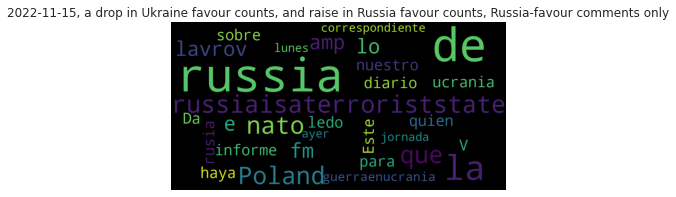

In [ ]:
# 2022-11-15, when Ukraine drop and Russia raise
day_ret = day_results["1115"]
zoom_data = day_ret.loc[day_ret["favour_Russia"]==1]["text_part3"].apply(to_lemmatize)
word_cloud(str(zoom_data), title="2022-11-15, a drop in Ukraine favour counts, and raise in Russia favour counts, Russia-favour comments only")

###### Russia-favour comments

In [ ]:
# Acutal comments
russia_comments_1115_df = print_real_comments(day_results["1115"],favour="Russia",top=10)

Comment  0
🇷🇺🔥🇺🇦 #Rusia Vs #Ucrania - Día 265 - Este es, para quien no lo haya leído, nuestro informe diario sobre la #GuerraEnUcrania correspondiente a la jornada de ayer, lunes 14 de noviembre de 2022.

https://t.co/relgS9zc5k 

Comment  1
@Kronprinsparet For more than nine months russia is killing Ukrainians and destroying their cities and homes (264 days).
This leaves kids without parents. We implore you to declare russia a terrorist state.
#russiaisaterroriststate https://t.co/kenXvnYEJy 

Comment  2
@MID_RF Dear mr #Lavrov, did you noticed the complete lack of respect by anyone important? They may smile at you, but realize: you ruined #Russia, military, economically &amp; politically, you are the risee of the world, you are only laughed at. Best advice: dump Putin &amp; get out of #Ukrain 

Comment  3
De confirmarse esta noticia que espero que no sea cierta, aunque me temo lo peor, el escenario que se presenta es espeluznante #Przewodow 
#Russia 
#Poland 
#OTAN 

Comment  4
Un au

In [ ]:
df_topic_sents_keywords,df_dominant_topic,lda_model,data_ready,corpus = LDA_topics(russia_comments_1115_df)
sent_topics_sorteddf_mallet = most_representative_sentence(df_topic_sents_keywords)

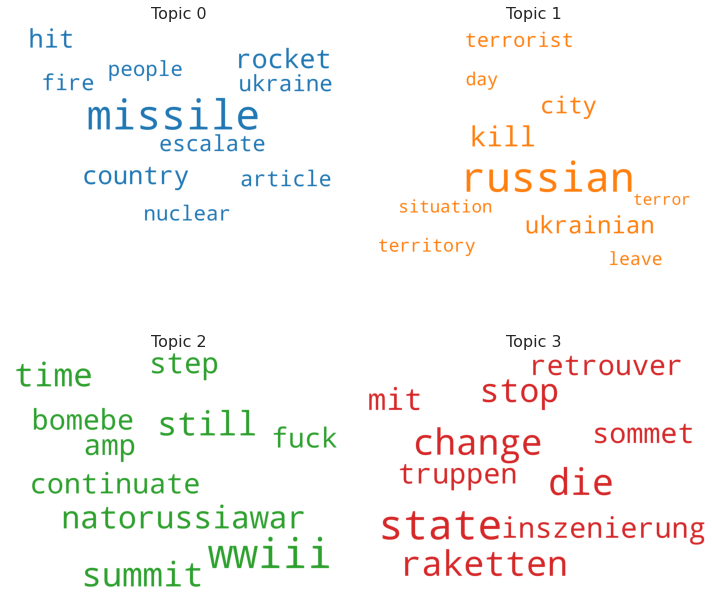

In [ ]:
wordcloud_per_topic(lda_model)

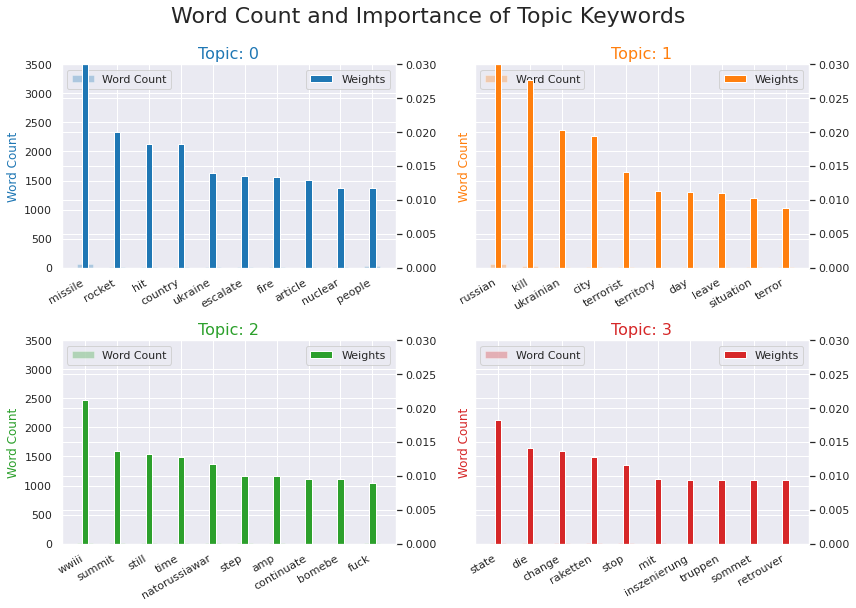

In [ ]:
word_count_per_topic(lda_model,data_ready)

##### 2022-11-21, a drop in Ukraine favour counts, and raise in Neutral favour counts

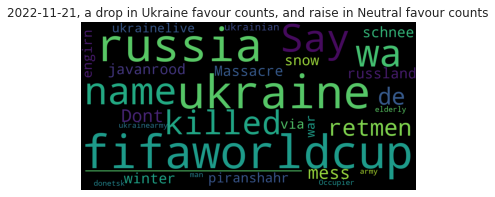

In [ ]:
# 2022-11-21, when Ukraine drop and Neutral raise
word_cloud(str(day_results["1121"]["text_part3"].apply(to_lemmatize)), title="2022-11-21, a drop in Ukraine favour counts, and raise in Neutral favour counts")

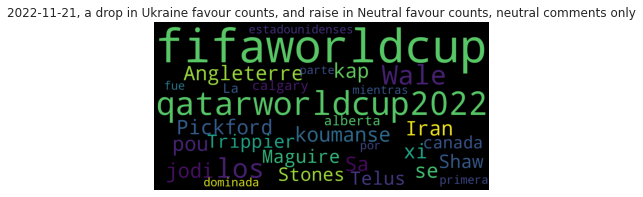

In [ ]:
# 2022-11-21, when Ukraine drop and Neutral raise
day_ret = day_results["1121"]
zoom_data = day_ret.loc[(day_ret["favour_Russia"]==0) & (day_ret["favour_Ukraine"]==0)]["text_part3"].apply(to_lemmatize)
word_cloud(str(zoom_data), title="2022-11-21, a drop in Ukraine favour counts, and raise in Neutral favour counts, neutral comments only")

# So looks like a heavy distraction from the FIFA worldcup 2022

###### Neutral Comments

In [ ]:
neutral_comments_1121_df = print_real_comments(day_results["1121"],favour="Neutral")

Comment  0
Sa se XI kap koumanse pou Angleterre 🏴󠁧󠁢󠁥󠁮󠁧󠁿 jodi a 🆚 Iran 🇮🇷: 👀👇🏿

Pickford - Trippier, Maguire, Stones, Shaw - Rice, Bellingham, Mount - Saka, Kane, Sterling.

#FIFAWorldCup  #Qatar2022 

Comment  1
Побывал в центральном офисе Telus. Что скажите про такое оформление?
#Канада #Калгари #Альберта #Canada #Calgary #Alberta https://t.co/UW2iqNHT57 

Comment  2
#QatarWorldCup2022 | La primera parte fue dominada por los estadounidenses, mientras que los europeos encontraron su mejor momento en la complementaria.

https://t.co/NcyuGpNPOg 



In [ ]:
df_topic_sents_keywords,df_dominant_topic,lda_model,data_ready,corpus = LDA_topics(ukraine_comments_1118_df)
sent_topics_sorteddf_mallet = most_representative_sentence(df_topic_sents_keywords)

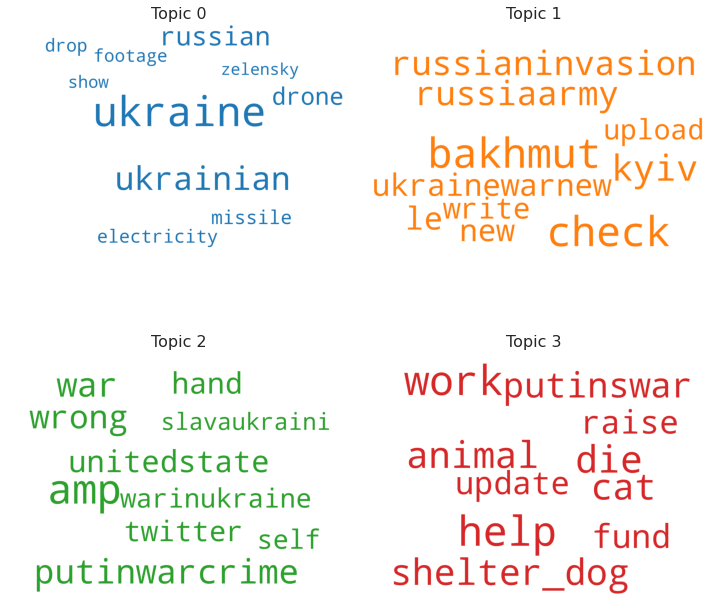

In [ ]:
wordcloud_per_topic(lda_model)

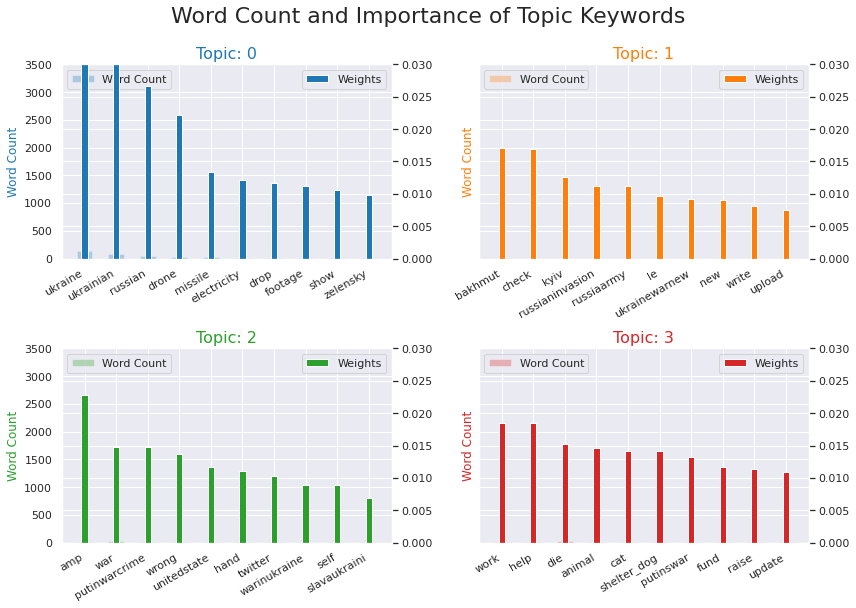

In [ ]:
word_count_per_topic(lda_model,data_ready)
# So seems Topic:0 is professional no-bias news reports about this:
# https://www.ndtv.com/world-news/russia-ukraine-war-russia-urges-global-response-over-strikes-on-ukraine-nuclear-plant-3539840

# Topic:1 is professional no-bias reports for Bakhmut city like:
# Why the battle for the small city of Bakhmut is so important to both Russia and Ukraine
# https://www.cbc.ca/news/world/ukraine-war-russia-bakhmut-1.6670438


# Topic:2 is more like animal supporters,
# posting their own contents while inlcuding the tag #putinwarcrime be cause they are highly correlated group of people
# For which, judge by the contents only, is not biased

# Topic:3 is official no-bias reports, or no-bias discussion of 
# Russia to build attack drones for Ukraine war with the help of Iran, intelligence assessment says
# https://www.cnn.com/2022/11/21/politics/russia-iran-drones-intel-assessment

# We can see that this drop is caused by multiple reasons, mainly because of swarm of new news coming in, and the nuclear plant strike news.

In [ ]:
vis = pyLDAis_plot(lda_model,corpus)
vis

/usr/local/lib/python3.8/dist-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.182096 -0.088498       1        1  32.434627
2      0.027640  0.087198       2        1  24.555993
3      0.164572 -0.105973       3        1  23.234806
1     -0.010116  0.107274       4        1  19.774573, topic_info=             Term       Freq      Total Category  logprob  loglift
5         ukraine  87.000000  87.000000  Default  30.0000  30.0000
42      ukrainian  50.000000  50.000000  Default  29.0000  29.0000
36        russian  31.000000  31.000000  Default  28.0000  28.0000
289           amp  20.000000  20.000000  Default  27.0000  27.0000
104         drone  25.000000  25.000000  Default  26.0000  26.0000
...           ...        ...        ...      ...      ...      ...
1688          art   3.831523   5.933295   Topic4  -5.2047   1.1835
1837          pmc   3.837367   7.245285   Topic4  -5.2032   0.9852
1838           rd   3.837367   7.245285   Topic4  -5.2032   0.9852
1839       wagner   3.837367   7.245285   Topic4  -5.2032   0.9852
1840  wagnergroup   3.837367   7.245285   Topic4  -5.2032   0.9852

[172 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
956       4  0.837904     allow
815       2  0.891580   already
1834      1  0.122277   amazing
1834      2  0.733664   amazing
1834      4  0.122277   amazing
...     ...       ...       ...
214       2  0.933573     world
1426      4  0.937295     write
510       2  0.955189     wrong
149       1  0.933916  zelensky
288       3  0.888907        zu

[169 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 4, 2])

###### Russia-favour comments

In [ ]:
# Acutal comments
russia_comments_1121_df = print_real_comments(day_results["1121"],favour="Russia")

Comment  0
Don´t mess with Russia  🇷🇺
_________________________

#Russland #Russia #Ukraine #WINTER #Schnee #snow https://t.co/p0L79Yc5Vr 

Comment  1
Say their name!
Massacre in  
#Javanrood 
#Piranshahr 
#FIFAWorldCup 
#ENGIRN 

Comment  2
Rubrik: Sie reden, wir müssen schämen 

Leihmutterschaft wird verwendet, um biologische Waffen herzustellen, sagte Anna Kuznezowa, stellvertretende Vorsitzende der Staatsduma 👇👇👇 

Propaganda in #Russland 🤯 https://t.co/GmnXkRe27o 



#### Hawkeye: Insights

We can see that by using our SNS-hawkeye analysis tools, government or companies can:

1. Trace the real-time SNS attitude trending on a given topic, here we show the topic of supporting Ukraine or Russia.
2. And we are able to identify the specific topic or reasoning behind each raise and drop, helping the customer to pin-point the exact cause and be always ready to take action and response.

## Product: Proofreader

Product line #2

**Proofreader**

1. Select some major influencer, or Ukrain official twitter accounts to work on:
  1. Pick twitts from them with

    a. Long enough text on original twitt

    b. More replies (~1000)

    c. Something that’s a bit of debate-able

2. Apply Entity-based sentiment model to calculate scores based on ratio of positive replies toward Ukraine (reuse part3-hawkeye code), e.g. favour_score = favour_Ukraine / total replies. 

3. Apply bag of word to the original official twitts, use regression model (bow -> predict favour_score ) on the bow to see which wording contributes positively/negatively to the prediction. This is done by sort by top pos/neg coef_ from the model.

4. Visualize -> wordcloud, a bar graph of feature importance sorted, 

Our end product will be:

**proofreader official**: The regression model -> help proofread Ukraine official accounts' posts.

**proofreader influencer**: The regression model -> help proofread related influencers' posts.

**proofreader hints**: Wordcloud to aid word choice while composing.



### load data directly from a saved file

In [ ]:
# Or, load it directly from Google Drive
# Mount GD
from google.colab import drive
drive.mount('/content/drive')

# Load data from csv to pandas
import pandas as pd
import numpy as np

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Dataset#1: Elon Musk

./data/part_3/twitter_elon_musk/tw.csv

./data/part_3/twitter_elon_musk/tw_reply.csv

In [ ]:
# Path to dataset file
data_path = project_path+'data/part_3/twitter_elon_musk/' # change path to your drive location

elon_main_tweets = pd.read_csv(data_path+'tw.csv',low_memory=False) 
elon_replies = pd.read_csv(data_path+'tw_reply.csv',low_memory=False)
elon_main_tweets.head()

id                created_at  \
0  1576994262226702336  2022-10-03T17:55:05.000Z   
1  1576973049277992974  2022-10-03T16:30:48.000Z   
2  1576970924968247297  2022-10-03T16:22:21.000Z   
3  1576969255031296000  2022-10-03T16:15:43.000Z   
4  1577853138157158402  2022-10-06T02:47:57.000Z   

                                                                                                                                                                                                                                                                                              text  \
0                                                                                                                                                          Let’s try this then: the will of the people who live in the Donbas &amp; Crimea should decide whether they’re part of Russia or Ukraine   
1                                                                                                                                                                                                    Also worth noting that a possible, albeit unlikely, outcome from this conflict is nuclear war   
2                                                                                                                                                                                                 This is highly likely to be the outcome in the end – just a question of how many die before then   
3  Ukraine-Russia Peace:\n\n- Redo elections of annexed regions under UN supervision. Russia leaves if that is will of the people.\n\n- Crimea formally part of Russia, as it has been since 1783 (until Khrushchev’s mistake).\n\n- Water supply to Crimea assured.\n\n- Ukraine remains neutral.   
4                                                                                                         @bdquinn @LindseyGrahamSC Kherson and Zaporizhzhia almost certainly do not want to join Russia – annexation of those regions was done to ensure a land bridge and water supply to Crimea   

   retweet_count  reply_count  like_count  
0          17804        92570       96882  
1           4706        11395       73415  
2           4775        10016       85169  
3          20866       118148       98100  
4            341         2236        5064

In [ ]:
elon_replies.head()

created_at  \
0  2022-10-06T23:58:47.000Z   
1  2022-10-06T23:57:17.000Z   
2  2022-10-06T23:57:11.000Z   
3  2022-10-06T23:56:25.000Z   
4  2022-10-06T23:53:49.000Z   

                                                                                                                                                                                                                                                                                              text  \
0                                                              @elonmusk This is truly foolish, Elon. Your own life experience should have taught you better.\nIf you choose to live in a country other than your own, then become a part of it. Don’t try to change it to your country of origin.   
1                                                                                                                                                                                                                                                                          @elonmusk Stop the war!   
2  @elonmusk After Einstein became famous, reporters started interviewing him on topics ranging from quantum mechanics to politics, daily events, and everything in between.\n\nEinstein had the humbleness to politely decline answering questions on topics unrelated to his areas of expertise.   
3                                                                                                                                                       @elonmusk That’s Ukrainian business. Not yours or Russia. If you disagree you are an imperialist. Just like Catalonia is Spain’s business.   
4                                  @elonmusk your position is phenomenal\n\nthe opinion of the Western world on any issue is based on fear\n\neither your resources or talent allow you to be above the situation\n\nI think this is a turning point when everything in the world gets upside down   

   in_reply_to_tweet_id  retweet_count  reply_count  like_count  
0   1576994262226702336              0            0           0  
1   1576994262226702336              0            0           0  
2   1576994262226702336              1            3          13  
3   1576994262226702336              0            0           0  
4   1576994262226702336              1            0           0

#### Dataset#2 Official Ukraine twitter account (@Ukraine)

./data/part_3/twitter_Ukraine_Official/Ukraine_main_tweets.csv

./data/part_3/twitter_Ukraine_Official/reply_to_Ukraine.csv

In [ ]:
# Path to dataset file
data_path = project_path+'data/part_3/twitter_Ukraine_Official/' # change path to your drive location

ukraine_main_tweets = pd.read_csv(data_path+'Ukraine_main_tweets.csv',low_memory=False) 
ukraine_replies = pd.read_csv(data_path+'reply_to_Ukraine.csv',low_memory=False)
# To keep consistency
ukraine_replies["text"]=ukraine_replies["Tweet"]
ukraine_main_tweets.head()

Unnamed: 0                   id  \
0           0  1596595517731270656   
1           1  1595865696231383040   
2           2  1595471055187243008   
3           3  1591485022799904768   
4           4  1591187183217831936   

                                                                                                                                                                                                                                                        text  
0  🕯Today we honor the memory of innocent victims of the Holodomor genocide. Using hunger as a weapon, Stalin deliberately starved millions of Ukrainians in 1932-1933. Russia’s current genocidal war against Ukraine echoes this Soviet crime of the past.  
1                                                                             On this Thanksgiving, we thank the U.S. and the American people for standing with Ukraine 🇺🇦🇺🇸        #Thanksgiving2022 🦃                        for       #HIMARSgiving2022 🚀  
2                                                                                                                                                                                       Power, water, and heating will be restored. Russian empire will not.  
3                                                                                                                        liberation is easy to spot hereRussian army        Ukrainian armyenters Kherson     enters Khersonspring 2022           autumn 2022  
4                       as promised                    Fellow Ukrainians in the areas temporarily occupied by Russia: Ukraine misses you, Ukraine fights for you, Ukraine will soon be back!Kherson is Ukraine 💛💙art by Marichka Rubanhttps://mariaruban.com

In [ ]:
ukraine_replies.head()

Unnamed: 0  Unnamed: 0.1                   ID  \
0           0             0  1598824973363122176   
1           1             1  1598741363419336709   
2           2             2  1598622485036949505   
3           3             3  1598427419329036294   
4           4             4  1598427163354603536   

                                                                                                                                                                                                                                                                                                                          Tweet  \
0                                                                                                                                                                                                                                               @Ukraine Nice nice, let’s also honor the Volyn genocide (1943) what do you say?   
1                                                                                                                                                                                     @Ukraine Banning news stations, political parties, and now religious organizations suck as the ukranian orthodox church. Absolute garbage   
2                                                                                                                                                                                                                                                                     @Ukraine Please choose a proposal for peace with Russia..   
3                                                                                                                                                                                                                                                                           @Ukraine And Stalin 20 million of his own citizens.   
4  @Ukraine I do agree that Russian people are not European their behavior is more Asian like Imperial Japan (in China &amp; POW's), Mao Zedong (50- 70 million), Pol Pot (2 million), Putin (2 Chechen wars, Georgian war, 2 wars Ukraine) or Xi Jinping (Chinese virus). 1 non Asian Hitler Socialist https://t.co/k2vMAcC5sG   

                 Date Posted      conversation_id        Author ID  Liked  \
0  2022-12-02 23:42:33+00:00  1596595517731270656        PeakyPony      0   
1  2022-12-02 18:10:18+00:00  1596595517731270656  KerberosS0ldier      0   
2  2022-12-02 10:17:56+00:00  1596595517731270656  MelodyStarHolly      0   
3  2022-12-01 21:22:48+00:00  1596595517731270656      KnefelKevin      0   
4  2022-12-01 21:21:47+00:00  1596595517731270656      KnefelKevin      0   

   Reply  Retweet  in_reply_to_tweet_id  \
0      0        0   1596595517731270656   
1      0        0   1596595517731270656   
2      1        0   1596595517731270656   
3      0        0   1596595517731270656   
4      0        0   1596595517731270656   

                                                                                                                                                                                                                                                                                                                           text  
0                                                                                                                                                                                                                                               @Ukraine Nice nice, let’s also honor the Volyn genocide (1943) what do you say?  
1                                                                                                                                                                                     @Ukraine Banning news stations, political parties, and now religious organizations suck as the ukranian orthodox church. Absolute garbage  
2                                                              

##### Semi-manual scraping codes
Due to twitter API restriction, we only able to search last 7 day tweets.

(Just a showcase, this section commented out so won't interrupt the main flow)

In [ ]:
#!pip install git+https://github.com/tweepy/tweepy.git

In [ ]:
"""
import csv
import tweepy
# import Python modules to work with Twitter data
import pandas as pd
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
# Oauth keys
consumer_key = "xxx"
consumer_secret = "xxx"
access_token = "xx-xx%xx"
access_token_secret = "xxxx"

bearer_token = "xx%xx"

# Twitter API v2 Client
# put your credentials in tweepy.Client to authenticate your account
client = tweepy.Client(consumer_key=consumer_key,
                       consumer_secret=consumer_secret,
                       access_token=access_token,
                       access_token_secret = access_token_secret,
                       bearer_token=bearer_token,
                       wait_on_rate_limit=True)


# hand collected tweet IDs from Ukraine
Ukraine_official_posts = [1596595517731270656, 1595865696231383040, 1595471055187243008, 1591485022799904768, 1591195763010215936, 1591187183217831936, 
                          1584573060065427456, 1583487214079553536, 1583007153958584320, 1581368648765419520, 1579832275919056896, 1579474177622700033]

for post_id in Ukraine_official_posts:

    uoft_search = client.search_recent_tweets(
        query="in_reply_to_tweet_id:"+str(post_id)+" -is:retweet lang:en", # Extract non-retweeted English tweets
        max_results=100, 
        expansions=["author_id"],
        tweet_fields= ["created_at,conversation_id,public_metrics"])

    if uoft_search.data is None:
      print("Empty results for ",post_id)
    else:
      # create our data set
      data = []

      # set the columns
      columns = ['ID', 'Tweet', "Date Posted","conversation_id",'Author ID', 'Liked', 'Reply', 'Retweet']

      # create a dictionary that will use the author_id field to look up more information 
      # about the users
      uoft_users = {user['id']: user for user in uoft_search.includes['users']}

      # add the data from our retieval to the data set
      for tweet in uoft_search.data:
          if uoft_users[tweet.author_id]:
              user = uoft_users[tweet.author_id]
              data.append([tweet.id, 
                          tweet.text, 
                          tweet.created_at,
                          tweet.conversation_id,
                          user.username,  
                          tweet.public_metrics['like_count'], 
                          tweet.public_metrics['reply_count'],
                          tweet.public_metrics['retweet_count']])
          
      # create the dataframe
      uoft_df = pd.DataFrame(data, columns=columns )
      uoft_df.to_csv("reply_to_"+str(post_id)+"_2.csv")


import os

load_path = "/content/drive/MyDrive/UofT_MEng/MIE1624/Project/data/part_3/twitter_Ukraine_Official/"
full_list = []
for post_id in Ukraine_official_posts:
  inner_list = []
  if(os.path.exists(load_path+"reply_to_"+str(post_id)+".csv")):
    df1 = pd.read_csv(load_path+"reply_to_"+str(post_id)+".csv")
    inner_list.append(df1)
  if(os.path.exists(load_path+"reply_to_"+str(post_id)+"_2.csv")):
    df2 = pd.read_csv(load_path+"reply_to_"+str(post_id)+"_2.csv")
    inner_list.append(df2)

  if(inner_list):
    concat_df_inner = pd.concat(inner_list).drop_duplicates().reset_index(drop=True)
    concat_df_inner["in_reply_to_tweet_id"] = post_id
    full_list.append(concat_df_inner)

full_official_data =  pd.concat(full_list)

full_official_data
"""

'\nimport csv\nimport tweepy\n# import Python modules to work with Twitter data\nimport pandas as pd\nimport ssl\nssl._create_default_https_context = ssl._create_unverified_context\n# Oauth keys\nconsumer_key = "xxx"\nconsumer_secret = "xxx"\naccess_token = "xx-xx%xx"\naccess_token_secret = "xxxx"\n\nbearer_token = "xx%xx"\n\n# Twitter API v2 Client\n# put your credentials in tweepy.Client to authenticate your account\nclient = tweepy.Client(consumer_key=consumer_key,\n                       consumer_secret=consumer_secret,\n                       access_token=access_token,\n                       access_token_secret = access_token_secret,\n                       bearer_token=bearer_token,\n                       wait_on_rate_limit=True)\n\n\n# hand collected tweet IDs from Ukraine\nUkraine_official_posts = [1596595517731270656, 1595865696231383040, 1595471055187243008, 1591485022799904768, 1591195763010215936, 1591187183217831936, \n                          1584573060065427456, 15834

### Feature Engineering for pre-trained models

Some pre-trained models takes cased text.

In [ ]:
# for case models 
elon_main_tweets_proc = fe_pipeline(elon_main_tweets,"text","part3_pr")
elon_replies_proc = fe_pipeline(elon_replies,"text","part3")

elon_replies_proc[["text","text_part3"]].head()

text  \
0                                                              @elonmusk This is truly foolish, Elon. Your own life experience should have taught you better.\nIf you choose to live in a country other than your own, then become a part of it. Don’t try to change it to your country of origin.   
1                                                                                                                                                                                                                                                                          @elonmusk Stop the war!   
2  @elonmusk After Einstein became famous, reporters started interviewing him on topics ranging from quantum mechanics to politics, daily events, and everything in between.\n\nEinstein had the humbleness to politely decline answering questions on topics unrelated to his areas of expertise.   
3                                                                                                                                                       @elonmusk That’s Ukrainian business. Not yours or Russia. If you disagree you are an imperialist. Just like Catalonia is Spain’s business.   
4                                  @elonmusk your position is phenomenal\n\nthe opinion of the Western world on any issue is based on fear\n\neither your resources or talent allow you to be above the situation\n\nI think this is a turning point when everything in the world gets upside down   

                                                                                                                                                                                                                                                                                        text_part3  
0                                                               @elonmusk This is truly foolish, Elon. Your own life experience should have taught you better.\nIf you choose to live in a country other than your own, then become a part of it. Dont try to change it to your country of origin.  
1                                                                                                                                                                                                                                                                          @elonmusk Stop the war!  
2  @elonmusk After Einstein became famous, reporters started interviewing him on topics ranging from quantum mechanics to politics, daily events, and everything in between.\n\nEinstein had the humbleness to politely decline answering questions on topics unrelated to his areas of expertise.  
3                                                                                                                                                         @elonmusk Thats Ukrainian business. Not yours or Russia. If you disagree you are an imperialist. Just like Catalonia is Spains business.  
4                                  @elonmusk your position is phenomenal\n\nthe opinion of the Western world on any issue is based on fear\n\neither your resources or talent allow you to be above the situation\n\nI think this is a turning point when everything in the world gets upside down

In [ ]:
# for case models 
ukraine_main_tweets_proc = fe_pipeline(ukraine_main_tweets,"text","part3_pr")
ukraine_replies_proc = fe_pipeline(ukraine_replies,"text","part3")

ukraine_replies_proc[["text","text_part3"]].head()

text  \
0                                                                                                                                                                                                                                               @Ukraine Nice nice, let’s also honor the Volyn genocide (1943) what do you say?   
1                                                                                                                                                                                     @Ukraine Banning news stations, political parties, and now religious organizations suck as the ukranian orthodox church. Absolute garbage   
2                                                                                                                                                                                                                                                                     @Ukraine Please choose a proposal for peace with Russia..   
3                                                                                                                                                                                                                                                                           @Ukraine And Stalin 20 million of his own citizens.   
4  @Ukraine I do agree that Russian people are not European their behavior is more Asian like Imperial Japan (in China &amp; POW's), Mao Zedong (50- 70 million), Pol Pot (2 million), Putin (2 Chechen wars, Georgian war, 2 wars Ukraine) or Xi Jinping (Chinese virus). 1 non Asian Hitler Socialist https://t.co/k2vMAcC5sG   

                                                                                                                                                                                                                                                                                              text_part3  
0                                                                                                                                                                                                                         @Ukraine Nice nice, lets also honor the Volyn genocide (1943) what do you say?  
1                                                                                                                                                              @Ukraine Banning news stations, political parties, and now religious organizations suck as the ukranian orthodox church. Absolute garbage  
2                                                                                                                                                                                                                                              @Ukraine Please choose a proposal for peace with Russia..  
3                                                                                                                                                                                                                                                    @Ukraine And Stalin 20 million of his own citizens.  
4  @Ukraine I do agree that Russian people are not European their behavior is more Asian like Imperial Japan (in China &amp; POW's), Mao Zedong (50- 70 million), Pol Pot (2 million), Putin (2 Chechen wars, Georgian war, 2 wars Ukraine) or Xi Jinping (Chinese virus). 1 non Asian Hitler Socialist

### Run models

#### A dipping test

We adjust the threshold based on the dipping tests.

##### Elon Musk

In [ ]:
candidate_labels = ['Ukraine', 'Russia']

for idx, data_row in tqdm(elon_replies_proc.iterrows(), total=elon_replies_proc.shape[0]):
  pipe_ret = pipe(data_row["text_part3"], candidate_labels)  

  print("\n",data_row["text"])
  print(pipe_ret["labels"],pipe_ret["scores"])  

  if(idx>15):
    break

  0%|          | 0/336905 [00:00<?, ?it/s]


 @elonmusk This is truly foolish, Elon. Your own life experience should have taught you better.
If you choose to live in a country other than your own, then become a part of it. Don’t try to change it to your country of origin.
['Ukraine', 'Russia'] [0.5501073002815247, 0.44989272952079773]

 @elonmusk Stop the war!
['Russia', 'Ukraine'] [0.5318729281425476, 0.4681270718574524]

 @elonmusk After Einstein became famous, reporters started interviewing him on topics ranging from quantum mechanics to politics, daily events, and everything in between.

Einstein had the humbleness to politely decline answering questions on topics unrelated to his areas of expertise.
['Ukraine', 'Russia'] [0.6175583004951477, 0.3824416399002075]

 @elonmusk That’s Ukrainian business. Not yours or Russia. If you disagree you are an imperialist. Just like Catalonia is Spain’s business.
['Ukraine', 'Russia'] [0.988135814666748, 0.011864161118865013]

 @elonmusk your position is phenomenal

the opinion of the We

##### Ukraine official

In [ ]:
for idx, data_row in tqdm(ukraine_replies_proc.iterrows(), total=ukraine_replies_proc.shape[0]):
  pipe_ret = pipe(data_row["text_part3"], candidate_labels)  

  print("\n",data_row["text"])
  print(pipe_ret["labels"],pipe_ret["scores"])  

  if(idx>10):
    break

  0%|          | 0/273 [00:00<?, ?it/s]


 @Ukraine Nice nice, let’s also honor the Volyn genocide (1943) what do you say?
['Ukraine', 'Russia'] [0.9984728097915649, 0.0015271955635398626]

 @Ukraine Banning news stations, political parties, and now religious organizations suck as the ukranian orthodox church. Absolute garbage
['Ukraine', 'Russia'] [0.9991958141326904, 0.0008041446562856436]

 @Ukraine Please choose a proposal for peace with Russia..
['Ukraine', 'Russia'] [0.8129705786705017, 0.1870294213294983]

 @Ukraine And Stalin 20 million of his own citizens.
['Ukraine', 'Russia'] [0.995330274105072, 0.00466969283297658]

 @Ukraine I do agree that Russian people are not European their behavior is more Asian like Imperial Japan (in China &amp; POW's), Mao Zedong (50- 70 million), Pol Pot (2 million), Putin (2 Chechen wars, Georgian war, 2 wars Ukraine) or Xi Jinping (Chinese virus). 1 non Asian Hitler Socialist https://t.co/k2vMAcC5sG
['Ukraine', 'Russia'] [0.6630819439888, 0.33691805601119995]

 @Ukraine You will be def

#### Final runs

Each run for a full day's data takes about 6 hrs even with the skip on a premium GPU colab setting.

The code took 47.36835980415344 seconds to run 100 samples.

So a reasonable choice is to run a smaller-sized sample for each day. We pick the sample size = 1000.

##### Elon Musk

In [ ]:
# Make a local folder
!mkdir part3_elon_twitter_scores_1000_sample_replies

mkdir: cannot create directory ‘part3_elon_twitter_scores_1000_sample_replies’: File exists


In [ ]:
# Uncomment to run, this takes about 3.5 hrs on premium GPU colab
# Or directly load the results in later section
"""
import os

candidate_labels = ['Ukraine', 'Russia']
# only record favour count if score difference > theshold
threshold = 0.2
# max number of samples we randomly select from each twitters' replies
sample_size = 1000

start_time = time.time()

# For each main tweets
for main_idx, main_tweet in elon_main_tweets_proc.iterrows():  
  print("Processing main_tweet#",main_idx)
  # get replies
  tweet_replies = elon_replies_proc[elon_replies_proc["in_reply_to_tweet_id"]==main_tweet["id"]]

  # Clean empty tweets, Nans after feature engineering
  tweet_replies['text_part3'].replace('', np.nan, inplace=True)
  tweet_replies = tweet_replies[tweet_replies['text_part3'].notna()]

  if(tweet_replies.shape[0]>1000):
    # If more than 1000 replies, sample 1000 with fixed seed
    sample_tweet_replies = tweet_replies.sample(n=sample_size, replace=False, random_state=42).copy()
    print("Sampling replies from ",tweet_replies.shape[0],"to ",sample_size)
  else:
    sample_tweet_replies = tweet_replies.copy()

  # enable columns
  sample_tweet_replies["favour_Ukraine"]=0
  sample_tweet_replies["favour_Russia"]=0  
  
  for idx, data_row in tqdm(sample_tweet_replies.iterrows(), total=sample_tweet_replies.shape[0]):
    tag_pre_check = obvious_tags(data_row["text_part3"])    

    if(tag_pre_check == 2):
      pipe_ret = pipe(data_row["text_part3"], candidate_labels)      
      if(abs(pipe_ret["scores"][0]-pipe_ret["scores"][1]) > threshold):
          sample_tweet_replies.at[idx,"favour_"+pipe_ret["labels"][0]]=1      

    elif(tag_pre_check == 0):
      sample_tweet_replies.at[idx,"favour_Ukraine"]=1
    elif(tag_pre_check == 1):
      sample_tweet_replies.at[idx,"favour_Russia"]=1    
  
  # Save to file backup (chunk by chunk since we might lose the session)
  sample_tweet_replies.to_csv('/content/part3_elon_twitter_scores_1000_sample_replies/tw_'+str(main_idx)+'_proc.csv', encoding='utf-8', index=False)

  # cp from tmp to GD
  os.system('cp "/content/part3_elon_twitter_scores_1000_sample_replies/tw_'+str(main_idx)+'_proc.csv" "/content/drive/MyDrive/UofT_MEng/MIE1624/Project/data/part_3/twitter_elon_musk/part3_elon_twitter_scores_1000_sample_replies/"')

  #break
  

print("\nThis code took", time.time() - start_time, "to run")

"""

'\nimport os\n\ncandidate_labels = [\'Ukraine\', \'Russia\']\n# only record favour count if score difference > theshold\nthreshold = 0.2\n# max number of samples we randomly select from each twitters\' replies\nsample_size = 1000\n\nstart_time = time.time()\n\n# For each main tweets\nfor main_idx, main_tweet in elon_main_tweets_proc.iterrows():  \n  print("Processing main_tweet#",main_idx)\n  # get replies\n  tweet_replies = elon_replies_proc[elon_replies_proc["in_reply_to_tweet_id"]==main_tweet["id"]]\n\n  # Clean empty tweets, Nans after feature engineering\n  tweet_replies[\'text_part3\'].replace(\'\', np.nan, inplace=True)\n  tweet_replies = tweet_replies[tweet_replies[\'text_part3\'].notna()]\n\n  if(tweet_replies.shape[0]>1000):\n    # If more than 1000 replies, sample 1000 with fixed seed\n    sample_tweet_replies = tweet_replies.sample(n=sample_size, replace=False, random_state=42).copy()\n    print("Sampling replies from ",tweet_replies.shape[0],"to ",sample_size)\n  else:\n  

In [ ]:
"""

# package them
full_tw_data_list=[]
for i in range(0,16):
  print('Merge /content/part3_elon_twitter_scores_1000_sample_replies/tw_'+str(i)+'_proc.csv')
  single_tw_data = pd.read_csv('/content/part3_elon_twitter_scores_1000_sample_replies/tw_'+str(i)+'_proc.csv', engine='python')
  full_tw_data_list.append(single_tw_data)

full_tw_data = pd.concat(full_tw_data_list)

full_tw_data

"""

"\n\n# package them\nfull_tw_data_list=[]\nfor i in range(0,16):\n  print('Merge /content/part3_elon_twitter_scores_1000_sample_replies/tw_'+str(i)+'_proc.csv')\n  single_tw_data = pd.read_csv('/content/part3_elon_twitter_scores_1000_sample_replies/tw_'+str(i)+'_proc.csv', engine='python')\n  full_tw_data_list.append(single_tw_data)\n\nfull_tw_data = pd.concat(full_tw_data_list)\n\nfull_tw_data\n\n"

In [ ]:
#full_tw_data.to_csv('/content/part3_elon_twitter_scores_1000_sample_replies/full_tw_proc.csv', encoding='utf-8', index=False)

In [ ]:
# Full Backpack
#!cp -a /content/part3_elon_twitter_scores_1000_sample_replies/. /content/drive/MyDrive/UofT_MEng/MIE1624/Project/data/part_3/twitter_elon_musk/part3_elon_twitter_scores_1000_sample_replies/
#!cp /content/part3_elon_twitter_scores_1000_sample_replies/full_tw_proc.csv /content/drive/MyDrive/UofT_MEng/MIE1624/Project/data/part_3/twitter_elon_musk/

##### Ukraine

For which we do not have too much samples, no need to sampling or run chunk by chunk per main_tweet (in case of colab session failure)

In [ ]:
# Make a local folder
!mkdir part3_ukraine_twitter_scores_replies

mkdir: cannot create directory ‘part3_ukraine_twitter_scores_replies’: File exists


In [ ]:
# Uncomment to run, this takes about 2 mins on premium GPU colab
# Or directly load the results in later section
"""
import os

candidate_labels = ['Ukraine', 'Russia']
# only record favour count if score difference > theshold
threshold = 0.2
# max number of samples we randomly select from each twitters' replies
sample_size = 1000

start_time = time.time()

sample_tweet_replies = ukraine_replies_proc.copy()

# enable columns
sample_tweet_replies["favour_Ukraine"]=0
sample_tweet_replies["favour_Russia"]=0  

for idx, data_row in tqdm(sample_tweet_replies.iterrows(), total=sample_tweet_replies.shape[0]):
  tag_pre_check = obvious_tags(data_row["text_part3"])    

  if(tag_pre_check == 2):
    pipe_ret = pipe(data_row["text_part3"], candidate_labels)      
    if(abs(pipe_ret["scores"][0]-pipe_ret["scores"][1]) > threshold):
        sample_tweet_replies.at[idx,"favour_"+pipe_ret["labels"][0]]=1      

  elif(tag_pre_check == 0):
    sample_tweet_replies.at[idx,"favour_Ukraine"]=1
  elif(tag_pre_check == 1):
    sample_tweet_replies.at[idx,"favour_Russia"]=1    

  
# Save to file backup (chunk by chunk since we might lose the session)
sample_tweet_replies.to_csv('/content/part3_ukraine_twitter_scores_replies/full_replies_proc.csv', encoding='utf-8', index=False)

print("\nThis code took", time.time() - start_time, "to run")
"""

'\nimport os\n\ncandidate_labels = [\'Ukraine\', \'Russia\']\n# only record favour count if score difference > theshold\nthreshold = 0.2\n# max number of samples we randomly select from each twitters\' replies\nsample_size = 1000\n\nstart_time = time.time()\n\nsample_tweet_replies = ukraine_replies_proc.copy()\n\n# enable columns\nsample_tweet_replies["favour_Ukraine"]=0\nsample_tweet_replies["favour_Russia"]=0  \n\nfor idx, data_row in tqdm(sample_tweet_replies.iterrows(), total=sample_tweet_replies.shape[0]):\n  tag_pre_check = obvious_tags(data_row["text_part3"])    \n\n  if(tag_pre_check == 2):\n    pipe_ret = pipe(data_row["text_part3"], candidate_labels)      \n    if(abs(pipe_ret["scores"][0]-pipe_ret["scores"][1]) > threshold):\n        sample_tweet_replies.at[idx,"favour_"+pipe_ret["labels"][0]]=1      \n\n  elif(tag_pre_check == 0):\n    sample_tweet_replies.at[idx,"favour_Ukraine"]=1\n  elif(tag_pre_check == 1):\n    sample_tweet_replies.at[idx,"favour_Russia"]=1    \n\n  \n

In [ ]:
# Full Backpack
#!cp ./part3_ukraine_twitter_scores_replies/full_replies_proc.csv /content/drive/MyDrive/UofT_MEng/MIE1624/Project/data/part_3/twitter_Ukraine_Official/

### Proofreader: scores and results

##### Load results

In [ ]:
# To main tweets' score
def get_sentiment_score(main_tweets_proc, full_tw_data,favour="Ukraine"):
  main_tweets_score = main_tweets_proc.copy()
  score_df = full_tw_data.groupby(['in_reply_to_tweet_id'])['favour_'+favour].sum()
  count_df = full_tw_data.groupby(['in_reply_to_tweet_id'])['favour_'+favour].count()
  for idx, data_row in tqdm(main_tweets_score.iterrows(), total=main_tweets_score.shape[0]):
    main_tweets_score.at[idx,"score"] = score_df[data_row["id"]] / count_df[data_row["id"]] 
  
  return main_tweets_score

###### Elon Musk

In [ ]:
# The full results are stored in project drive folder -> ./data/part_3/twitter_elon_musk/
full_results_path = project_path+"data/part_3/twitter_elon_musk/"

full_tw_data = pd.read_csv(full_results_path+'full_tw_proc.csv', engine='python')

full_tw_data.head()

created_at  \
0  2022-10-03T18:54:23.000Z   
1  2022-10-04T13:13:12.000Z   
2  2022-10-03T20:25:12.000Z   
3  2022-10-03T18:05:59.000Z   
4  2022-10-03T23:33:24.000Z   

                                                                                                                                                                                                                                                     text  \
0                                                                                                                                                                                                             @elonmusk hey how's hyperloop coming along?   
1                                                                                                                          @elonmusk If the people are voting with their free will then yes. Unfortunately, this does not happen when Russia is involved.   
2                                                                                                                              @elonmusk I've heard that Asperger syndrome is part of autism spectrum disorders, but I've never expected that it's so bad   
3  @elonmusk Have you considered that the only "people" left in the Donbas &amp; Crimea are those that have not fled or forcibly fled (e.g., pro-Ukrainians)? \n\nThis premise (a true "will of the people") is impossible now given the forced removals.   
4                                                                                                                                                                                                                                      @elonmusk Based af   

   in_reply_to_tweet_id  retweet_count  reply_count  like_count  \
0   1576994262226702336              0            0           0   
1   1576994262226702336              0            0           0   
2   1576994262226702336              0            0           0   
3   1576994262226702336              0            0           0   
4   1576994262226702336              0            0           0   

                                                                                                                                                                                                                                               text_part3  \
0                                                                                                                                                                                                             @elonmusk hey how's hyperloop coming along?   
1                                                                                                                          @elonmusk If the people are voting with their free will then yes. Unfortunately, this does not happen when Russia is involved.   
2                                                                                                                              @elonmusk I've heard that Asperger syndrome is part of autism spectrum disorders, but I've never expected that it's so bad   
3  @elonmusk Have you considered that the only "people" left in the Donbas &amp; Crimea are those that have not fled or forcibly fled (e.g., pro-Ukrainians)? \n\nThis premise (a true "will of the people") is impossible now given the forced removals.   
4                                                                                                                                                                                                                                      @elonmusk Based af   

   text_part3_count  favour_Ukraine  favour_Russia  
0                 6               0              0  
1                21               0              1  
2                20               0              0  
3                40               1              0  
4                 3               0              0

In [ ]:
elon_main_tweets_proc = get_sentiment_score(elon_main_tweets_proc,full_tw_data)
elon_main_tweets_proc.head()

  0%|          | 0/16 [00:00<?, ?it/s]

id                created_at  \
0  1576994262226702336  2022-10-03T17:55:05.000Z   
1  1576973049277992974  2022-10-03T16:30:48.000Z   
2  1576970924968247297  2022-10-03T16:22:21.000Z   
3  1576969255031296000  2022-10-03T16:15:43.000Z   
4  1577853138157158402  2022-10-06T02:47:57.000Z   

                                                                                                                                                                                                                                                                                              text  \
0                                                                                                                                                          Let’s try this then: the will of the people who live in the Donbas &amp; Crimea should decide whether they’re part of Russia or Ukraine   
1                                                                                                                                                                                                    Also worth noting that a possible, albeit unlikely, outcome from this conflict is nuclear war   
2                                                                                                                                                                                                 This is highly likely to be the outcome in the end – just a question of how many die before then   
3  Ukraine-Russia Peace:\n\n- Redo elections of annexed regions under UN supervision. Russia leaves if that is will of the people.\n\n- Crimea formally part of Russia, as it has been since 1783 (until Khrushchev’s mistake).\n\n- Water supply to Crimea assured.\n\n- Ukraine remains neutral.   
4                                                                                                         @bdquinn @LindseyGrahamSC Kherson and Zaporizhzhia almost certainly do not want to join Russia – annexation of those regions was done to ensure a land bridge and water supply to Crimea   

   retweet_count  reply_count  like_count  \
0          17804        92570       96882   
1           4706        11395       73415   
2           4775        10016       85169   
3          20866       118148       98100   
4            341         2236        5064   

                                                                                                                                                                                           text_part3_pr  \
0                                                                                                                       Lets try people live Donbas amp Crimea decide whether theyre part Russia Ukraine   
1                                                                                                                                Also worth noting possible albeit unlikely outcome conflict nuclear war   
2                                                                                                                                                            highly likely outcome end question many die   
3  UkraineRussia Peace Redo elections annexed regions UN supervision Russia leaves people Crimea formally part Russia since 1783 Khrushchevs mistake Water supply Crimea assured Ukraine remains neutral   
4                                                                                  Kherson Zaporizhzhia almost certainly want join Russia annexation regions done ensure land bridge water supply Crimea   

   text_part3_pr_count  score  
0                   13  0.213  
1                   10  0.157  
2                    7  0.224  
3                   26  0.209  
4                   16  0.231

###### Ukraine

In [ ]:
# The full results are stored in project folder -> ./data/part_3/twitter_Ukraine_Official/
ukraine_full_results_path = project_path+"data/part_3/twitter_Ukraine_Official/"

ukraine_full_tw_data = pd.read_csv(ukraine_full_results_path+'full_replies_proc.csv', engine='python')

ukraine_full_tw_data.head()

Unnamed: 0  Unnamed: 0.1                   ID  \
0           0             0  1598824973363122176   
1           1             1  1598741363419336709   
2           2             2  1598622485036949505   
3           3             3  1598427419329036294   
4           4             4  1598427163354603536   

                                                                                                                                                                                                                                                                                                                          Tweet  \
0                                                                                                                                                                                                                                               @Ukraine Nice nice, let’s also honor the Volyn genocide (1943) what do you say?   
1                                                                                                                                                                                     @Ukraine Banning news stations, political parties, and now religious organizations suck as the ukranian orthodox church. Absolute garbage   
2                                                                                                                                                                                                                                                                     @Ukraine Please choose a proposal for peace with Russia..   
3                                                                                                                                                                                                                                                                           @Ukraine And Stalin 20 million of his own citizens.   
4  @Ukraine I do agree that Russian people are not European their behavior is more Asian like Imperial Japan (in China &amp; POW's), Mao Zedong (50- 70 million), Pol Pot (2 million), Putin (2 Chechen wars, Georgian war, 2 wars Ukraine) or Xi Jinping (Chinese virus). 1 non Asian Hitler Socialist https://t.co/k2vMAcC5sG   

                 Date Posted      conversation_id        Author ID  Liked  \
0  2022-12-02 23:42:33+00:00  1596595517731270656        PeakyPony      0   
1  2022-12-02 18:10:18+00:00  1596595517731270656  KerberosS0ldier      0   
2  2022-12-02 10:17:56+00:00  1596595517731270656  MelodyStarHolly      0   
3  2022-12-01 21:22:48+00:00  1596595517731270656      KnefelKevin      0   
4  2022-12-01 21:21:47+00:00  1596595517731270656      KnefelKevin      0   

   Reply  Retweet  in_reply_to_tweet_id  \
0      0        0   1596595517731270656   
1      0        0   1596595517731270656   
2      1        0   1596595517731270656   
3      0        0   1596595517731270656   
4      0        0   1596595517731270656   

                                                                                                                                                                                                                                                                                                                           text  \
0                                                                                                                                                                                                                                               @Ukraine Nice nice, let’s also honor the Volyn genocide (1943) what do you say?   
1                                                                                                                                                                                     @Ukraine Banning news stations, political parties, and now religious organizations suck as the ukranian orthodox church. Absolute garbage   
2                                                           

In [ ]:
ukraine_main_tweets_proc = get_sentiment_score(ukraine_main_tweets_proc,ukraine_full_tw_data)
ukraine_main_tweets_proc.head()

  0%|          | 0/6 [00:00<?, ?it/s]

Unnamed: 0                   id  \
0           0  1596595517731270656   
1           1  1595865696231383040   
2           2  1595471055187243008   
3           3  1591485022799904768   
4           4  1591187183217831936   

                                                                                                                                                                                                                                                        text  \
0  🕯Today we honor the memory of innocent victims of the Holodomor genocide. Using hunger as a weapon, Stalin deliberately starved millions of Ukrainians in 1932-1933. Russia’s current genocidal war against Ukraine echoes this Soviet crime of the past.   
1                                                                             On this Thanksgiving, we thank the U.S. and the American people for standing with Ukraine 🇺🇦🇺🇸        #Thanksgiving2022 🦃                        for       #HIMARSgiving2022 🚀   
2                                                                                                                                                                                       Power, water, and heating will be restored. Russian empire will not.   
3                                                                                                                        liberation is easy to spot hereRussian army        Ukrainian armyenters Kherson     enters Khersonspring 2022           autumn 2022   
4                       as promised                    Fellow Ukrainians in the areas temporarily occupied by Russia: Ukraine misses you, Ukraine fights for you, Ukraine will soon be back!Kherson is Ukraine 💛💙art by Marichka Rubanhttps://mariaruban.com   

                                                                                                                                                                                         text_part3_pr  \
0  🕯Today honor memory innocent victims Holodomor genocide Using hunger weapon Stalin deliberately starved millions Ukrainians 19321933 Russias current genocidal war Ukraine echoes Soviet crime past   
1                                                                                                Thanksgiving thank US American people standing Ukraine 🇺🇦🇺🇸 #Thanksgiving2022 🦃 #HIMARSgiving2022 🚀 🚀   
2                                                                                                                                                          Power water heating restored Russian empire   
3                                                                                             liberation easy spot hereRussian army Ukrainian armyenters Kherson enters Khersonspring 2022 autumn 2022   
4                                                     promised Fellow Ukrainians areas temporarily occupied Russia Ukraine misses Ukraine fights Ukraine soon backKherson Ukraine 💛💙art Marichka Ruban   

   text_part3_pr_count     score  
0                   25  0.967213  
1                   13  0.976744  
2                    6  0.975000  
3                   13  1.000000  
4                   18  1.000000

### The Regression Model



#### Helper functions

In [ ]:
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, precision_recall_fscore_support, roc_curve, auc
from sklearn.linear_model import LinearRegression
from sklearn import linear_model

def regression_importance_plot(main_tweets_proc, text_col, ngram="single", encoder="tfidf", title="Elon Musk", top_num=20):
  # We do not need train-test splits here, as we actually wants a bit of overfit, and the result we care is the importance scores
  # We gonna keep only one test tweet here for demonstrating
  #X_train, X_test, y_train, y_test = train_test_split(elon_main_tweets_proc["text_part3_pr"], elon_main_tweets_proc["score"], test_size=.2, random_state=42)
  X_train = main_tweets_proc[1:][text_col]
  y_train = main_tweets_proc[1:]["score"]

  # Bag of words or TFIDF
  # Now because we have so limited samples and features, I will allow our encoder to peak into the testset, so the words can be extracted.
  if(encoder=="bow"):
    if(ngram=="single"):
      bow_convert = CountVectorizer(ngram_range=[1,1], lowercase = False)      
    elif(ngram=="double"):
      bow_convert = CountVectorizer(ngram_range=[2,2], lowercase = False)      
    
    elon_X_train_bow = bow_convert.fit_transform(main_tweets_proc[text_col])
    word_encoder = bow_convert
    elon_X_train_df = pd.DataFrame(elon_X_train_bow.toarray(), columns=bow_convert.get_feature_names_out())
  elif(encoder=="tfidf"):
    if(ngram=="single"):      
      tv = TfidfVectorizer(min_df=0.0, max_df=1.0, ngram_range=(1,1), sublinear_tf=True)    
    elif(ngram=="double"):      
      tv = TfidfVectorizer(min_df=0.0, max_df=1.0, ngram_range=(2,2), sublinear_tf=True)
    
    elon_X_train_tv = tv.fit_transform(main_tweets_proc[text_col])
    word_encoder = tv
    elon_X_train_df = pd.DataFrame(elon_X_train_tv.toarray(), columns=tv.get_feature_names_out())
  

  # Then the actual training set will be reduced back to exclude testset
  elon_X_train_df = elon_X_train_df[1:]
  #lr_model = LinearRegression()  
  lr_model = linear_model.Ridge() 
  #lr_model = linear_model.BayesianRidge()
  
  lr_model.fit(elon_X_train_df, y_train)
  y_pred = lr_model.predict(elon_X_train_df)
  print("RMSE:",mean_squared_error(y_train, y_pred))

  # get importance
  importance = lr_model.coef_
  importance_df = pd.DataFrame({"word":elon_X_train_df.columns,"importance":importance})
  importance_df = importance_df.sort_values(by='importance', key=abs, ascending=False)

  # Select top # of features
  top_num=top_num

  # plot feature importance
  f, ax = plt.subplots(nrows=1, ncols=3, figsize=(45,8))
  ax[0].barh(importance_df[:top_num]["word"],importance_df[:top_num]["importance"])
  #ax.tick_params(axis='x', rotation=90)
  ax[0].set_title("Top "+str(top_num)+" "+title+" "+ngram+" wordings (sort by absolute value)")
  ax[0].set_xlabel("Importance score")
  ax[0].invert_yaxis()


  pos_importance_df = importance_df[importance_df["importance"]>=0]

  # plot feature importance
  ax[1].barh(pos_importance_df[:top_num]["word"],pos_importance_df[:top_num]["importance"])
  #ax[1].tick_params(axis='x', rotation=30)
  ax[1].set_title("Top "+str(top_num)+" "+title+" "+ngram+" wordings (positive scores)")
  ax[1].set_xlabel("Importance score")
  ax[1].invert_yaxis()

  neg_importance_df = importance_df[importance_df["importance"]<0]

  # plot feature importance
  ax[2].barh(neg_importance_df[:top_num]["word"],neg_importance_df[:top_num]["importance"])
  #ax.tick_params(axis='x', rotation=90)
  ax[2].set_title("Top "+str(top_num)+" "+title+" "+ngram+" wordings (negative scores)")
  ax[2].set_xlabel("Importance score")
  ax[2].invert_yaxis()

  return importance_df, pos_importance_df, neg_importance_df, word_encoder, lr_model


def print_main_tweets(main_tweets_proc,ascending=False,top=5):
  # Acutal comments
  pd.set_option('display.max_colwidth', None)

  for ind, r_comments in enumerate(main_tweets_proc.sort_values(by='score',ascending=ascending)[:top]["text"].tolist()):
    print("Tweet #",ind)
    print(r_comments,"\n")


import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))


from wordcloud import WordCloud

def mtweet_wordcloud(data,collocation_threshold = 30, title="",stop_words=stop_words):
  d = {}
  for a, x in data.values:
      d[a] = x

  # plot wordcloud for positive comments
  stopwords_set = set(stop_words)
  wordcloud = WordCloud(background_color='white',
                      stopwords = stopwords_set,
                        max_words = 30,
                        max_font_size = 55,
                        min_font_size = 6,
                        #colormap='RdYlGn',
                        scale = 3,
                        random_state=42,
                        collocations=True,
                        collocation_threshold = collocation_threshold,
                      )

  wordcloud.generate_from_frequencies(frequencies=d)

  print(wordcloud)
  plt.title(title)
  plt.imshow(wordcloud, interpolation="bilinear")
  plt.axis('off')
  plt.show()



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### Top score main tweets

##### Elon Musk

###### Top 5

In [ ]:
print_main_tweets(elon_main_tweets_proc)

Tweet # 0
@AkiKivirinta The will of the people should decide whether they are part of Russia or Ukraine, but Russia invaded areas that would unequivocally choose to be part of Ukraine 

Tweet # 1
@ZelenskyyUa I still very much support Ukraine, but am convinced that massive escalation of the war will cause great harm to Ukraine and possibly the world. 

Tweet # 2
@spideycyp_155 @StonksReddit @Podolyak_M That referendum was questionable, which is why I suggested repeating it under UN (or other trusted entity) supervision 

Tweet # 3
@RenataKonkoly Russia is doing partial mobilization. They go to full war mobilization if Crimea is at risk. Death on both sides will be devastating.

Russia has &gt;3 times population of Ukraine, so victory for Ukraine is unlikely in total war. If you care about the people of Ukraine, seek peace. 

Tweet # 4
@RenataKonkoly You are assuming that I wish to be popular. I don’t care.

I do care that millions of people may die needlessly for an essentially identic

###### Bottom 5

In [ ]:
print_main_tweets(elon_main_tweets_proc,ascending=True)

Tweet # 0
Also worth noting that a possible, albeit unlikely, outcome from this conflict is nuclear war 

Tweet # 1
@Kasparov63 We gave Starlinks to Ukraine &amp; lost $80M+ in doing so, while putting SpaceX &amp; myself at serious risk of Russian cyberattack.

What have you done besides tweet? 

Tweet # 2
@LindseyGrahamSC Below is the electoral map of 2012. Blue is the pro-Russia party. https://t.co/YkZ9hipyAV 

Tweet # 3
@LindseyGrahamSC Obviously, not everyone who voted for the pro-Russia party wanted to join Russia, but it would also be inaccurate to say that none did. 

Tweet # 4
Ukraine-Russia Peace:

- Redo elections of annexed regions under UN supervision. Russia leaves if that is will of the people.

- Crimea formally part of Russia, as it has been since 1783 (until Khrushchev’s mistake).

- Water supply to Crimea assured.

- Ukraine remains neutral. 



##### Ukraine

###### Top 5

In [ ]:
print_main_tweets(ukraine_main_tweets_proc)

Tweet # 0
liberation is easy to spot hereRussian army        Ukrainian armyenters Kherson     enters Khersonspring 2022           autumn 2022 

Tweet # 1
as promised                    Fellow Ukrainians in the areas temporarily occupied by Russia: Ukraine misses you, Ukraine fights for you, Ukraine will soon be back!Kherson is Ukraine 💛💙art by Marichka Rubanhttps://mariaruban.com 

Tweet # 2
Hey @thisisFINLAND rate this trench sauna on the range from 1 to 10 😉 

Tweet # 3
On this Thanksgiving, we thank the U.S. and the American people for standing with Ukraine 🇺🇦🇺🇸        #Thanksgiving2022 🦃                        for       #HIMARSgiving2022 🚀 

Tweet # 4
Power, water, and heating will be restored. Russian empire will not. 



#### Plot feature importance

##### Elon Musk

RMSE: 0.0002662437004895491


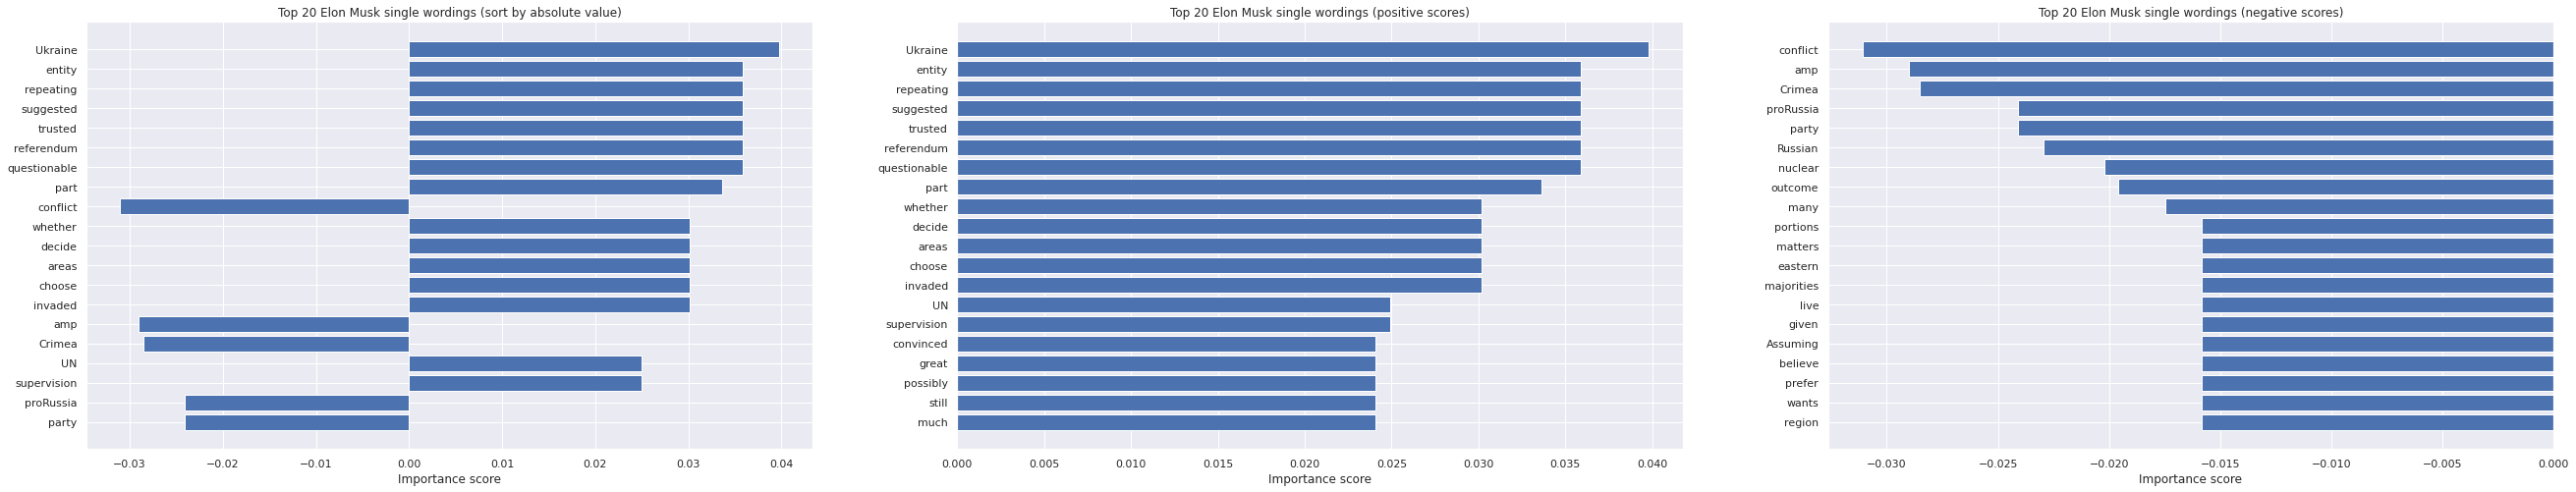

In [ ]:
single_importance_df, single_pos_importance_df, single_neg_importance_df, single_word_encoder, single_lr_model = regression_importance_plot(elon_main_tweets_proc, "text_part3_pr", ngram="single", encoder="bow", title="Elon Musk")

RMSE: 0.00026465537805184285


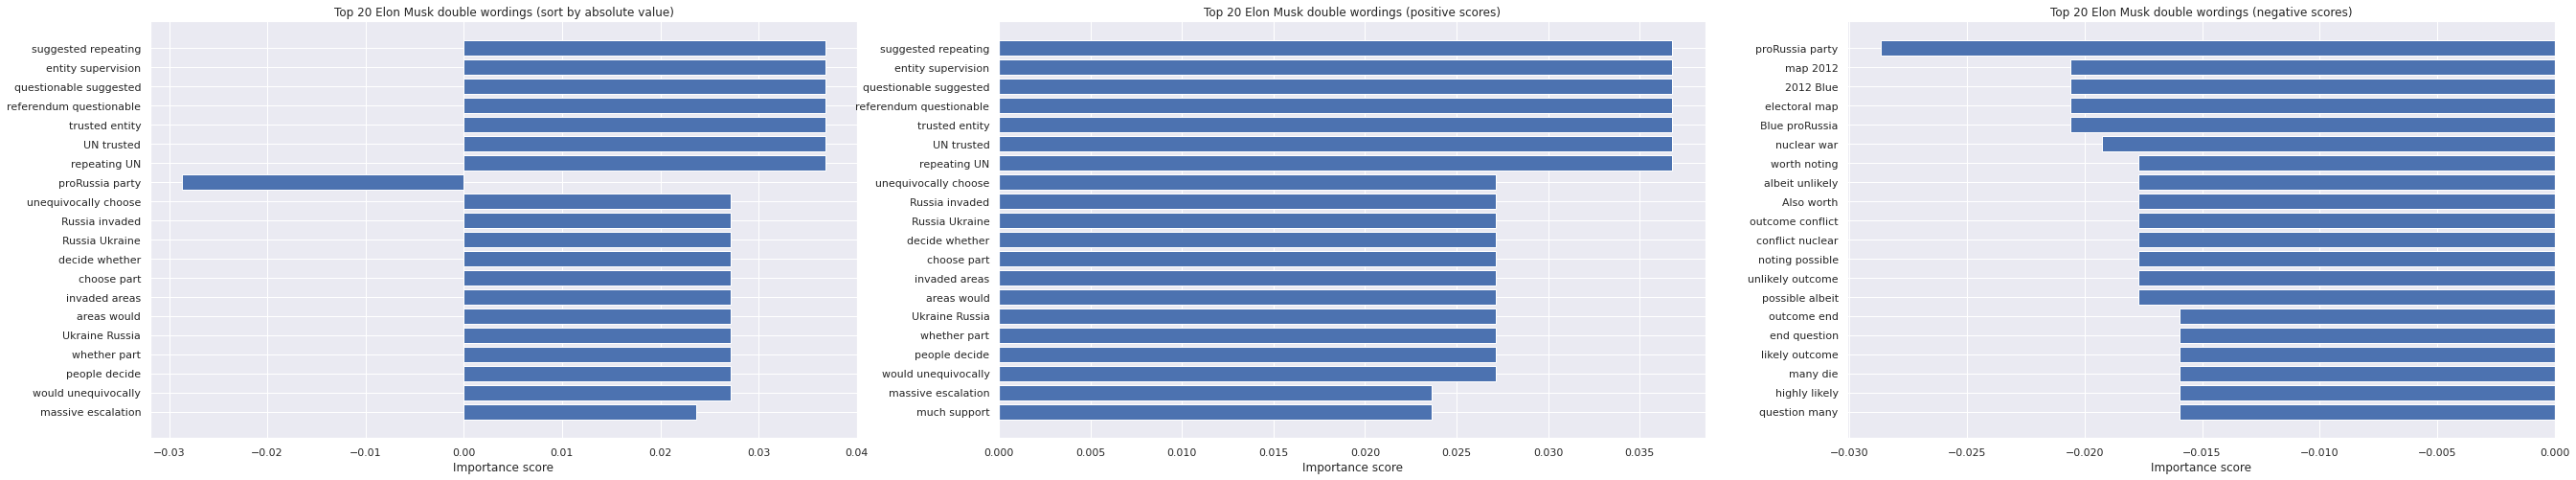

In [ ]:
double_importance_df, double_pos_importance_df, double_neg_importance_df, double_word_encoder, double_lr_model = regression_importance_plot(elon_main_tweets_proc, "text_part3_pr", ngram="double", encoder="bow", title="Elon Musk")

##### Ukraine

RMSE: 1.8057047419879588e-06


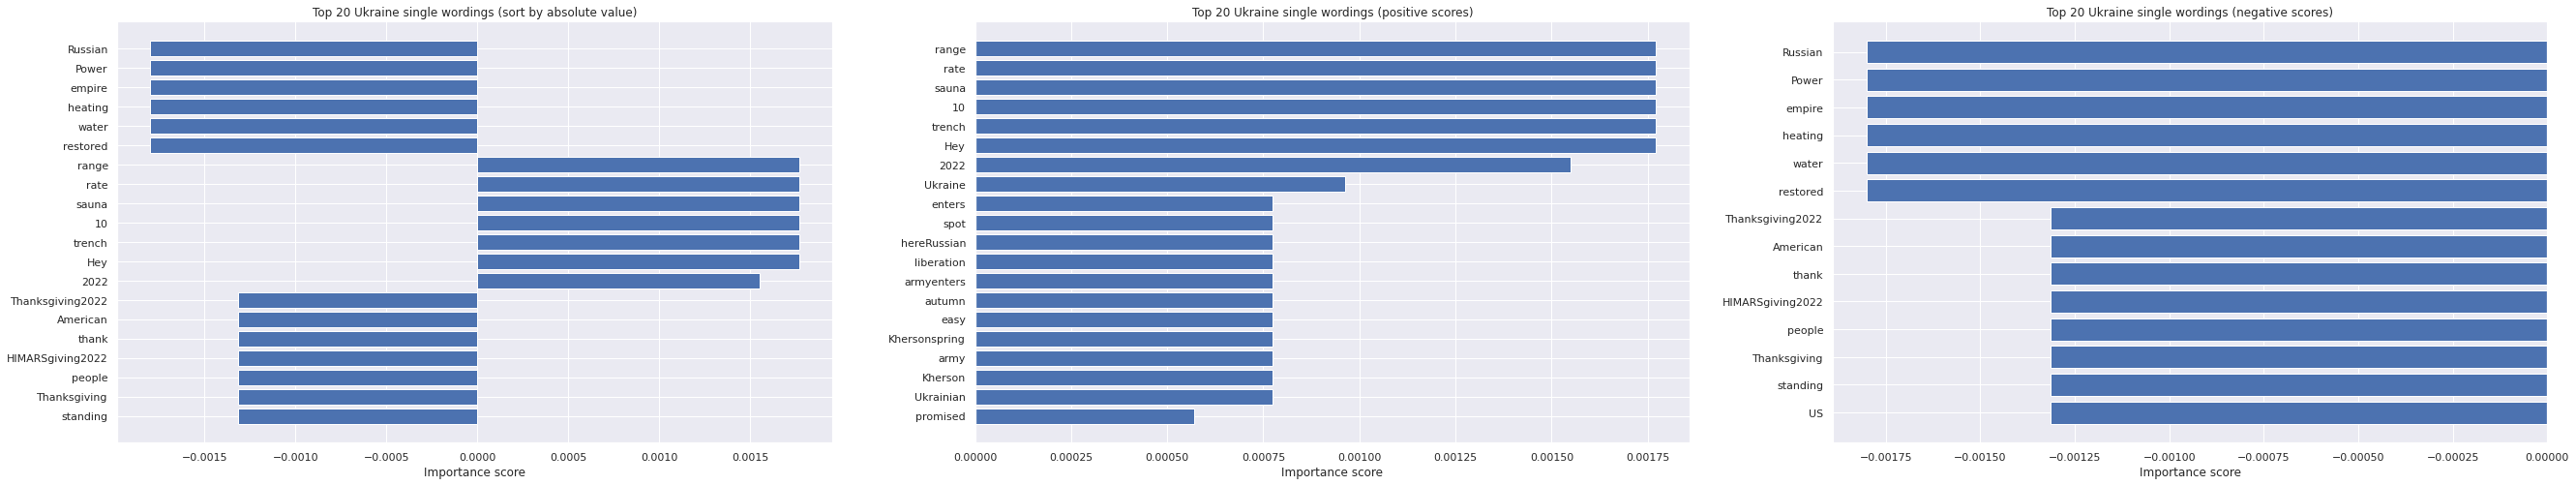

In [ ]:
ukraine_single_importance_df, ukraine_single_pos_importance_df, ukraine_single_neg_importance_df, ukraine_single_word_encoder, ukraine_single_lr_model = regression_importance_plot(ukraine_main_tweets_proc, "text_part3_pr", ngram="single", encoder="bow", title="Ukraine")

RMSE: 2.3194062019661877e-06


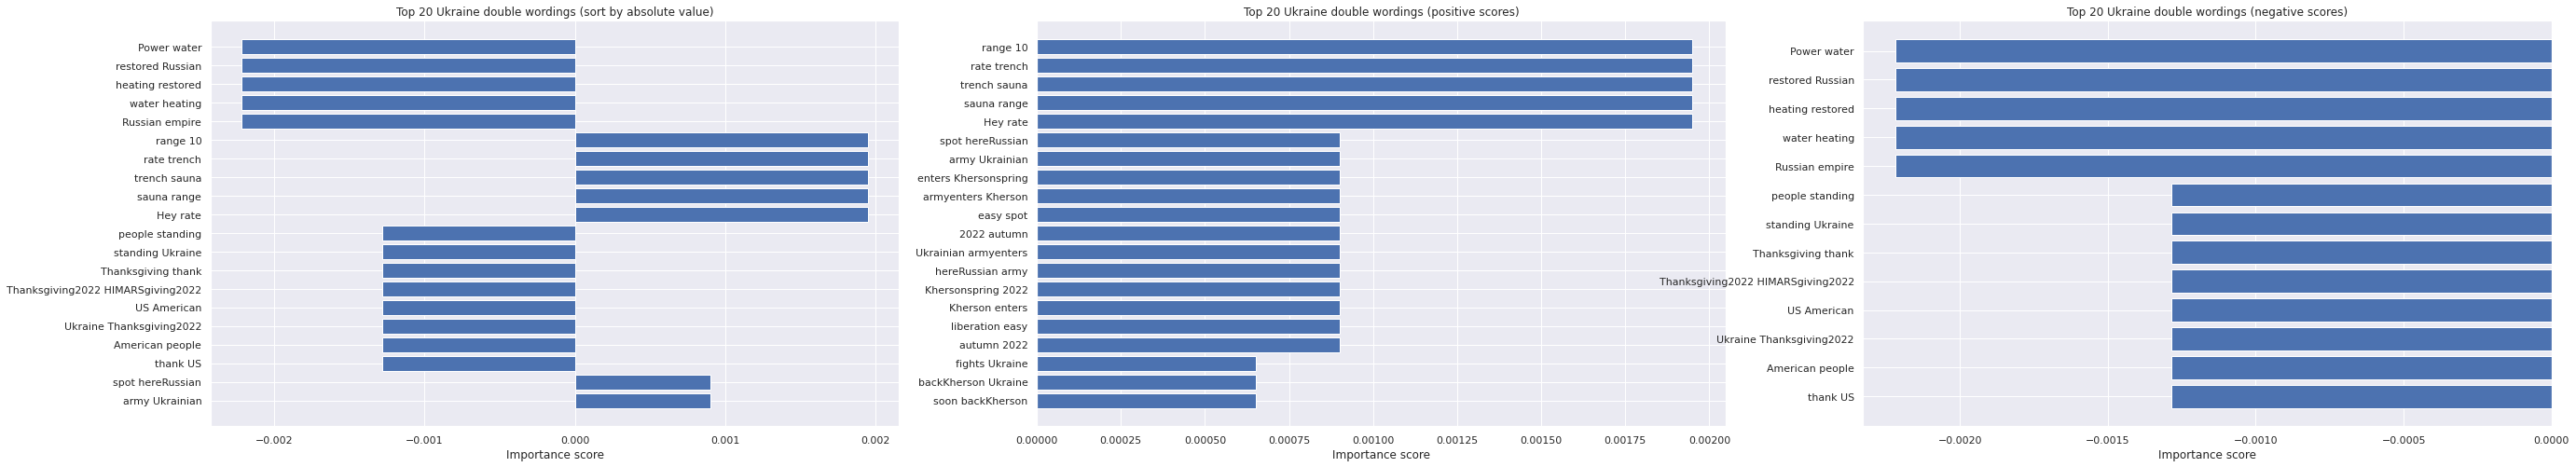

In [ ]:
ukraine_double_importance_df, ukraine_double_pos_importance_df, ukraine_double_neg_importance_df, ukraine_double_word_encoder, ukraine_double_lr_model = regression_importance_plot(ukraine_main_tweets_proc, "text_part3_pr", ngram="double", encoder="bow", title="Ukraine")

#### Wordclouds

##### Elon Musk

As we can see, if Elon Musk wants to raise the favour-Ukraine score in his replies, our product suggest him to:
1. Use more wordings that are not sound so certain and hard. 
2. And avoid talking about his own companies within this certain discussion.
3. Avoid obvious wordings that could sound favouring Russia, like proRussia partry.
4. Generally avoid wording relating to "nuclear war".

This product can then be applied on any incluencers that would like to support Ukraine.

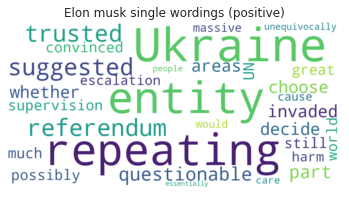

In [ ]:
mtweet_wordcloud(single_pos_importance_df,title="Elon musk single wordings (positive)")

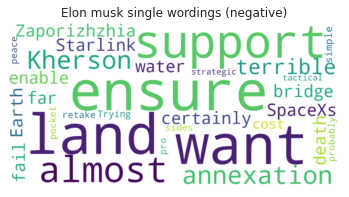

In [ ]:
mtweet_wordcloud(single_neg_importance_df,title="Elon musk single wordings (negative)")

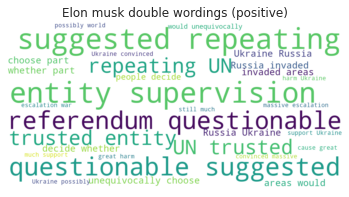

In [ ]:
mtweet_wordcloud(double_pos_importance_df,collocation_threshold=3,title="Elon musk double wordings (positive)")

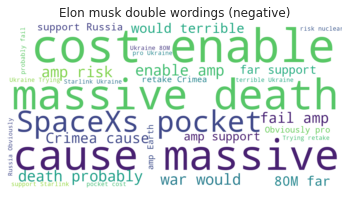

In [ ]:
mtweet_wordcloud(double_neg_importance_df,collocation_threshold=1,title="Elon musk double wordings (negative)")

##### Ukraine

As we can see, if Ukraine official account wants to raise the favour-Ukraine score in his replies, our product suggest him to:
1. Generally avoid talking about un-relavent holidays (Thanks giving).
2. Generally avoid using words like Russia, empire.
3. When use topics like heating restored, power restored. Consider directing the reasoning to the war and Russia, so some audiences have a clear target to release their frustration.


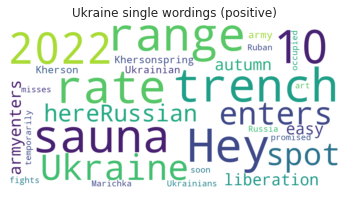

In [ ]:
mtweet_wordcloud(ukraine_single_pos_importance_df,title="Ukraine single wordings (positive)")

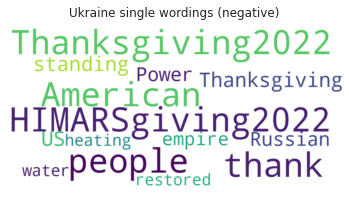

In [ ]:
mtweet_wordcloud(ukraine_single_neg_importance_df,title="Ukraine single wordings (negative)")

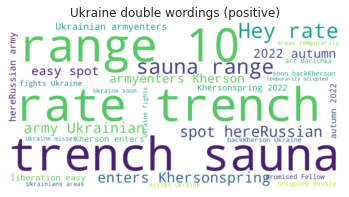

In [ ]:
mtweet_wordcloud(ukraine_double_pos_importance_df,title="Ukraine double wordings (positive)")

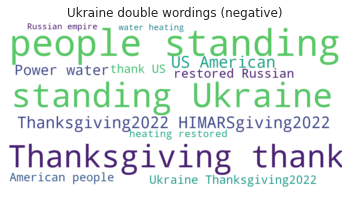

In [ ]:
mtweet_wordcloud(ukraine_double_neg_importance_df,title="Ukraine double wordings (negative)")

### Testsets

#### Elon Musk

In [ ]:
elon_main_tweets_proc.iloc[0]["text"]

'Let’s try this then: the will of the people who live in the Donbas &amp; Crimea should decide whether they’re part of Russia or Ukraine'

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

def proofreader_model(df_row, word_encoder, lr_model, proc_col="text_part3_pr"):
  input = [df_row[proc_col]]
  
  ngram_bow = word_encoder.transform(input)
  ngram_bow_df = pd.DataFrame(ngram_bow.toarray(), columns=word_encoder.get_feature_names_out())
  ngram_score = lr_model.predict(ngram_bow_df)  
  print("Proofreader score:",ngram_score[0])

  # Realscore
  print("Real score:",df_row["score"])

In [ ]:
elon_test = elon_main_tweets_proc.iloc[0]
proofreader_model(elon_test,single_word_encoder,single_lr_model)
proofreader_model(elon_test,double_word_encoder,double_lr_model)

Proofreader score: 0.402612629389022
Real score: 0.213
Proofreader score: 0.4114770325054474
Real score: 0.213


Given that we only have 16 tweets in our dataset (15 training and 1 test), our proofreader is still able to classify the tweet to the low score ones (<0.5).

This can be viewed a proof of concepts, that if given more data, it will for sure improve it's performance.

#### Ukraine

In [ ]:
ukraine_main_tweets_proc.iloc[0]["text"]

'🕯Today we honor the memory of innocent victims of the Holodomor genocide. Using hunger as a weapon, Stalin deliberately starved millions of Ukrainians in 1932-1933. Russia’s current genocidal war against Ukraine echoes this Soviet crime of the past.'

In [ ]:
ukraine_test = ukraine_main_tweets_proc.iloc[0]
proofreader_model(ukraine_test,ukraine_single_word_encoder,ukraine_single_lr_model)
proofreader_model(ukraine_test,ukraine_double_word_encoder,ukraine_double_lr_model)

Proofreader score: 0.9891383906522732
Real score: 0.9672131147540983
Proofreader score: 0.9882988802756244
Real score: 0.9672131147540983


### Proofreader: insights

We can see that by using our SNS **Proofreader** tools, government or companies can:

1. Have the model report a favourity score prediction before them send the post out.
2. And we are able to generate wordcloud and wording importance map with **Proofreader Hint** to aid customer edit their posts for better favourity score.